In [2]:
# Basics
from glob import glob # finds pathnames
import os # Miscellaneous operating system interfaces
import sys
import random
import timeit
import imp
import gc

# Processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.ndimage import label as scipy_label
from scipy.ndimage import generate_binary_structure

# Image manipulation
import skimage

# Import Mask RCNN
sys.path.append('mrcnn')  # To find local version of the library
from config import Config
# Imp import to ensure loading the correct utils package
fp, pathname, description = imp.find_module('utils',['mrcnn'])
utils = imp.load_module('utils',fp,pathname,description)
import model as modellib
import visualize
from model import log

# Plotting
import matplotlib.pyplot as plt

In [3]:
# Paths
ROOT_DIR = 'C:/Users/HPDQ/Mask_RCNN/DATASET/severstal'
Train_Dir = os.path.join(ROOT_DIR, 'train_images/')
Test_Dir = os.path.join(ROOT_DIR, 'test_images/')

# Directory to save logs and trained model
MODEL_DIR = 'logs'

# Local path to trained weights file
# Trained_Weights = '../input/????.h5'

In [4]:
print (Train_Dir)

C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images/


In [5]:
class SteelConfig(Config):
    """Configuration for training on the steel dataset.
    Derives from the base Config class and overrides values specific
    to the steel dataset.
    """
    # Give the configuration a recognizable name
    NAME = "steel"

    # Train on 1 GPU and 1 image per GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 4  # background + 4 defect classes

    # Use small images (128x128) for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our objects tend to be small 
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images have few objects.
    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7
    
    # Number of epochs
    EPOCHS = 20
    
    # Steps per epoch
    STEPS_PER_EPOCH = 100

    # validation steps per epoch
    VALIDATION_STEPS = 5
    
    # Non-maximum suppression threshold for detection, default 0.3
    DETECTION_NMS_THRESHOLD = 0.0
    
    # Non-max suppression threshold to filter RPN proposals. default 0.7
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.0
    
config = SteelConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.0
EPOCHS                         20
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE         

In [6]:
class SteelDataset(utils.Dataset):

    def load_steel(self, dataset_dir, files):
        """Load a subset of the Steel dataset.
        
        Input:
        dataset_dir: Root directory of the dataset.
        files: filenames of images to load
        
        Creates:
        image objects:
            source: source label
            image_id: id, used filename
            path: path + filename
            rle: rle mask encoded pixels, required for mask conversion
            classes: classes for the rle masks, required for mask conversion        
        """
        # Add classes.
        self.add_class("steel", 1, "defect1")
        self.add_class("steel", 2, "defect2")
        self.add_class("steel", 3, "defect3")
        self.add_class("steel", 4, "defect4")
        
        # Load annotations CSV
        annotations_train = pd.read_csv(r'C:\Users\HPDQ\Mask_RCNN\DATASET\severstal\train.csv')

        # Remove images without Encoding
        annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        
        
        # Split ImageId_ClassId
        #ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
        #annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
        #annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]     

        for file in files:
            EncodedPixels = [annotations_train_Encoded['EncodedPixels'][annotations_train_Encoded['ImageId'] == file]]
            ClassID = (annotations_train_Encoded['ClassId'][annotations_train_Encoded['ImageId'] == file])

            self.add_image(
                source = "steel",
                image_id = file,  # use filename as a unique image id
                path = Train_Dir + '/' + file,
                rle = EncodedPixels,
                classes = ClassID)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
        Input:
        image_id: id of the image
        
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D int array of class IDs of the instance masks.
        """
        # If not a steel dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "steel":
            return super(self.__class__, self).load_mask(image_id)
        
        # Convert rle to single mask
        ClassIDIndex = 0
        ClassID = np.empty(0, dtype = int)
        maskarray = np.empty((256, 1600, 0), dtype = int)
        for rlelist in image_info['rle']:
            for row in rlelist:
                mask= np.zeros(1600 * 256 ,dtype=np.uint8)
                array = np.asarray([int(x) for x in row.split()])
                starts = array[0::2]-1
                lengths = array[1::2]    
                for index, start in enumerate(starts):
                    mask[int(start):int(start+lengths[index])] = 1
                mask = mask.reshape((256,1600), order='F')
                # Label mask elements
                structure = generate_binary_structure(2,2)
                labeled_array, labels = scipy_label(mask, structure)
                # Convert labeled_array elements to bitmap mask array
                for label in range(labels):
                    labelmask = np.copy(labeled_array)    
                    labelmask[labelmask != label + 1] = 0
                    if label == 0:
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    else:
                        labelmask[labelmask == label + 1] = 1
                        labelmask = np.expand_dims(labelmask, axis = 2)
                        maskarray = np.concatenate((maskarray, labelmask), axis = 2)
                    # Update ClassID list
                    ClassID = np.append(ClassID,int(image_info['classes'].iloc[ClassIDIndex]))
                ClassIDIndex = ClassIDIndex + 1

        # Return mask, and array of class IDs of each instance.
        return maskarray.astype(np.bool), ClassID

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "steel":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

C:/Users/HPDQ/Mask_RCNN/DATASET/severstal
image_id  0 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//000a4bcdd.jpg
image                    shape: (256, 1600, 3)        min:   24.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 10)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (10,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (10, 4)               min:   55.00000  max:  462.00000  int32


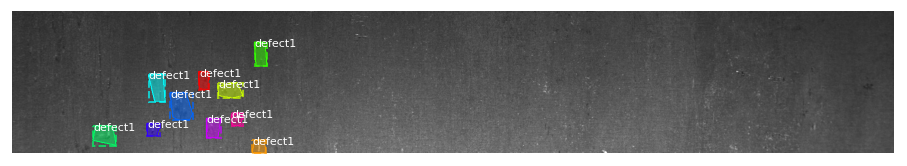

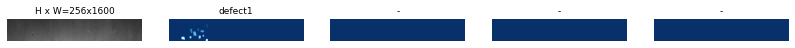

image_id  1 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//000f6bf48.jpg
image                    shape: (256, 1600, 3)        min:   16.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 2)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (2,)                  min:    4.00000  max:    4.00000  int32
bbox                     shape: (2, 4)                min:    0.00000  max: 1132.00000  int32


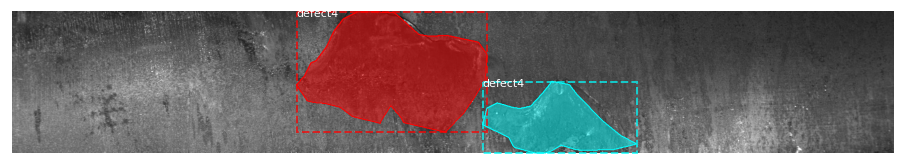

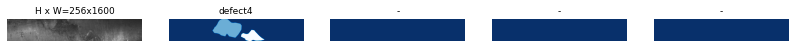

image_id  2 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//00ac8372f.jpg
image                    shape: (256, 1600, 3)        min:    1.00000  max:  253.00000  uint8
mask                     shape: (256, 1600, 3)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    2.00000  int32
bbox                     shape: (3, 4)                min:    0.00000  max:  451.00000  int32


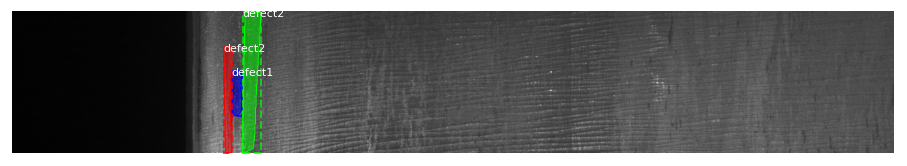

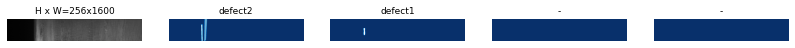

image_id  3 C:/Users/HPDQ/Mask_RCNN/DATASET/severstal\train_images//00af2671f.jpg
image                    shape: (256, 1600, 3)        min:   26.00000  max:  255.00000  uint8
mask                     shape: (256, 1600, 5)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (5,)                  min:    3.00000  max:    3.00000  int32
bbox                     shape: (5, 4)                min:    0.00000  max: 1121.00000  int32


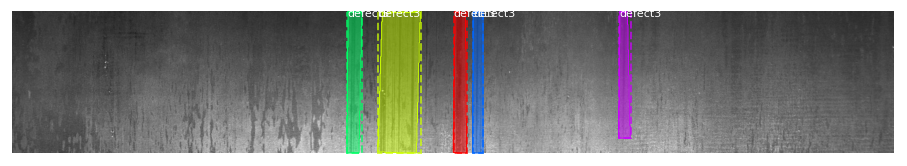

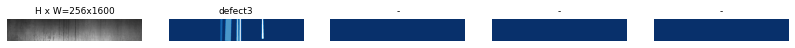

In [7]:
# Load example images and masks.
files = ['000a4bcdd.jpg', '000f6bf48.jpg', '00ac8372f.jpg', '00af2671f.jpg']
dataset = SteelDataset()
print(ROOT_DIR)
dataset.load_steel(ROOT_DIR, files)
dataset.prepare()

image_ids = [0,1,2,3] 
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    # Compute Bounding box
    bbox = utils.extract_bboxes(mask)
    # Display image and additional stats
    print("image_id ", image_id, dataset.image_reference(image_id))
    log("image", image)
    log("mask", mask)
    log("class_ids", class_ids)
    log("bbox", bbox)
    # Display image and instances
    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [9]:
# select files for test and validation dataset
# Load annotations CSV
annotations_train = pd.read_csv(r'C:\Users\HPDQ\Mask_RCNN\DATASET\severstal\train.csv')

# Remove images without Encoding
annotations_train_Encoded = annotations_train[annotations_train['EncodedPixels'].notna()].copy()        

# Split ImageId_ClassId
#ImageId_ClassId_split = annotations_train_Encoded["ImageId_ClassId"].str.split("_", n = 1, expand = True)
#annotations_train_Encoded['ImageId'] = ImageId_ClassId_split.loc[:,0]
#annotations_train_Encoded['ClassId'] = ImageId_ClassId_split.loc[:,1]

# Split dataframe
msk = np.random.rand(len(annotations_train_Encoded)) < 0.85
train_msk = annotations_train_Encoded[msk]
val_msk = annotations_train_Encoded[~msk]
train = train_msk['ImageId'].unique().copy()
val = val_msk['ImageId'].unique().copy()
print('Train images: ' + str(len(train)))
print('Test images: ' + str(len(val)))
# Cleanup
del annotations_train, annotations_train_Encoded, msk, train_msk, val_msk 
gc.collect()

Train images: 5746
Test images: 1026


0

In [10]:
# Training preperations
# Training dataset
dataset_train = SteelDataset()
dataset_train.load_steel(ROOT_DIR, train)
dataset_train.prepare()

# Validation dataset
dataset_val = SteelDataset()
dataset_val.load_steel(ROOT_DIR, val)
dataset_val.prepare()

# Build training model
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
# Required due to change in new Tensorflow / Keras version
model.keras_model.metrics_tensors = []
# Load weights to continue training
# model.load_weights(Trained_Weights, by_name=True)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [11]:
# Train model
timestart = timeit.default_timer()
print("Training")
model.train(dataset_train, 
            dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=config.EPOCHS,
            layers='all')
print ('Total run time: ' + str(runtime) + ' minutes')

Training

Starting at epoch 0. LR=0.001

Checkpoint Path: logs\steel20211009T0844\mask_rcnn_steel_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          (B

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "












Epoch 1/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 29:55 - loss: 60.3087 - rpn_class_loss: 28.6492 - rpn_bbox_loss: 12.4594 - mrcnn_class_loss: 19.2001 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 19:35 - loss: 53.5476 - rpn_class_loss: 26.2406 - rpn_bbox_loss: 11.8982 - mrcnn_class_loss: 15.4087 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 16:03 - loss: 49.6546 - rpn_class_loss: 24.4887 - rpn_bbox_loss: 14.5394 - mrcnn_class_loss: 10.6265 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 14:15 - loss: 44.6206 - rpn_class_loss: 20.7481 - rpn_bbox_loss: 15.9026 - mrcnn_class_loss: 7.9699 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 13:24 - loss: 40.1389 - rpn_class_loss: 17.1330 - rpn_bbox_loss: 16.6299 - mrcnn_class_loss: 6.3759 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 12:48 - loss: 35.4886 - rpn_class_loss: 14.4952 - rpn_bbox_loss: 15.6801 - mrcnn_class_loss: 5.3133 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 12:21 - loss: 31.6066 - rpn_class_loss: 12.5531 - rpn_bbox_loss: 14.4992 - mrcnn_class_loss: 4.5542 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 11:56 - loss: 28.6406 - rpn_class_loss: 11.0385 - rpn_bbox_loss: 13.6171 - mrcnn_class_loss: 3.9850 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 11:38 - loss: 26.1831 - rpn_class_loss: 9.9723 - rpn_bbox_loss: 12.6687 - mrcnn_class_loss: 3.5422 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 11:22 - loss: 24.1663 - rpn_class_loss: 9.0299 - rpn_bbox_loss: 11.9485 - mrcnn_class_loss: 3.1880 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 11:06 - loss: 22.5074 - rpn_class_loss: 8.2952 - rpn_bbox_loss: 11.3140 - mrcnn_class_loss: 2.8981 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:53 - loss: 21.2245 - rpn_class_loss: 7.6941 - rpn_bbox_loss: 10.8738 - mrcnn_class_loss: 2.6566 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 10:41 - loss: 20.2871 - rpn_class_loss: 7.1513 - rpn_bbox_loss: 10.6835 - mrcnn_class_loss: 2.4523 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 10:29 - loss: 19.1442 - rpn_class_loss: 6.6601 - rpn_bbox_loss: 10.2070 - mrcnn_class_loss: 2.2771 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 10:19 - loss: 18.3860 - rpn_class_loss: 6.2313 - rpn_bbox_loss: 10.0294 - mrcnn_class_loss: 2.1253 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 10:07 - loss: 17.7121 - rpn_class_loss: 5.8951 - rpn_bbox_loss: 9.8245 - mrcnn_class_loss: 1.9925 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:56 - loss: 17.1624 - rpn_class_loss: 5.5816 - rpn_bbox_loss: 9.7054 - mrcnn_class_loss: 1.8753 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:46 - loss: 16.4754 - rpn_class_loss: 5.2855 - rpn_bbox_loss: 9.4187 - mrcnn_class_loss: 1.7711 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:37 - loss: 15.8647 - rpn_class_loss: 5.0437 - rpn_bbox_loss: 9.1430 - mrcnn_class_loss: 1.6779 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:26 - loss: 15.4254 - rpn_class_loss: 4.8083 - rpn_bbox_loss: 9.0231 - mrcnn_class_loss: 1.5940 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:17 - loss: 15.4093 - rpn_class_loss: 4.7252 - rpn_bbox_loss: 9.1659 - mrcnn_class_loss: 1.5181 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 9:08 - loss: 14.8114 - rpn_class_loss: 4.5165 - rpn_bbox_loss: 8.8458 - mrcnn_class_loss: 1.4491 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 9:00 - loss: 14.4228 - rpn_class_loss: 4.3488 - rpn_bbox_loss: 8.6879 - mrcnn_class_loss: 1.3861 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:53 - loss: 14.1354 - rpn_class_loss: 4.1909 - rpn_bbox_loss: 8.6162 - mrcnn_class_loss: 1.3283 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:46 - loss: 13.7916 - rpn_class_loss: 4.0423 - rpn_bbox_loss: 8.4742 - mrcnn_class_loss: 1.2752 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:40 - loss: 13.4636 - rpn_class_loss: 3.9078 - rpn_bbox_loss: 8.3296 - mrcnn_class_loss: 1.2261 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:33 - loss: 13.1528 - rpn_class_loss: 3.7895 - rpn_bbox_loss: 8.1826 - mrcnn_class_loss: 1.1807 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:25 - loss: 12.7617 - rpn_class_loss: 3.6574 - rpn_bbox_loss: 7.9658 - mrcnn_class_loss: 1.1386 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:18 - loss: 12.5068 - rpn_class_loss: 3.5935 - rpn_bbox_loss: 7.8140 - mrcnn_class_loss: 1.0993 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:10 - loss: 12.1948 - rpn_class_loss: 3.4777 - rpn_bbox_loss: 7.6544 - mrcnn_class_loss: 1.0627 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 8:02 - loss: 12.0171 - rpn_class_loss: 3.3918 - rpn_bbox_loss: 7.5969 - mrcnn_class_loss: 1.0284 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:54 - loss: 11.7755 - rpn_class_loss: 3.2955 - rpn_bbox_loss: 7.4838 - mrcnn_class_loss: 0.9962 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:48 - loss: 11.5617 - rpn_class_loss: 3.1999 - rpn_bbox_loss: 7.3958 - mrcnn_class_loss: 0.9660 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:41 - loss: 11.3353 - rpn_class_loss: 3.1128 - rpn_bbox_loss: 7.2849 - mrcnn_class_loss: 0.9376 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:33 - loss: 11.1172 - rpn_class_loss: 3.0343 - rpn_bbox_loss: 7.1721 - mrcnn_class_loss: 0.9108 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:26 - loss: 10.9158 - rpn_class_loss: 2.9787 - rpn_bbox_loss: 7.0515 - mrcnn_class_loss: 0.8855 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:19 - loss: 10.7180 - rpn_class_loss: 2.9096 - rpn_bbox_loss: 6.9468 - mrcnn_class_loss: 0.8616 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:12 - loss: 10.5841 - rpn_class_loss: 2.8450 - rpn_bbox_loss: 6.9002 - mrcnn_class_loss: 0.8389 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 7:05 - loss: 10.3917 - rpn_class_loss: 2.7764 - rpn_bbox_loss: 6.7979 - mrcnn_class_loss: 0.8174 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:57 - loss: 10.2536 - rpn_class_loss: 2.7131 - rpn_bbox_loss: 6.7435 - mrcnn_class_loss: 0.7970 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:50 - loss: 10.2616 - rpn_class_loss: 2.6637 - rpn_bbox_loss: 6.8203 - mrcnn_class_loss: 0.7776 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:42 - loss: 10.0713 - rpn_class_loss: 2.6029 - rpn_bbox_loss: 6.7093 - mrcnn_class_loss: 0.7590 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:35 - loss: 9.9635 - rpn_class_loss: 2.5505 - rpn_bbox_loss: 6.6716 - mrcnn_class_loss: 0.7414 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:28 - loss: 9.8600 - rpn_class_loss: 2.4954 - rpn_bbox_loss: 6.6401 - mrcnn_class_loss: 0.7245 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:20 - loss: 9.7076 - rpn_class_loss: 2.4463 - rpn_bbox_loss: 6.5528 - mrcnn_class_loss: 0.7084 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:13 - loss: 9.6183 - rpn_class_loss: 2.3950 - rpn_bbox_loss: 6.5303 - mrcnn_class_loss: 0.6930 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:06 - loss: 9.4931 - rpn_class_loss: 2.3495 - rpn_bbox_loss: 6.4653 - mrcnn_class_loss: 0.6783 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:59 - loss: 9.4305 - rpn_class_loss: 2.3012 - rpn_bbox_loss: 6.4651 - mrcnn_class_loss: 0.6642 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:52 - loss: 9.2639 - rpn_class_loss: 2.2564 - rpn_bbox_loss: 6.3570 - mrcnn_class_loss: 0.6506 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:46 - loss: 9.1201 - rpn_class_loss: 2.2136 - rpn_bbox_loss: 6.2688 - mrcnn_class_loss: 0.6376 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:39 - loss: 9.0037 - rpn_class_loss: 2.1717 - rpn_bbox_loss: 6.2069 - mrcnn_class_loss: 0.6251 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:32 - loss: 8.9088 - rpn_class_loss: 2.1348 - rpn_bbox_loss: 6.1609 - mrcnn_class_loss: 0.6131 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:25 - loss: 8.8058 - rpn_class_loss: 2.1006 - rpn_bbox_loss: 6.1037 - mrcnn_class_loss: 0.6015 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:18 - loss: 8.7148 - rpn_class_loss: 2.0627 - rpn_bbox_loss: 6.0617 - mrcnn_class_loss: 0.5904 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:12 - loss: 8.5942 - rpn_class_loss: 2.0284 - rpn_bbox_loss: 5.9861 - mrcnn_class_loss: 0.5796 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:05 - loss: 8.5045 - rpn_class_loss: 1.9945 - rpn_bbox_loss: 5.9407 - mrcnn_class_loss: 0.5693 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:57 - loss: 8.3848 - rpn_class_loss: 1.9611 - rpn_bbox_loss: 5.8644 - mrcnn_class_loss: 0.5593 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:50 - loss: 8.2792 - rpn_class_loss: 1.9315 - rpn_bbox_loss: 5.7980 - mrcnn_class_loss: 0.5496 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:43 - loss: 8.1713 - rpn_class_loss: 1.9018 - rpn_bbox_loss: 5.7291 - mrcnn_class_loss: 0.5403 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:36 - loss: 8.0691 - rpn_class_loss: 1.8737 - rpn_bbox_loss: 5.6640 - mrcnn_class_loss: 0.5313 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:29 - loss: 7.9640 - rpn_class_loss: 1.8447 - rpn_bbox_loss: 5.5966 - mrcnn_class_loss: 0.5226 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:22 - loss: 7.8560 - rpn_class_loss: 1.8168 - rpn_bbox_loss: 5.5250 - mrcnn_class_loss: 0.5142 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:15 - loss: 7.7719 - rpn_class_loss: 1.7899 - rpn_bbox_loss: 5.4760 - mrcnn_class_loss: 0.5060 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:08 - loss: 7.7984 - rpn_class_loss: 1.7652 - rpn_bbox_loss: 5.5351 - mrcnn_class_loss: 0.4981 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:01 - loss: 7.7417 - rpn_class_loss: 1.7408 - rpn_bbox_loss: 5.5104 - mrcnn_class_loss: 0.4905 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:54 - loss: 7.7398 - rpn_class_loss: 1.7170 - rpn_bbox_loss: 5.5397 - mrcnn_class_loss: 0.4830 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:47 - loss: 7.7491 - rpn_class_loss: 1.6948 - rpn_bbox_loss: 5.5785 - mrcnn_class_loss: 0.4758 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:40 - loss: 7.6837 - rpn_class_loss: 1.6726 - rpn_bbox_loss: 5.5423 - mrcnn_class_loss: 0.4688 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:33 - loss: 7.6069 - rpn_class_loss: 1.6496 - rpn_bbox_loss: 5.4953 - mrcnn_class_loss: 0.4620 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:26 - loss: 7.5327 - rpn_class_loss: 1.6278 - rpn_bbox_loss: 5.4495 - mrcnn_class_loss: 0.4554 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:19 - loss: 7.5018 - rpn_class_loss: 1.6073 - rpn_bbox_loss: 5.4455 - mrcnn_class_loss: 0.4490 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:12 - loss: 7.4298 - rpn_class_loss: 1.5877 - rpn_bbox_loss: 5.3993 - mrcnn_class_loss: 0.4428 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:05 - loss: 7.3989 - rpn_class_loss: 1.5680 - rpn_bbox_loss: 5.3941 - mrcnn_class_loss: 0.4367 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 2:58 - loss: 7.3346 - rpn_class_loss: 1.5493 - rpn_bbox_loss: 5.3545 - mrcnn_class_loss: 0.4308 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:51 - loss: 7.2619 - rpn_class_loss: 1.5297 - rpn_bbox_loss: 5.3071 - mrcnn_class_loss: 0.4251 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:44 - loss: 7.1947 - rpn_class_loss: 1.5139 - rpn_bbox_loss: 5.2613 - mrcnn_class_loss: 0.4195 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:37 - loss: 7.1276 - rpn_class_loss: 1.4955 - rpn_bbox_loss: 5.2181 - mrcnn_class_loss: 0.4140 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:30 - loss: 7.0673 - rpn_class_loss: 1.4775 - rpn_bbox_loss: 5.1811 - mrcnn_class_loss: 0.4087 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:24 - loss: 7.0082 - rpn_class_loss: 1.4600 - rpn_bbox_loss: 5.1446 - mrcnn_class_loss: 0.4035 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:17 - loss: 6.9573 - rpn_class_loss: 1.4444 - rpn_bbox_loss: 5.1143 - mrcnn_class_loss: 0.3985 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:10 - loss: 6.9017 - rpn_class_loss: 1.4309 - rpn_bbox_loss: 5.0772 - mrcnn_class_loss: 0.3936 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:03 - loss: 6.8523 - rpn_class_loss: 1.4150 - rpn_bbox_loss: 5.0485 - mrcnn_class_loss: 0.3888 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:56 - loss: 6.8081 - rpn_class_loss: 1.4050 - rpn_bbox_loss: 5.0191 - mrcnn_class_loss: 0.3841 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:49 - loss: 6.7670 - rpn_class_loss: 1.3895 - rpn_bbox_loss: 4.9980 - mrcnn_class_loss: 0.3795 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:42 - loss: 6.7281 - rpn_class_loss: 1.3749 - rpn_bbox_loss: 4.9781 - mrcnn_class_loss: 0.3751 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:35 - loss: 6.6701 - rpn_class_loss: 1.3603 - rpn_bbox_loss: 4.9390 - mrcnn_class_loss: 0.3707 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:29 - loss: 6.6213 - rpn_class_loss: 1.3459 - rpn_bbox_loss: 4.9090 - mrcnn_class_loss: 0.3664 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:22 - loss: 6.5858 - rpn_class_loss: 1.3322 - rpn_bbox_loss: 4.8913 - mrcnn_class_loss: 0.3623 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:15 - loss: 6.5550 - rpn_class_loss: 1.3191 - rpn_bbox_loss: 4.8777 - mrcnn_class_loss: 0.3582 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:08 - loss: 6.5204 - rpn_class_loss: 1.3087 - rpn_bbox_loss: 4.8574 - mrcnn_class_loss: 0.3542 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:01 - loss: 6.4920 - rpn_class_loss: 1.2952 - rpn_bbox_loss: 4.8464 - mrcnn_class_loss: 0.3503 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 54s - loss: 6.4485 - rpn_class_loss: 1.2829 - rpn_bbox_loss: 4.8190 - mrcnn_class_loss: 0.3465 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 47s - loss: 6.4043 - rpn_class_loss: 1.2707 - rpn_bbox_loss: 4.7908 - mrcnn_class_loss: 0.3428 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 6.3569 - rpn_class_loss: 1.2586 - rpn_bbox_loss: 4.7591 - mrcnn_class_loss: 0.3391 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 6.3523 - rpn_class_loss: 1.2469 - rpn_bbox_loss: 4.7698 - mrcnn_class_loss: 0.3356 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 6.3003 - rpn_class_loss: 1.2349 - rpn_bbox_loss: 4.7334 - mrcnn_class_loss: 0.3321 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 6.2637 - rpn_class_loss: 1.2233 - rpn_bbox_loss: 4.7118 - mrcnn_class_loss: 0.3287 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 6.2315 - rpn_class_loss: 1.2119 - rpn_bbox_loss: 4.6942 - mrcnn_class_loss: 0.3253 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 6.1971 - rpn_class_loss: 1.2008 - rpn_bbox_loss: 4.6743 - mrcnn_class_loss: 0.3220 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 693s 7s/step - loss: 6.1664 - rpn_class_loss: 1.1916 - rpn_bbox_loss: 4.6560 - mrcnn_class_loss: 0.3188 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 3.3305 - val_rpn_class_loss: 0.2275 - val_rpn_bbox_loss: 3.1025 - val_mrcnn_class_loss: 4.9688e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00

Epoch 2/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 11:06 - loss: 2.2448 - rpn_class_loss: 0.2059 - rpn_bbox_loss: 2.0383 - mrcnn_class_loss: 4.9400e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 10:52 - loss: 2.1908 - rpn_class_loss: 0.2288 - rpn_bbox_loss: 1.9614 - mrcnn_class_loss: 5.0252e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 10:41 - loss: 2.5778 - rpn_class_loss: 0.2018 - rpn_bbox_loss: 2.3754 - mrcnn_class_loss: 4.9690e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 10:42 - loss: 2.5340 - rpn_class_loss: 0.2675 - rpn_bbox_loss: 2.2660 - mrcnn_class_loss: 4.9525e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 10:32 - loss: 2.6010 - rpn_class_loss: 0.2459 - rpn_bbox_loss: 2.3546 - mrcnn_class_loss: 5.1299e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 10:28 - loss: 2.4223 - rpn_class_loss: 0.2183 - rpn_bbox_loss: 2.2035 - mrcnn_class_loss: 5.3612e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:24 - loss: 2.3507 - rpn_class_loss: 0.2199 - rpn_bbox_loss: 2.1302 - mrcnn_class_loss: 5.6157e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:18 - loss: 2.3539 - rpn_class_loss: 0.2086 - rpn_bbox_loss: 2.1447 - mrcnn_class_loss: 5.9428e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:12 - loss: 2.2829 - rpn_class_loss: 0.1988 - rpn_bbox_loss: 2.0835 - mrcnn_class_loss: 6.3215e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:01 - loss: 2.2731 - rpn_class_loss: 0.1996 - rpn_bbox_loss: 2.0727 - mrcnn_class_loss: 6.8123e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 9:56 - loss: 2.4409 - rpn_class_loss: 0.1905 - rpn_bbox_loss: 2.2496 - mrcnn_class_loss: 7.3870e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 9:51 - loss: 2.4529 - rpn_class_loss: 0.1881 - rpn_bbox_loss: 2.2640 - mrcnn_class_loss: 8.0194e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 9:44 - loss: 2.4626 - rpn_class_loss: 0.1866 - rpn_bbox_loss: 2.2751 - mrcnn_class_loss: 8.5813e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:38 - loss: 2.4790 - rpn_class_loss: 0.1838 - rpn_bbox_loss: 2.2943 - mrcnn_class_loss: 8.8218e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:31 - loss: 2.5348 - rpn_class_loss: 0.1795 - rpn_bbox_loss: 2.3543 - mrcnn_class_loss: 8.9153e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:25 - loss: 2.4934 - rpn_class_loss: 0.1743 - rpn_bbox_loss: 2.3182 - mrcnn_class_loss: 8.8548e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:18 - loss: 2.5571 - rpn_class_loss: 0.1749 - rpn_bbox_loss: 2.3813 - mrcnn_class_loss: 8.6446e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:11 - loss: 2.5280 - rpn_class_loss: 0.1691 - rpn_bbox_loss: 2.3581 - mrcnn_class_loss: 8.3308e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:05 - loss: 2.5265 - rpn_class_loss: 0.1675 - rpn_bbox_loss: 2.3582 - mrcnn_class_loss: 8.0015e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 8:58 - loss: 2.4453 - rpn_class_loss: 0.1637 - rpn_bbox_loss: 2.2808 - mrcnn_class_loss: 7.6974e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 8:51 - loss: 2.3807 - rpn_class_loss: 0.1581 - rpn_bbox_loss: 2.2218 - mrcnn_class_loss: 7.4111e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:45 - loss: 2.3518 - rpn_class_loss: 0.1565 - rpn_bbox_loss: 2.1945 - mrcnn_class_loss: 7.1496e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:39 - loss: 2.4512 - rpn_class_loss: 0.1519 - rpn_bbox_loss: 2.2986 - mrcnn_class_loss: 6.9151e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:32 - loss: 2.5587 - rpn_class_loss: 0.1494 - rpn_bbox_loss: 2.4086 - mrcnn_class_loss: 6.7064e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:26 - loss: 2.4679 - rpn_class_loss: 0.1457 - rpn_bbox_loss: 2.3216 - mrcnn_class_loss: 6.5329e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:21 - loss: 2.5186 - rpn_class_loss: 0.1418 - rpn_bbox_loss: 2.3761 - mrcnn_class_loss: 6.3957e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:15 - loss: 2.5390 - rpn_class_loss: 0.1393 - rpn_bbox_loss: 2.3990 - mrcnn_class_loss: 6.2730e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:09 - loss: 2.5710 - rpn_class_loss: 0.1379 - rpn_bbox_loss: 2.4325 - mrcnn_class_loss: 6.1511e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:02 - loss: 2.5124 - rpn_class_loss: 0.1359 - rpn_bbox_loss: 2.3759 - mrcnn_class_loss: 6.0268e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 7:55 - loss: 2.4640 - rpn_class_loss: 0.1335 - rpn_bbox_loss: 2.3299 - mrcnn_class_loss: 5.8998e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:49 - loss: 2.4628 - rpn_class_loss: 0.1386 - rpn_bbox_loss: 2.3235 - mrcnn_class_loss: 5.7646e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:42 - loss: 2.4289 - rpn_class_loss: 0.1381 - rpn_bbox_loss: 2.2902 - mrcnn_class_loss: 5.6239e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:36 - loss: 2.3965 - rpn_class_loss: 0.1358 - rpn_bbox_loss: 2.2602 - mrcnn_class_loss: 5.4863e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:29 - loss: 2.4066 - rpn_class_loss: 0.1346 - rpn_bbox_loss: 2.2715 - mrcnn_class_loss: 5.3646e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:22 - loss: 2.3692 - rpn_class_loss: 0.1346 - rpn_bbox_loss: 2.2341 - mrcnn_class_loss: 5.2538e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:15 - loss: 2.3397 - rpn_class_loss: 0.1330 - rpn_bbox_loss: 2.2062 - mrcnn_class_loss: 5.1516e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:09 - loss: 2.3101 - rpn_class_loss: 0.1330 - rpn_bbox_loss: 2.1766 - mrcnn_class_loss: 5.0558e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:02 - loss: 2.2889 - rpn_class_loss: 0.1320 - rpn_bbox_loss: 2.1563 - mrcnn_class_loss: 4.9706e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 6:56 - loss: 2.2877 - rpn_class_loss: 0.1351 - rpn_bbox_loss: 2.1520 - mrcnn_class_loss: 4.9083e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:50 - loss: 2.3020 - rpn_class_loss: 0.1344 - rpn_bbox_loss: 2.1671 - mrcnn_class_loss: 4.8591e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:42 - loss: 2.3354 - rpn_class_loss: 0.1338 - rpn_bbox_loss: 2.2011 - mrcnn_class_loss: 4.8098e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:36 - loss: 2.3242 - rpn_class_loss: 0.1371 - rpn_bbox_loss: 2.1866 - mrcnn_class_loss: 4.7505e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:29 - loss: 2.3183 - rpn_class_loss: 0.1374 - rpn_bbox_loss: 2.1804 - mrcnn_class_loss: 4.6917e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:22 - loss: 2.3041 - rpn_class_loss: 0.1389 - rpn_bbox_loss: 2.1647 - mrcnn_class_loss: 4.6311e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:15 - loss: 2.3032 - rpn_class_loss: 0.1380 - rpn_bbox_loss: 2.1647 - mrcnn_class_loss: 4.5846e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:08 - loss: 2.2840 - rpn_class_loss: 0.1384 - rpn_bbox_loss: 2.1451 - mrcnn_class_loss: 4.5420e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:01 - loss: 2.2623 - rpn_class_loss: 0.1383 - rpn_bbox_loss: 2.1235 - mrcnn_class_loss: 4.4977e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:55 - loss: 2.2585 - rpn_class_loss: 0.1387 - rpn_bbox_loss: 2.1193 - mrcnn_class_loss: 4.4578e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:48 - loss: 2.2531 - rpn_class_loss: 0.1391 - rpn_bbox_loss: 2.1135 - mrcnn_class_loss: 4.4215e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:41 - loss: 2.2446 - rpn_class_loss: 0.1384 - rpn_bbox_loss: 2.1058 - mrcnn_class_loss: 4.3851e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:34 - loss: 2.2335 - rpn_class_loss: 0.1384 - rpn_bbox_loss: 2.0947 - mrcnn_class_loss: 4.3410e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:27 - loss: 2.2143 - rpn_class_loss: 0.1375 - rpn_bbox_loss: 2.0764 - mrcnn_class_loss: 4.2956e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:21 - loss: 2.1928 - rpn_class_loss: 0.1373 - rpn_bbox_loss: 2.0551 - mrcnn_class_loss: 4.2507e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:14 - loss: 2.1673 - rpn_class_loss: 0.1364 - rpn_bbox_loss: 2.0304 - mrcnn_class_loss: 4.2016e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:07 - loss: 2.1553 - rpn_class_loss: 0.1370 - rpn_bbox_loss: 2.0179 - mrcnn_class_loss: 4.1519e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:00 - loss: 2.1413 - rpn_class_loss: 0.1354 - rpn_bbox_loss: 2.0055 - mrcnn_class_loss: 4.1001e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:54 - loss: 2.1356 - rpn_class_loss: 0.1354 - rpn_bbox_loss: 1.9997 - mrcnn_class_loss: 4.0434e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:47 - loss: 2.1496 - rpn_class_loss: 0.1368 - rpn_bbox_loss: 2.0123 - mrcnn_class_loss: 3.9843e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:40 - loss: 2.1311 - rpn_class_loss: 0.1367 - rpn_bbox_loss: 1.9941 - mrcnn_class_loss: 3.9243e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:33 - loss: 2.1022 - rpn_class_loss: 0.1353 - rpn_bbox_loss: 1.9665 - mrcnn_class_loss: 3.8658e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:26 - loss: 2.0916 - rpn_class_loss: 0.1342 - rpn_bbox_loss: 1.9570 - mrcnn_class_loss: 3.8088e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:19 - loss: 2.0744 - rpn_class_loss: 0.1329 - rpn_bbox_loss: 1.9410 - mrcnn_class_loss: 3.7529e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:13 - loss: 2.0674 - rpn_class_loss: 0.1325 - rpn_bbox_loss: 1.9345 - mrcnn_class_loss: 3.6982e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:06 - loss: 2.0778 - rpn_class_loss: 0.1334 - rpn_bbox_loss: 1.9440 - mrcnn_class_loss: 3.6450e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 3:59 - loss: 2.0894 - rpn_class_loss: 0.1330 - rpn_bbox_loss: 1.9560 - mrcnn_class_loss: 3.5927e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:52 - loss: 2.1364 - rpn_class_loss: 0.1319 - rpn_bbox_loss: 2.0041 - mrcnn_class_loss: 3.5417e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:45 - loss: 2.1123 - rpn_class_loss: 0.1304 - rpn_bbox_loss: 1.9815 - mrcnn_class_loss: 3.4921e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:39 - loss: 2.1155 - rpn_class_loss: 0.1314 - rpn_bbox_loss: 1.9837 - mrcnn_class_loss: 3.4447e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:32 - loss: 2.1442 - rpn_class_loss: 0.1325 - rpn_bbox_loss: 2.0114 - mrcnn_class_loss: 3.3994e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:25 - loss: 2.1666 - rpn_class_loss: 0.1321 - rpn_bbox_loss: 2.0341 - mrcnn_class_loss: 3.3570e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:18 - loss: 2.1541 - rpn_class_loss: 0.1310 - rpn_bbox_loss: 2.0228 - mrcnn_class_loss: 3.3191e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:11 - loss: 2.1466 - rpn_class_loss: 0.1305 - rpn_bbox_loss: 2.0158 - mrcnn_class_loss: 3.2905e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:04 - loss: 2.1533 - rpn_class_loss: 0.1298 - rpn_bbox_loss: 2.0231 - mrcnn_class_loss: 3.2756e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 2:57 - loss: 2.1522 - rpn_class_loss: 0.1288 - rpn_bbox_loss: 2.0231 - mrcnn_class_loss: 3.2704e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:51 - loss: 2.1489 - rpn_class_loss: 0.1289 - rpn_bbox_loss: 2.0196 - mrcnn_class_loss: 3.2753e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:44 - loss: 2.1555 - rpn_class_loss: 0.1283 - rpn_bbox_loss: 2.0269 - mrcnn_class_loss: 3.2855e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:37 - loss: 2.1617 - rpn_class_loss: 0.1288 - rpn_bbox_loss: 2.0326 - mrcnn_class_loss: 3.2933e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:30 - loss: 2.1520 - rpn_class_loss: 0.1279 - rpn_bbox_loss: 2.0237 - mrcnn_class_loss: 3.3005e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:23 - loss: 2.1410 - rpn_class_loss: 0.1273 - rpn_bbox_loss: 2.0133 - mrcnn_class_loss: 3.3060e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:16 - loss: 2.1497 - rpn_class_loss: 0.1265 - rpn_bbox_loss: 2.0229 - mrcnn_class_loss: 3.3088e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:10 - loss: 2.1618 - rpn_class_loss: 0.1258 - rpn_bbox_loss: 2.0357 - mrcnn_class_loss: 3.3119e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:03 - loss: 2.1555 - rpn_class_loss: 0.1269 - rpn_bbox_loss: 2.0283 - mrcnn_class_loss: 3.3181e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:56 - loss: 2.1552 - rpn_class_loss: 0.1271 - rpn_bbox_loss: 2.0277 - mrcnn_class_loss: 3.3236e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:49 - loss: 2.1531 - rpn_class_loss: 0.1278 - rpn_bbox_loss: 2.0250 - mrcnn_class_loss: 3.3299e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:42 - loss: 2.1417 - rpn_class_loss: 0.1273 - rpn_bbox_loss: 2.0140 - mrcnn_class_loss: 3.3352e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:35 - loss: 2.1251 - rpn_class_loss: 0.1267 - rpn_bbox_loss: 1.9981 - mrcnn_class_loss: 3.3479e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:28 - loss: 2.1266 - rpn_class_loss: 0.1267 - rpn_bbox_loss: 1.9996 - mrcnn_class_loss: 3.3602e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:22 - loss: 2.1238 - rpn_class_loss: 0.1262 - rpn_bbox_loss: 1.9972 - mrcnn_class_loss: 3.3705e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:15 - loss: 2.1288 - rpn_class_loss: 0.1259 - rpn_bbox_loss: 2.0025 - mrcnn_class_loss: 3.3788e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:08 - loss: 2.1141 - rpn_class_loss: 0.1254 - rpn_bbox_loss: 1.9883 - mrcnn_class_loss: 3.3942e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:01 - loss: 2.1018 - rpn_class_loss: 0.1249 - rpn_bbox_loss: 1.9765 - mrcnn_class_loss: 3.4090e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 54s - loss: 2.1083 - rpn_class_loss: 0.1247 - rpn_bbox_loss: 1.9832 - mrcnn_class_loss: 3.4204e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 47s - loss: 2.1046 - rpn_class_loss: 0.1247 - rpn_bbox_loss: 1.9795 - mrcnn_class_loss: 3.4264e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 2.1041 - rpn_class_loss: 0.1246 - rpn_bbox_loss: 1.9791 - mrcnn_class_loss: 3.4292e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 2.1150 - rpn_class_loss: 0.1250 - rpn_bbox_loss: 1.9896 - mrcnn_class_loss: 3.4256e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 2.1417 - rpn_class_loss: 0.1255 - rpn_bbox_loss: 2.0158 - mrcnn_class_loss: 3.4171e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 2.1379 - rpn_class_loss: 0.1265 - rpn_bbox_loss: 2.0111 - mrcnn_class_loss: 3.4034e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 2.1503 - rpn_class_loss: 0.1262 - rpn_bbox_loss: 2.0237 - mrcnn_class_loss: 3.3863e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 2.1553 - rpn_class_loss: 0.1262 - rpn_bbox_loss: 2.0288 - mrcnn_class_loss: 3.3710e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 692s 7s/step - loss: 2.1494 - rpn_class_loss: 0.1263 - rpn_bbox_loss: 2.0227 - mrcnn_class_loss: 3.3588e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 2.9424 - val_rpn_class_loss: 0.1926 - val_rpn_bbox_loss: 2.7496 - val_mrcnn_class_loss: 1.9439e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 3/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 9:14 - loss: 3.0579 - rpn_class_loss: 0.2356 - rpn_bbox_loss: 2.8221 - mrcnn_class_loss: 1.9417e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 9:11 - loss: 4.6768 - rpn_class_loss: 0.1674 - rpn_bbox_loss: 4.5092 - mrcnn_class_loss: 1.8500e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 9:07 - loss: 3.7705 - rpn_class_loss: 0.1445 - rpn_bbox_loss: 3.6258 - mrcnn_class_loss: 1.7252e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 9:31 - loss: 3.5680 - rpn_class_loss: 0.1536 - rpn_bbox_loss: 3.4143 - mrcnn_class_loss: 1.5532e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 9:41 - loss: 3.0611 - rpn_class_loss: 0.1388 - rpn_bbox_loss: 2.9222 - mrcnn_class_loss: 1.4085e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 9:46 - loss: 2.8172 - rpn_class_loss: 0.1250 - rpn_bbox_loss: 2.6920 - mrcnn_class_loss: 1.2965e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 9:48 - loss: 2.6811 - rpn_class_loss: 0.1349 - rpn_bbox_loss: 2.5461 - mrcnn_class_loss: 1.2000e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 9:48 - loss: 2.4416 - rpn_class_loss: 0.1246 - rpn_bbox_loss: 2.3168 - mrcnn_class_loss: 1.1139e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 9:47 - loss: 2.3723 - rpn_class_loss: 0.1179 - rpn_bbox_loss: 2.2543 - mrcnn_class_loss: 1.0255e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 9:43 - loss: 2.3451 - rpn_class_loss: 0.1111 - rpn_bbox_loss: 2.2339 - mrcnn_class_loss: 9.4896e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 9:39 - loss: 2.3175 - rpn_class_loss: 0.1152 - rpn_bbox_loss: 2.2022 - mrcnn_class_loss: 8.8264e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 9:36 - loss: 2.2648 - rpn_class_loss: 0.1277 - rpn_bbox_loss: 2.1370 - mrcnn_class_loss: 8.2756e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 9:31 - loss: 2.2711 - rpn_class_loss: 0.1202 - rpn_bbox_loss: 2.1508 - mrcnn_class_loss: 7.8197e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:26 - loss: 2.2569 - rpn_class_loss: 0.1472 - rpn_bbox_loss: 2.1096 - mrcnn_class_loss: 7.4161e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:21 - loss: 2.2640 - rpn_class_loss: 0.1439 - rpn_bbox_loss: 2.1201 - mrcnn_class_loss: 7.0941e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:14 - loss: 2.2394 - rpn_class_loss: 0.1424 - rpn_bbox_loss: 2.0970 - mrcnn_class_loss: 6.8787e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:10 - loss: 2.2519 - rpn_class_loss: 0.1511 - rpn_bbox_loss: 2.1008 - mrcnn_class_loss: 6.8927e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:04 - loss: 2.2105 - rpn_class_loss: 0.1476 - rpn_bbox_loss: 2.0629 - mrcnn_class_loss: 7.2190e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 8:59 - loss: 2.2207 - rpn_class_loss: 0.1493 - rpn_bbox_loss: 2.0714 - mrcnn_class_loss: 7.9815e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 8:52 - loss: 2.2871 - rpn_class_loss: 0.1467 - rpn_bbox_loss: 2.1403 - mrcnn_class_loss: 9.2517e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 8:46 - loss: 2.2151 - rpn_class_loss: 0.1450 - rpn_bbox_loss: 2.0700 - mrcnn_class_loss: 1.0895e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:40 - loss: 2.2500 - rpn_class_loss: 0.1423 - rpn_bbox_loss: 2.1075 - mrcnn_class_loss: 1.2942e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:34 - loss: 2.1650 - rpn_class_loss: 0.1401 - rpn_bbox_loss: 2.0247 - mrcnn_class_loss: 1.4840e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:31 - loss: 2.1390 - rpn_class_loss: 0.1411 - rpn_bbox_loss: 1.9977 - mrcnn_class_loss: 1.6345e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:24 - loss: 2.2033 - rpn_class_loss: 0.1413 - rpn_bbox_loss: 2.0618 - mrcnn_class_loss: 1.7365e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:18 - loss: 2.1737 - rpn_class_loss: 0.1378 - rpn_bbox_loss: 2.0357 - mrcnn_class_loss: 1.8028e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:11 - loss: 2.1528 - rpn_class_loss: 0.1384 - rpn_bbox_loss: 2.0142 - mrcnn_class_loss: 1.8615e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:04 - loss: 2.1592 - rpn_class_loss: 0.1364 - rpn_bbox_loss: 2.0226 - mrcnn_class_loss: 1.9212e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 7:58 - loss: 2.1684 - rpn_class_loss: 0.1362 - rpn_bbox_loss: 2.0320 - mrcnn_class_loss: 1.9858e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 7:51 - loss: 2.1435 - rpn_class_loss: 0.1347 - rpn_bbox_loss: 2.0086 - mrcnn_class_loss: 2.0463e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:44 - loss: 2.1769 - rpn_class_loss: 0.1325 - rpn_bbox_loss: 2.0442 - mrcnn_class_loss: 2.1017e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:38 - loss: 2.1581 - rpn_class_loss: 0.1296 - rpn_bbox_loss: 2.0283 - mrcnn_class_loss: 2.1428e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:31 - loss: 2.1780 - rpn_class_loss: 0.1278 - rpn_bbox_loss: 2.0500 - mrcnn_class_loss: 2.1639e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:25 - loss: 2.1979 - rpn_class_loss: 0.1340 - rpn_bbox_loss: 2.0636 - mrcnn_class_loss: 2.1711e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:19 - loss: 2.1764 - rpn_class_loss: 0.1339 - rpn_bbox_loss: 2.0423 - mrcnn_class_loss: 2.1787e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:12 - loss: 2.1603 - rpn_class_loss: 0.1315 - rpn_bbox_loss: 2.0285 - mrcnn_class_loss: 2.1834e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:06 - loss: 2.1633 - rpn_class_loss: 0.1300 - rpn_bbox_loss: 2.0331 - mrcnn_class_loss: 2.1946e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 6:59 - loss: 2.1438 - rpn_class_loss: 0.1290 - rpn_bbox_loss: 2.0145 - mrcnn_class_loss: 2.2344e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 6:53 - loss: 2.2329 - rpn_class_loss: 0.1304 - rpn_bbox_loss: 2.1022 - mrcnn_class_loss: 2.3087e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:46 - loss: 2.2014 - rpn_class_loss: 0.1297 - rpn_bbox_loss: 2.0715 - mrcnn_class_loss: 2.4117e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:39 - loss: 2.2124 - rpn_class_loss: 0.1316 - rpn_bbox_loss: 2.0805 - mrcnn_class_loss: 2.5192e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:33 - loss: 2.2465 - rpn_class_loss: 0.1309 - rpn_bbox_loss: 2.1153 - mrcnn_class_loss: 2.6641e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:26 - loss: 2.2346 - rpn_class_loss: 0.1314 - rpn_bbox_loss: 2.1029 - mrcnn_class_loss: 2.8838e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:19 - loss: 2.2110 - rpn_class_loss: 0.1311 - rpn_bbox_loss: 2.0796 - mrcnn_class_loss: 3.0956e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:13 - loss: 2.2154 - rpn_class_loss: 0.1307 - rpn_bbox_loss: 2.0843 - mrcnn_class_loss: 3.2490e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:06 - loss: 2.1870 - rpn_class_loss: 0.1298 - rpn_bbox_loss: 2.0568 - mrcnn_class_loss: 3.3129e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 5:59 - loss: 2.1967 - rpn_class_loss: 0.1293 - rpn_bbox_loss: 2.0670 - mrcnn_class_loss: 3.3218e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:53 - loss: 2.1790 - rpn_class_loss: 0.1298 - rpn_bbox_loss: 2.0488 - mrcnn_class_loss: 3.2786e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:46 - loss: 2.2501 - rpn_class_loss: 0.1287 - rpn_bbox_loss: 2.1211 - mrcnn_class_loss: 3.2231e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:39 - loss: 2.2550 - rpn_class_loss: 0.1278 - rpn_bbox_loss: 2.1269 - mrcnn_class_loss: 3.1647e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:32 - loss: 2.2714 - rpn_class_loss: 0.1274 - rpn_bbox_loss: 2.1436 - mrcnn_class_loss: 3.1074e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:25 - loss: 2.2582 - rpn_class_loss: 0.1261 - rpn_bbox_loss: 2.1318 - mrcnn_class_loss: 3.0516e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:19 - loss: 2.2530 - rpn_class_loss: 0.1244 - rpn_bbox_loss: 2.1282 - mrcnn_class_loss: 2.9979e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:13 - loss: 2.2372 - rpn_class_loss: 0.1238 - rpn_bbox_loss: 2.1131 - mrcnn_class_loss: 2.9467e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:06 - loss: 2.3045 - rpn_class_loss: 0.1263 - rpn_bbox_loss: 2.1779 - mrcnn_class_loss: 2.8974e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 4:59 - loss: 2.3225 - rpn_class_loss: 0.1303 - rpn_bbox_loss: 2.1919 - mrcnn_class_loss: 2.8514e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:53 - loss: 2.3047 - rpn_class_loss: 0.1302 - rpn_bbox_loss: 2.1743 - mrcnn_class_loss: 2.8138e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:46 - loss: 2.3161 - rpn_class_loss: 0.1293 - rpn_bbox_loss: 2.1865 - mrcnn_class_loss: 2.7936e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:40 - loss: 2.2968 - rpn_class_loss: 0.1289 - rpn_bbox_loss: 2.1676 - mrcnn_class_loss: 2.8057e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:33 - loss: 2.3238 - rpn_class_loss: 0.1292 - rpn_bbox_loss: 2.1943 - mrcnn_class_loss: 2.8821e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:26 - loss: 2.3469 - rpn_class_loss: 0.1291 - rpn_bbox_loss: 2.2174 - mrcnn_class_loss: 2.9587e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:19 - loss: 2.3434 - rpn_class_loss: 0.1287 - rpn_bbox_loss: 2.2143 - mrcnn_class_loss: 3.0001e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:13 - loss: 2.3842 - rpn_class_loss: 0.1276 - rpn_bbox_loss: 2.2563 - mrcnn_class_loss: 3.0048e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:06 - loss: 2.4004 - rpn_class_loss: 0.1261 - rpn_bbox_loss: 2.2739 - mrcnn_class_loss: 2.9900e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 3:59 - loss: 2.4095 - rpn_class_loss: 0.1282 - rpn_bbox_loss: 2.2809 - mrcnn_class_loss: 2.9657e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:52 - loss: 2.3904 - rpn_class_loss: 0.1272 - rpn_bbox_loss: 2.2629 - mrcnn_class_loss: 2.9400e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:45 - loss: 2.4076 - rpn_class_loss: 0.1273 - rpn_bbox_loss: 2.2800 - mrcnn_class_loss: 2.9161e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:38 - loss: 2.3844 - rpn_class_loss: 0.1263 - rpn_bbox_loss: 2.2578 - mrcnn_class_loss: 2.8970e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:31 - loss: 2.3702 - rpn_class_loss: 0.1248 - rpn_bbox_loss: 2.2450 - mrcnn_class_loss: 2.8865e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:25 - loss: 2.3898 - rpn_class_loss: 0.1249 - rpn_bbox_loss: 2.2646 - mrcnn_class_loss: 2.8828e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:18 - loss: 2.3830 - rpn_class_loss: 0.1260 - rpn_bbox_loss: 2.2566 - mrcnn_class_loss: 2.8815e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:11 - loss: 2.3759 - rpn_class_loss: 0.1266 - rpn_bbox_loss: 2.2490 - mrcnn_class_loss: 2.8850e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:04 - loss: 2.3932 - rpn_class_loss: 0.1256 - rpn_bbox_loss: 2.2673 - mrcnn_class_loss: 2.8928e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 2:57 - loss: 2.3872 - rpn_class_loss: 0.1244 - rpn_bbox_loss: 2.2624 - mrcnn_class_loss: 2.9044e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:50 - loss: 2.4014 - rpn_class_loss: 0.1239 - rpn_bbox_loss: 2.2771 - mrcnn_class_loss: 2.9191e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:44 - loss: 2.3941 - rpn_class_loss: 0.1233 - rpn_bbox_loss: 2.2704 - mrcnn_class_loss: 2.9428e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:37 - loss: 2.3831 - rpn_class_loss: 0.1244 - rpn_bbox_loss: 2.2584 - mrcnn_class_loss: 2.9636e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:30 - loss: 2.3643 - rpn_class_loss: 0.1240 - rpn_bbox_loss: 2.2399 - mrcnn_class_loss: 2.9878e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:23 - loss: 2.3492 - rpn_class_loss: 0.1235 - rpn_bbox_loss: 2.2253 - mrcnn_class_loss: 3.0169e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:16 - loss: 2.3419 - rpn_class_loss: 0.1231 - rpn_bbox_loss: 2.2184 - mrcnn_class_loss: 3.0623e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:09 - loss: 2.3302 - rpn_class_loss: 0.1227 - rpn_bbox_loss: 2.2071 - mrcnn_class_loss: 3.1081e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:03 - loss: 2.3256 - rpn_class_loss: 0.1227 - rpn_bbox_loss: 2.2026 - mrcnn_class_loss: 3.1773e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:56 - loss: 2.3175 - rpn_class_loss: 0.1231 - rpn_bbox_loss: 2.1940 - mrcnn_class_loss: 3.2867e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:49 - loss: 2.3136 - rpn_class_loss: 0.1227 - rpn_bbox_loss: 2.1906 - mrcnn_class_loss: 3.4312e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:42 - loss: 2.3306 - rpn_class_loss: 0.1227 - rpn_bbox_loss: 2.2075 - mrcnn_class_loss: 3.5430e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:35 - loss: 2.3196 - rpn_class_loss: 0.1220 - rpn_bbox_loss: 2.1972 - mrcnn_class_loss: 3.5968e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:28 - loss: 2.3152 - rpn_class_loss: 0.1220 - rpn_bbox_loss: 2.1928 - mrcnn_class_loss: 3.6068e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:22 - loss: 2.3084 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 2.1868 - mrcnn_class_loss: 3.6071e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:15 - loss: 2.2902 - rpn_class_loss: 0.1205 - rpn_bbox_loss: 2.1694 - mrcnn_class_loss: 3.5991e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:08 - loss: 2.2787 - rpn_class_loss: 0.1197 - rpn_bbox_loss: 2.1586 - mrcnn_class_loss: 3.5873e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:01 - loss: 2.2842 - rpn_class_loss: 0.1210 - rpn_bbox_loss: 2.1628 - mrcnn_class_loss: 3.5695e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 54s - loss: 2.2750 - rpn_class_loss: 0.1201 - rpn_bbox_loss: 2.1545 - mrcnn_class_loss: 3.5510e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 47s - loss: 2.2690 - rpn_class_loss: 0.1197 - rpn_bbox_loss: 2.1489 - mrcnn_class_loss: 3.5360e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 2.2626 - rpn_class_loss: 0.1189 - rpn_bbox_loss: 2.1433 - mrcnn_class_loss: 3.5264e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 2.2582 - rpn_class_loss: 0.1186 - rpn_bbox_loss: 2.1392 - mrcnn_class_loss: 3.5226e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 2.2553 - rpn_class_loss: 0.1182 - rpn_bbox_loss: 2.1367 - mrcnn_class_loss: 3.5183e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 2.2708 - rpn_class_loss: 0.1181 - rpn_bbox_loss: 2.1523 - mrcnn_class_loss: 3.5224e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 2.2606 - rpn_class_loss: 0.1190 - rpn_bbox_loss: 2.1412 - mrcnn_class_loss: 3.5244e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 2.2499 - rpn_class_loss: 0.1192 - rpn_bbox_loss: 2.1304 - mrcnn_class_loss: 3.5245e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 692s 7s/step - loss: 2.2767 - rpn_class_loss: 0.1192 - rpn_bbox_loss: 2.1571 - mrcnn_class_loss: 3.5196e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.6425 - val_rpn_class_loss: 0.0681 - val_rpn_bbox_loss: 1.5742 - val_mrcnn_class_loss: 1.9861e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 4/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 10:40 - loss: 1.3277 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.2605 - mrcnn_class_loss: 1.9918e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 10:59 - loss: 1.6002 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 1.5047 - mrcnn_class_loss: 1.6432e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 10:48 - loss: 1.5140 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 1.4075 - mrcnn_class_loss: 1.3215e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 10:45 - loss: 2.1415 - rpn_class_loss: 0.0993 - rpn_bbox_loss: 2.0420 - mrcnn_class_loss: 1.0859e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 10:48 - loss: 2.1248 - rpn_class_loss: 0.1519 - rpn_bbox_loss: 1.9728 - mrcnn_class_loss: 9.1475e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 10:42 - loss: 2.0556 - rpn_class_loss: 0.1433 - rpn_bbox_loss: 1.9121 - mrcnn_class_loss: 7.9547e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:34 - loss: 2.0690 - rpn_class_loss: 0.1320 - rpn_bbox_loss: 1.9370 - mrcnn_class_loss: 7.0925e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:29 - loss: 2.2837 - rpn_class_loss: 0.1492 - rpn_bbox_loss: 2.1344 - mrcnn_class_loss: 6.4011e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:23 - loss: 2.1865 - rpn_class_loss: 0.1432 - rpn_bbox_loss: 2.0433 - mrcnn_class_loss: 5.8581e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:17 - loss: 2.1847 - rpn_class_loss: 0.1439 - rpn_bbox_loss: 2.0406 - mrcnn_class_loss: 5.4714e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:11 - loss: 2.1702 - rpn_class_loss: 0.1448 - rpn_bbox_loss: 2.0253 - mrcnn_class_loss: 5.1604e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:04 - loss: 2.0795 - rpn_class_loss: 0.1442 - rpn_bbox_loss: 1.9353 - mrcnn_class_loss: 4.9658e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 9:57 - loss: 2.1629 - rpn_class_loss: 0.1372 - rpn_bbox_loss: 2.0257 - mrcnn_class_loss: 4.9084e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:50 - loss: 2.2532 - rpn_class_loss: 0.1397 - rpn_bbox_loss: 2.1134 - mrcnn_class_loss: 4.9308e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:42 - loss: 2.3742 - rpn_class_loss: 0.1413 - rpn_bbox_loss: 2.2328 - mrcnn_class_loss: 5.0717e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:35 - loss: 2.2682 - rpn_class_loss: 0.1354 - rpn_bbox_loss: 2.1327 - mrcnn_class_loss: 5.3172e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:28 - loss: 2.2531 - rpn_class_loss: 0.1308 - rpn_bbox_loss: 2.1222 - mrcnn_class_loss: 5.7589e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:21 - loss: 2.2921 - rpn_class_loss: 0.1343 - rpn_bbox_loss: 2.1577 - mrcnn_class_loss: 6.5786e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:15 - loss: 2.2145 - rpn_class_loss: 0.1292 - rpn_bbox_loss: 2.0852 - mrcnn_class_loss: 8.1808e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:07 - loss: 2.1508 - rpn_class_loss: 0.1274 - rpn_bbox_loss: 2.0233 - mrcnn_class_loss: 1.1494e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:00 - loss: 2.0978 - rpn_class_loss: 0.1290 - rpn_bbox_loss: 1.9686 - mrcnn_class_loss: 1.7064e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:54 - loss: 2.1009 - rpn_class_loss: 0.1293 - rpn_bbox_loss: 1.9713 - mrcnn_class_loss: 2.4893e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:47 - loss: 2.1008 - rpn_class_loss: 0.1305 - rpn_bbox_loss: 1.9700 - mrcnn_class_loss: 3.1526e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:40 - loss: 2.1354 - rpn_class_loss: 0.1292 - rpn_bbox_loss: 2.0058 - mrcnn_class_loss: 3.5995e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:33 - loss: 2.1414 - rpn_class_loss: 0.1284 - rpn_bbox_loss: 2.0126 - mrcnn_class_loss: 3.8785e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:27 - loss: 2.1358 - rpn_class_loss: 0.1290 - rpn_bbox_loss: 2.0064 - mrcnn_class_loss: 3.9809e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:20 - loss: 2.1304 - rpn_class_loss: 0.1267 - rpn_bbox_loss: 2.0034 - mrcnn_class_loss: 3.9965e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:13 - loss: 2.1084 - rpn_class_loss: 0.1276 - rpn_bbox_loss: 1.9804 - mrcnn_class_loss: 3.9989e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:06 - loss: 2.0654 - rpn_class_loss: 0.1253 - rpn_bbox_loss: 1.9396 - mrcnn_class_loss: 4.0076e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 7:59 - loss: 2.1139 - rpn_class_loss: 0.1235 - rpn_bbox_loss: 1.9900 - mrcnn_class_loss: 4.0039e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:52 - loss: 2.1109 - rpn_class_loss: 0.1213 - rpn_bbox_loss: 1.9892 - mrcnn_class_loss: 3.9699e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:45 - loss: 2.0775 - rpn_class_loss: 0.1200 - rpn_bbox_loss: 1.9570 - mrcnn_class_loss: 3.9162e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:38 - loss: 2.0583 - rpn_class_loss: 0.1191 - rpn_bbox_loss: 1.9388 - mrcnn_class_loss: 3.8359e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:31 - loss: 2.0261 - rpn_class_loss: 0.1171 - rpn_bbox_loss: 1.9086 - mrcnn_class_loss: 3.7437e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:24 - loss: 2.0105 - rpn_class_loss: 0.1146 - rpn_bbox_loss: 1.8955 - mrcnn_class_loss: 3.6495e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:17 - loss: 2.0167 - rpn_class_loss: 0.1156 - rpn_bbox_loss: 1.9008 - mrcnn_class_loss: 3.5574e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:10 - loss: 2.0376 - rpn_class_loss: 0.1155 - rpn_bbox_loss: 1.9217 - mrcnn_class_loss: 3.4689e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:04 - loss: 2.0346 - rpn_class_loss: 0.1134 - rpn_bbox_loss: 1.9208 - mrcnn_class_loss: 3.3845e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 6:57 - loss: 2.0616 - rpn_class_loss: 0.1118 - rpn_bbox_loss: 1.9495 - mrcnn_class_loss: 3.3058e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:50 - loss: 2.0749 - rpn_class_loss: 0.1122 - rpn_bbox_loss: 1.9624 - mrcnn_class_loss: 3.2329e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:43 - loss: 2.0511 - rpn_class_loss: 0.1108 - rpn_bbox_loss: 1.9399 - mrcnn_class_loss: 3.1650e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:37 - loss: 2.0720 - rpn_class_loss: 0.1129 - rpn_bbox_loss: 1.9588 - mrcnn_class_loss: 3.1029e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:30 - loss: 2.0612 - rpn_class_loss: 0.1157 - rpn_bbox_loss: 1.9452 - mrcnn_class_loss: 3.0455e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:23 - loss: 2.0733 - rpn_class_loss: 0.1139 - rpn_bbox_loss: 1.9590 - mrcnn_class_loss: 2.9958e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:16 - loss: 2.0831 - rpn_class_loss: 0.1129 - rpn_bbox_loss: 1.9699 - mrcnn_class_loss: 2.9615e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:09 - loss: 2.0658 - rpn_class_loss: 0.1118 - rpn_bbox_loss: 1.9536 - mrcnn_class_loss: 2.9487e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:02 - loss: 2.0440 - rpn_class_loss: 0.1105 - rpn_bbox_loss: 1.9332 - mrcnn_class_loss: 2.9605e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:55 - loss: 2.0357 - rpn_class_loss: 0.1123 - rpn_bbox_loss: 1.9231 - mrcnn_class_loss: 3.0153e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:49 - loss: 2.0093 - rpn_class_loss: 0.1114 - rpn_bbox_loss: 1.8976 - mrcnn_class_loss: 3.1187e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:42 - loss: 2.0327 - rpn_class_loss: 0.1106 - rpn_bbox_loss: 1.9218 - mrcnn_class_loss: 3.2683e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:35 - loss: 2.0581 - rpn_class_loss: 0.1116 - rpn_bbox_loss: 1.9055 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0156            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:28 - loss: 2.0668 - rpn_class_loss: 0.1114 - rpn_bbox_loss: 1.9152 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.0153

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:22 - loss: 2.0640 - rpn_class_loss: 0.1115 - rpn_bbox_loss: 1.9130 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0194 - mrcnn_mask_loss: 0.0150

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:15 - loss: 2.0429 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 1.8938 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0147

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:09 - loss: 2.0185 - rpn_class_loss: 0.1097 - rpn_bbox_loss: 1.8707 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0187 - mrcnn_mask_loss: 0.0144

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:03 - loss: 2.0017 - rpn_class_loss: 0.1088 - rpn_bbox_loss: 1.8553 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0184 - mrcnn_mask_loss: 0.0142

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:58 - loss: 2.0017 - rpn_class_loss: 0.1096 - rpn_bbox_loss: 1.8552 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0181 - mrcnn_mask_loss: 0.0139

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:52 - loss: 1.9890 - rpn_class_loss: 0.1089 - rpn_bbox_loss: 1.8439 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0178 - mrcnn_mask_loss: 0.0137

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:46 - loss: 1.9889 - rpn_class_loss: 0.1084 - rpn_bbox_loss: 1.8447 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0134

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:39 - loss: 2.0262 - rpn_class_loss: 0.1079 - rpn_bbox_loss: 1.8832 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0132

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:33 - loss: 2.0163 - rpn_class_loss: 0.1072 - rpn_bbox_loss: 1.8745 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0130

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:26 - loss: 2.0045 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 1.8641 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0166 - mrcnn_mask_loss: 0.0128

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:20 - loss: 2.0041 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 1.8634 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0164 - mrcnn_mask_loss: 0.0126

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:14 - loss: 1.9964 - rpn_class_loss: 0.1062 - rpn_bbox_loss: 1.8572 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.0124

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:07 - loss: 1.9972 - rpn_class_loss: 0.1056 - rpn_bbox_loss: 1.8590 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0122

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 4:00 - loss: 2.0115 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 1.8446 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0338 - mrcnn_mask_loss: 0.0228

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:53 - loss: 2.0030 - rpn_class_loss: 0.1051 - rpn_bbox_loss: 1.8372 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0333 - mrcnn_mask_loss: 0.0224

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:46 - loss: 1.9984 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 1.8333 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0221

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:39 - loss: 1.9942 - rpn_class_loss: 0.1048 - rpn_bbox_loss: 1.8305 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0323 - mrcnn_mask_loss: 0.0218

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:32 - loss: 1.9944 - rpn_class_loss: 0.1050 - rpn_bbox_loss: 1.8313 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0318 - mrcnn_mask_loss: 0.0215

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:24 - loss: 1.9929 - rpn_class_loss: 0.1048 - rpn_bbox_loss: 1.8308 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0314 - mrcnn_mask_loss: 0.0212

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:17 - loss: 1.9847 - rpn_class_loss: 0.1046 - rpn_bbox_loss: 1.8235 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0310 - mrcnn_mask_loss: 0.0209

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:10 - loss: 2.0300 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 1.8661 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0305 - mrcnn_mask_loss: 0.0206

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 3:03 - loss: 2.0221 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 1.8586 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0301 - mrcnn_mask_loss: 0.0203

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:56 - loss: 2.0130 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 1.8504 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0297 - mrcnn_mask_loss: 0.0200

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:49 - loss: 2.0117 - rpn_class_loss: 0.1080 - rpn_bbox_loss: 1.8500 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0293 - mrcnn_mask_loss: 0.0198

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:42 - loss: 1.9891 - rpn_class_loss: 0.1074 - rpn_bbox_loss: 1.8287 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0195

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:35 - loss: 1.9995 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 1.8391 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0193

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:28 - loss: 2.0167 - rpn_class_loss: 0.1081 - rpn_bbox_loss: 1.8569 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0190

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:20 - loss: 2.0083 - rpn_class_loss: 0.1074 - rpn_bbox_loss: 1.8499 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0279 - mrcnn_mask_loss: 0.0188

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:13 - loss: 1.9991 - rpn_class_loss: 0.1069 - rpn_bbox_loss: 1.8418 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0185

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:06 - loss: 1.9826 - rpn_class_loss: 0.1060 - rpn_bbox_loss: 1.8267 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0272 - mrcnn_mask_loss: 0.0183

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:59 - loss: 1.9783 - rpn_class_loss: 0.1058 - rpn_bbox_loss: 1.8232 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.0269 - mrcnn_mask_loss: 0.0181

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:52 - loss: 1.9862 - rpn_class_loss: 0.1052 - rpn_bbox_loss: 1.8323 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.0265 - mrcnn_mask_loss: 0.0179

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:45 - loss: 1.9749 - rpn_class_loss: 0.1050 - rpn_bbox_loss: 1.8219 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0262 - mrcnn_mask_loss: 0.0177

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:38 - loss: 1.9810 - rpn_class_loss: 0.1040 - rpn_bbox_loss: 1.8295 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0175

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:31 - loss: 1.9748 - rpn_class_loss: 0.1032 - rpn_bbox_loss: 1.8247 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0173

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:24 - loss: 1.9636 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 1.8146 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.0171

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:17 - loss: 1.9614 - rpn_class_loss: 0.1024 - rpn_bbox_loss: 1.8130 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0250 - mrcnn_mask_loss: 0.0169

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:10 - loss: 1.9661 - rpn_class_loss: 0.1028 - rpn_bbox_loss: 1.8179 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0167

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:03 - loss: 1.9828 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 1.8354 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0165

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 56s - loss: 1.9788 - rpn_class_loss: 0.1019 - rpn_bbox_loss: 1.8325 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0242 - mrcnn_mask_loss: 0.0163 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 49s - loss: 1.9897 - rpn_class_loss: 0.1041 - rpn_bbox_loss: 1.8417 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0162

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 42s - loss: 1.9843 - rpn_class_loss: 0.1050 - rpn_bbox_loss: 1.8358 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0160

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 35s - loss: 1.9727 - rpn_class_loss: 0.1044 - rpn_bbox_loss: 1.8253 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0235 - mrcnn_mask_loss: 0.0158

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 28s - loss: 1.9653 - rpn_class_loss: 0.1037 - rpn_bbox_loss: 1.8190 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0156

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 21s - loss: 1.9607 - rpn_class_loss: 0.1031 - rpn_bbox_loss: 1.8154 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0230 - mrcnn_mask_loss: 0.0155

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 14s - loss: 1.9635 - rpn_class_loss: 0.1030 - rpn_bbox_loss: 1.8188 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0153

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 7s - loss: 1.9585 - rpn_class_loss: 0.1022 - rpn_bbox_loss: 1.8150 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0225 - mrcnn_mask_loss: 0.0152 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 708s 7s/step - loss: 1.9580 - rpn_class_loss: 0.1015 - rpn_bbox_loss: 1.8157 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0150 - val_loss: 2.0673 - val_rpn_class_loss: 0.0404 - val_rpn_bbox_loss: 2.0265 - val_mrcnn_class_loss: 3.9841e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 5/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 12:45 - loss: 2.0994 - rpn_class_loss: 0.3823 - rpn_bbox_loss: 1.7167 - mrcnn_class_loss: 3.9891e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 12:04 - loss: 1.9404 - rpn_class_loss: 0.2172 - rpn_bbox_loss: 1.7227 - mrcnn_class_loss: 4.1977e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 11:45 - loss: 1.8554 - rpn_class_loss: 0.1679 - rpn_bbox_loss: 1.6870 - mrcnn_class_loss: 4.6048e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 11:26 - loss: 1.6505 - rpn_class_loss: 0.1400 - rpn_bbox_loss: 1.5099 - mrcnn_class_loss: 5.0103e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 11:14 - loss: 1.5283 - rpn_class_loss: 0.1237 - rpn_bbox_loss: 1.4040 - mrcnn_class_loss: 5.6336e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 11:08 - loss: 1.4898 - rpn_class_loss: 0.1202 - rpn_bbox_loss: 1.3689 - mrcnn_class_loss: 6.5040e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:57 - loss: 1.3603 - rpn_class_loss: 0.1146 - rpn_bbox_loss: 1.2449 - mrcnn_class_loss: 7.4857e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:45 - loss: 1.3990 - rpn_class_loss: 0.1299 - rpn_bbox_loss: 1.2682 - mrcnn_class_loss: 8.7600e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:36 - loss: 1.4067 - rpn_class_loss: 0.1233 - rpn_bbox_loss: 1.2823 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00    

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:28 - loss: 1.4587 - rpn_class_loss: 0.1270 - rpn_bbox_loss: 1.3305 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:21 - loss: 1.6154 - rpn_class_loss: 0.1240 - rpn_bbox_loss: 1.4900 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:13 - loss: 1.7078 - rpn_class_loss: 0.1194 - rpn_bbox_loss: 1.5870 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 10:06 - loss: 1.6770 - rpn_class_loss: 0.1222 - rpn_bbox_loss: 1.5533 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:58 - loss: 1.6345 - rpn_class_loss: 0.1207 - rpn_bbox_loss: 1.5123 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:52 - loss: 1.7489 - rpn_class_loss: 0.1353 - rpn_bbox_loss: 1.6120 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:42 - loss: 1.6845 - rpn_class_loss: 0.1316 - rpn_bbox_loss: 1.5512 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:35 - loss: 1.6424 - rpn_class_loss: 0.1297 - rpn_bbox_loss: 1.5111 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:27 - loss: 1.6478 - rpn_class_loss: 0.1272 - rpn_bbox_loss: 1.5188 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:21 - loss: 1.6085 - rpn_class_loss: 0.1234 - rpn_bbox_loss: 1.4833 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:15 - loss: 1.5764 - rpn_class_loss: 0.1192 - rpn_bbox_loss: 1.4554 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:07 - loss: 1.6020 - rpn_class_loss: 0.1172 - rpn_bbox_loss: 1.4832 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 9:00 - loss: 1.7117 - rpn_class_loss: 0.1142 - rpn_bbox_loss: 1.5960 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:53 - loss: 1.7083 - rpn_class_loss: 0.1124 - rpn_bbox_loss: 1.5943 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:47 - loss: 1.7198 - rpn_class_loss: 0.1129 - rpn_bbox_loss: 1.6054 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:40 - loss: 1.7636 - rpn_class_loss: 0.1133 - rpn_bbox_loss: 1.6489 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:32 - loss: 1.7765 - rpn_class_loss: 0.1126 - rpn_bbox_loss: 1.6626 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:25 - loss: 1.7737 - rpn_class_loss: 0.1100 - rpn_bbox_loss: 1.6624 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:17 - loss: 1.8261 - rpn_class_loss: 0.1071 - rpn_bbox_loss: 1.7178 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:10 - loss: 1.7829 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 1.6764 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:03 - loss: 1.7827 - rpn_class_loss: 0.1046 - rpn_bbox_loss: 1.6769 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:56 - loss: 1.7744 - rpn_class_loss: 0.1020 - rpn_bbox_loss: 1.6712 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:49 - loss: 1.8126 - rpn_class_loss: 0.1000 - rpn_bbox_loss: 1.7114 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:41 - loss: 1.8210 - rpn_class_loss: 0.0984 - rpn_bbox_loss: 1.7214 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:34 - loss: 1.7930 - rpn_class_loss: 0.0969 - rpn_bbox_loss: 1.6949 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:28 - loss: 1.7815 - rpn_class_loss: 0.0977 - rpn_bbox_loss: 1.6826 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:21 - loss: 1.7683 - rpn_class_loss: 0.0962 - rpn_bbox_loss: 1.6709 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:14 - loss: 1.7566 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 1.6601 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:07 - loss: 1.7738 - rpn_class_loss: 0.0960 - rpn_bbox_loss: 1.6767 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 7:00 - loss: 1.7708 - rpn_class_loss: 0.0968 - rpn_bbox_loss: 1.6729 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:53 - loss: 1.7735 - rpn_class_loss: 0.0987 - rpn_bbox_loss: 1.6735 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:46 - loss: 1.7699 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 1.6675 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:39 - loss: 1.7558 - rpn_class_loss: 0.1035 - rpn_bbox_loss: 1.6508 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:32 - loss: 1.7927 - rpn_class_loss: 0.1043 - rpn_bbox_loss: 1.6867 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:25 - loss: 1.7825 - rpn_class_loss: 0.1045 - rpn_bbox_loss: 1.6764 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:18 - loss: 1.7642 - rpn_class_loss: 0.1034 - rpn_bbox_loss: 1.6591 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:11 - loss: 1.8630 - rpn_class_loss: 0.1025 - rpn_bbox_loss: 1.7589 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:04 - loss: 1.8524 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 1.7498 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:57 - loss: 1.8353 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 1.7339 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:50 - loss: 1.8589 - rpn_class_loss: 0.1003 - rpn_bbox_loss: 1.7570 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:43 - loss: 1.8771 - rpn_class_loss: 0.0991 - rpn_bbox_loss: 1.7765 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:36 - loss: 1.9273 - rpn_class_loss: 0.1015 - rpn_bbox_loss: 1.8243 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:30 - loss: 1.9268 - rpn_class_loss: 0.1012 - rpn_bbox_loss: 1.8241 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:23 - loss: 1.9241 - rpn_class_loss: 0.1026 - rpn_bbox_loss: 1.8200 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:16 - loss: 1.9430 - rpn_class_loss: 0.1024 - rpn_bbox_loss: 1.8392 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:09 - loss: 1.9250 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 1.8225 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:02 - loss: 1.9093 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 1.8078 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:55 - loss: 1.9135 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 1.8127 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:48 - loss: 1.9311 - rpn_class_loss: 0.1000 - rpn_bbox_loss: 1.8298 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:41 - loss: 1.9276 - rpn_class_loss: 0.1004 - rpn_bbox_loss: 1.8259 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:34 - loss: 1.9451 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 1.8440 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:28 - loss: 1.9403 - rpn_class_loss: 0.0994 - rpn_bbox_loss: 1.8397 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:21 - loss: 1.9448 - rpn_class_loss: 0.0990 - rpn_bbox_loss: 1.8445 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:14 - loss: 1.9347 - rpn_class_loss: 0.0987 - rpn_bbox_loss: 1.8347 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:07 - loss: 1.9229 - rpn_class_loss: 0.0994 - rpn_bbox_loss: 1.8221 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:00 - loss: 1.9100 - rpn_class_loss: 0.0995 - rpn_bbox_loss: 1.8092 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:53 - loss: 1.8960 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 1.7938 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:46 - loss: 1.9035 - rpn_class_loss: 0.1009 - rpn_bbox_loss: 1.8013 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:39 - loss: 1.9006 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 1.7983 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:32 - loss: 1.9189 - rpn_class_loss: 0.1084 - rpn_bbox_loss: 1.8092 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:26 - loss: 1.9216 - rpn_class_loss: 0.1087 - rpn_bbox_loss: 1.8116 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:19 - loss: 1.9157 - rpn_class_loss: 0.1094 - rpn_bbox_loss: 1.8050 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:12 - loss: 1.9220 - rpn_class_loss: 0.1097 - rpn_bbox_loss: 1.8111 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:05 - loss: 1.9184 - rpn_class_loss: 0.1096 - rpn_bbox_loss: 1.8076 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 2:58 - loss: 1.9241 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 1.8123 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:51 - loss: 1.9205 - rpn_class_loss: 0.1106 - rpn_bbox_loss: 1.8086 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:44 - loss: 1.9134 - rpn_class_loss: 0.1108 - rpn_bbox_loss: 1.8013 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:38 - loss: 1.9099 - rpn_class_loss: 0.1107 - rpn_bbox_loss: 1.7981 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:31 - loss: 1.8962 - rpn_class_loss: 0.1098 - rpn_bbox_loss: 1.7852 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:24 - loss: 1.8779 - rpn_class_loss: 0.1089 - rpn_bbox_loss: 1.7678 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:18 - loss: 1.8678 - rpn_class_loss: 0.1084 - rpn_bbox_loss: 1.7582 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:11 - loss: 1.8700 - rpn_class_loss: 0.1078 - rpn_bbox_loss: 1.7610 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:05 - loss: 1.8677 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 1.7583 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:58 - loss: 1.8660 - rpn_class_loss: 0.1103 - rpn_bbox_loss: 1.7546 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:51 - loss: 1.8838 - rpn_class_loss: 0.1097 - rpn_bbox_loss: 1.7730 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:44 - loss: 1.8747 - rpn_class_loss: 0.1089 - rpn_bbox_loss: 1.7647 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:37 - loss: 1.8723 - rpn_class_loss: 0.1083 - rpn_bbox_loss: 1.7629 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:30 - loss: 1.8650 - rpn_class_loss: 0.1082 - rpn_bbox_loss: 1.7557 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:23 - loss: 1.8667 - rpn_class_loss: 0.1089 - rpn_bbox_loss: 1.7567 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:16 - loss: 1.8774 - rpn_class_loss: 0.1085 - rpn_bbox_loss: 1.7679 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:09 - loss: 1.8833 - rpn_class_loss: 0.1084 - rpn_bbox_loss: 1.7738 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:02 - loss: 1.8691 - rpn_class_loss: 0.1076 - rpn_bbox_loss: 1.7605 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 55s - loss: 1.8592 - rpn_class_loss: 0.1073 - rpn_bbox_loss: 1.7510 - mrcnn_class_loss: 9.9258e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 48s - loss: 1.8494 - rpn_class_loss: 0.1066 - rpn_bbox_loss: 1.7418 - mrcnn_class_loss: 9.8205e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 1.8414 - rpn_class_loss: 0.1061 - rpn_bbox_loss: 1.7344 - mrcnn_class_loss: 9.7185e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 1.8383 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 1.7310 - mrcnn_class_loss: 9.6194e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 1.8404 - rpn_class_loss: 0.1059 - rpn_bbox_loss: 1.7336 - mrcnn_class_loss: 9.5239e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 1.8606 - rpn_class_loss: 0.1053 - rpn_bbox_loss: 1.7543 - mrcnn_class_loss: 9.4320e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 1.8575 - rpn_class_loss: 0.1048 - rpn_bbox_loss: 1.7517 - mrcnn_class_loss: 9.3431e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 1.8577 - rpn_class_loss: 0.1047 - rpn_bbox_loss: 1.7520 - mrcnn_class_loss: 9.2594e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 703s 7s/step - loss: 1.8522 - rpn_class_loss: 0.1048 - rpn_bbox_loss: 1.7465 - mrcnn_class_loss: 9.1850e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.6786 - val_rpn_class_loss: 0.0823 - val_rpn_bbox_loss: 1.5960 - val_mrcnn_class_loss: 2.2359e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 6/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 10:43 - loss: 1.3692 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 1.2850 - mrcnn_class_loss: 2.2385e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 10:50 - loss: 1.1064 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.0287 - mrcnn_class_loss: 2.7331e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 10:50 - loss: 0.9570 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 0.8882 - mrcnn_class_loss: 2.9941e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 10:47 - loss: 0.8513 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 0.7817 - mrcnn_class_loss: 3.4085e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 10:44 - loss: 1.5681 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 1.4760 - mrcnn_class_loss: 3.7489e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 10:38 - loss: 1.4634 - rpn_class_loss: 0.0866 - rpn_bbox_loss: 1.3764 - mrcnn_class_loss: 3.7831e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:32 - loss: 1.4621 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 1.3740 - mrcnn_class_loss: 3.6284e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:26 - loss: 1.4598 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.3766 - mrcnn_class_loss: 3.3229e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:24 - loss: 1.4163 - rpn_class_loss: 0.0809 - rpn_bbox_loss: 1.3352 - mrcnn_class_loss: 3.0052e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:17 - loss: 1.3704 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 1.2941 - mrcnn_class_loss: 2.7258e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:10 - loss: 1.3712 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 1.2949 - mrcnn_class_loss: 2.4909e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:09 - loss: 1.3564 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.2827 - mrcnn_class_loss: 2.2941e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 10:04 - loss: 1.3530 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 1.2817 - mrcnn_class_loss: 2.1268e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:59 - loss: 1.3360 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.2665 - mrcnn_class_loss: 1.9818e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:51 - loss: 1.4289 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.3604 - mrcnn_class_loss: 1.8547e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:43 - loss: 1.4346 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 1.3661 - mrcnn_class_loss: 1.7413e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:34 - loss: 1.4804 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.4122 - mrcnn_class_loss: 1.6404e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:27 - loss: 1.4434 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.3747 - mrcnn_class_loss: 1.5502e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:20 - loss: 1.3990 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.3317 - mrcnn_class_loss: 1.4693e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:12 - loss: 1.4021 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.3348 - mrcnn_class_loss: 1.3965e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:05 - loss: 1.3903 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.3250 - mrcnn_class_loss: 1.3306e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:58 - loss: 1.3836 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.3198 - mrcnn_class_loss: 1.2709e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:51 - loss: 1.3775 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.3121 - mrcnn_class_loss: 1.2162e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:44 - loss: 1.3902 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.3256 - mrcnn_class_loss: 1.1660e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:37 - loss: 1.4608 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.3976 - mrcnn_class_loss: 1.1195e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:31 - loss: 1.4663 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.4007 - mrcnn_class_loss: 1.0765e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:24 - loss: 1.4636 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.3953 - mrcnn_class_loss: 1.0366e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:17 - loss: 1.4839 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.4130 - mrcnn_class_loss: 9.9960e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:10 - loss: 1.4904 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.4150 - mrcnn_class_loss: 9.6513e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:03 - loss: 1.4944 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 1.4177 - mrcnn_class_loss: 9.3296e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:56 - loss: 1.4815 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.4067 - mrcnn_class_loss: 9.0287e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:49 - loss: 1.4873 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.4118 - mrcnn_class_loss: 8.7465e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:42 - loss: 1.4612 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.3872 - mrcnn_class_loss: 8.4815e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:34 - loss: 1.4843 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.3713 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0209            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:27 - loss: 1.4751 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.3633 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0203

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:20 - loss: 1.5619 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.3711 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.0373

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:13 - loss: 1.5426 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.3550 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.0363

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:06 - loss: 1.5577 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.3729 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.0353

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 6:59 - loss: 1.5587 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 1.3751 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.0344

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:52 - loss: 1.5810 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.4004 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.0335

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:46 - loss: 1.6059 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 1.4246 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.0327

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:39 - loss: 1.6521 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 1.4718 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0658 - mrcnn_mask_loss: 0.0319

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:32 - loss: 1.6747 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.4941 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.0312

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:25 - loss: 1.6691 - rpn_class_loss: 0.0832 - rpn_bbox_loss: 1.4902 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.0305

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:19 - loss: 1.6806 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 1.5040 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.0298

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:12 - loss: 1.6685 - rpn_class_loss: 0.0832 - rpn_bbox_loss: 1.4937 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.0292

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:05 - loss: 1.6655 - rpn_class_loss: 0.0851 - rpn_bbox_loss: 1.4908 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.0285

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:58 - loss: 1.6736 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.5009 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.0279

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:52 - loss: 1.6848 - rpn_class_loss: 0.0863 - rpn_bbox_loss: 1.5125 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.0274

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:45 - loss: 1.6795 - rpn_class_loss: 0.0885 - rpn_bbox_loss: 1.5067 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0553 - mrcnn_mask_loss: 0.0268

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:39 - loss: 1.6739 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 1.5021 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.0263

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:32 - loss: 1.6666 - rpn_class_loss: 0.0890 - rpn_bbox_loss: 1.4966 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.0258

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:25 - loss: 1.6597 - rpn_class_loss: 0.0885 - rpn_bbox_loss: 1.4917 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.0253

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:18 - loss: 1.6473 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 1.4799 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.0248

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:11 - loss: 1.6831 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 1.5164 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0503 - mrcnn_mask_loss: 0.0244

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:04 - loss: 1.6887 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 1.5049 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.0356

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:57 - loss: 1.6778 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 1.4952 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0523 - mrcnn_mask_loss: 0.0349

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:51 - loss: 1.6575 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 1.4771 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.0343

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:44 - loss: 1.6336 - rpn_class_loss: 0.0875 - rpn_bbox_loss: 1.4559 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.0338

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:37 - loss: 1.6694 - rpn_class_loss: 0.0879 - rpn_bbox_loss: 1.4929 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0496 - mrcnn_mask_loss: 0.0332

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:30 - loss: 1.6814 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 1.5061 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.0326

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:23 - loss: 1.6940 - rpn_class_loss: 0.0898 - rpn_bbox_loss: 1.5184 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.0321

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:16 - loss: 1.7079 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 1.5332 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0473 - mrcnn_mask_loss: 0.0316

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:09 - loss: 1.7144 - rpn_class_loss: 0.0903 - rpn_bbox_loss: 1.5409 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0311

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:02 - loss: 1.7098 - rpn_class_loss: 0.0895 - rpn_bbox_loss: 1.5385 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0458 - mrcnn_mask_loss: 0.0306

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:55 - loss: 1.7100 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 1.5402 - mrcnn_class_loss: 0.0053 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0302

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:48 - loss: 1.7243 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 1.5563 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.0297

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:41 - loss: 1.7220 - rpn_class_loss: 0.0879 - rpn_bbox_loss: 1.5559 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.0293

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:34 - loss: 1.7310 - rpn_class_loss: 0.0887 - rpn_bbox_loss: 1.5653 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.0289

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:27 - loss: 1.7594 - rpn_class_loss: 0.0911 - rpn_bbox_loss: 1.5924 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0284

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:20 - loss: 1.7572 - rpn_class_loss: 0.0929 - rpn_bbox_loss: 1.5894 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.0280

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:13 - loss: 1.7509 - rpn_class_loss: 0.0923 - rpn_bbox_loss: 1.5846 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.0277

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:06 - loss: 1.7445 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 1.5796 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.0273

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 3:00 - loss: 1.7396 - rpn_class_loss: 0.0922 - rpn_bbox_loss: 1.5755 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.0269

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:53 - loss: 1.7377 - rpn_class_loss: 0.0919 - rpn_bbox_loss: 1.5748 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.0266

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:46 - loss: 1.7447 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 1.5826 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.0262

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:39 - loss: 1.7494 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 1.5881 - mrcnn_class_loss: 0.0048 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.0259

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:32 - loss: 1.7614 - rpn_class_loss: 0.0918 - rpn_bbox_loss: 1.5790 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0501 - mrcnn_mask_loss: 0.0342

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:25 - loss: 1.7601 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 1.5790 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0494 - mrcnn_mask_loss: 0.0338

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:18 - loss: 1.7516 - rpn_class_loss: 0.0914 - rpn_bbox_loss: 1.5717 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.0334

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:11 - loss: 1.7494 - rpn_class_loss: 0.0906 - rpn_bbox_loss: 1.5714 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.0330

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:04 - loss: 1.7357 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 1.5593 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0476 - mrcnn_mask_loss: 0.0326

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:57 - loss: 1.7352 - rpn_class_loss: 0.0896 - rpn_bbox_loss: 1.5602 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0471 - mrcnn_mask_loss: 0.0322

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:50 - loss: 1.7276 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 1.5544 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0465 - mrcnn_mask_loss: 0.0318

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:43 - loss: 1.7416 - rpn_class_loss: 0.0885 - rpn_bbox_loss: 1.5698 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0314

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:36 - loss: 1.7409 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 1.5704 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0310

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:29 - loss: 1.7432 - rpn_class_loss: 0.0897 - rpn_bbox_loss: 1.5721 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0307

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:22 - loss: 1.7258 - rpn_class_loss: 0.0891 - rpn_bbox_loss: 1.5563 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.0303

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:16 - loss: 1.7158 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 1.5479 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.0300

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:09 - loss: 1.7228 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 1.5560 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.0297

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:02 - loss: 1.7378 - rpn_class_loss: 0.0892 - rpn_bbox_loss: 1.5708 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0293

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 55s - loss: 1.7429 - rpn_class_loss: 0.0896 - rpn_bbox_loss: 1.5764 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.0290 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 48s - loss: 1.7465 - rpn_class_loss: 0.0891 - rpn_bbox_loss: 1.5813 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.0287

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 1.7426 - rpn_class_loss: 0.0893 - rpn_bbox_loss: 1.5779 - mrcnn_class_loss: 0.0053 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.0284

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 1.7474 - rpn_class_loss: 0.0897 - rpn_bbox_loss: 1.5832 - mrcnn_class_loss: 0.0053 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.0281

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 1.7403 - rpn_class_loss: 0.0890 - rpn_bbox_loss: 1.5776 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.0278

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 1.7427 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 1.5795 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.0275

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 1.7451 - rpn_class_loss: 0.0903 - rpn_bbox_loss: 1.5826 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.0272

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 1.7355 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 1.5739 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.0270 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 700s 7s/step - loss: 1.7256 - rpn_class_loss: 0.0895 - rpn_bbox_loss: 1.5653 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.0267 - val_loss: 0.9589 - val_rpn_class_loss: 0.0535 - val_rpn_bbox_loss: 0.9051 - val_mrcnn_class_loss: 1.9160e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 7/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 10:47 - loss: 2.2192 - rpn_class_loss: 0.0524 - rpn_bbox_loss: 2.1666 - mrcnn_class_loss: 1.9167e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 10:52 - loss: 1.5630 - rpn_class_loss: 0.0531 - rpn_bbox_loss: 1.5097 - mrcnn_class_loss: 1.6873e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 10:50 - loss: 1.4306 - rpn_class_loss: 0.0586 - rpn_bbox_loss: 1.3719 - mrcnn_class_loss: 1.6640e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 10:47 - loss: 1.3718 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.2946 - mrcnn_class_loss: 1.6625e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 10:45 - loss: 1.4520 - rpn_class_loss: 0.0931 - rpn_bbox_loss: 1.3588 - mrcnn_class_loss: 1.6302e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 10:40 - loss: 1.4268 - rpn_class_loss: 0.0911 - rpn_bbox_loss: 1.3356 - mrcnn_class_loss: 1.5913e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:34 - loss: 1.8623 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 1.7773 - mrcnn_class_loss: 1.5200e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:27 - loss: 1.8415 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.7632 - mrcnn_class_loss: 1.4244e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:22 - loss: 1.8335 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.7585 - mrcnn_class_loss: 1.3246e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:15 - loss: 1.9051 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.8307 - mrcnn_class_loss: 1.2207e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:09 - loss: 2.1054 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 2.0311 - mrcnn_class_loss: 1.1268e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:05 - loss: 2.0046 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.9336 - mrcnn_class_loss: 1.0426e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 9:56 - loss: 1.9743 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.9016 - mrcnn_class_loss: 9.6810e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:50 - loss: 1.9053 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.8337 - mrcnn_class_loss: 9.0312e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:43 - loss: 1.8924 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.8202 - mrcnn_class_loss: 8.4593e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:36 - loss: 1.9254 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.8527 - mrcnn_class_loss: 7.9582e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:29 - loss: 1.8867 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 1.8149 - mrcnn_class_loss: 7.5167e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:22 - loss: 1.8860 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.8108 - mrcnn_class_loss: 7.1349e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:15 - loss: 1.9122 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.8385 - mrcnn_class_loss: 6.8108e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:08 - loss: 1.8591 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.7864 - mrcnn_class_loss: 6.5644e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:01 - loss: 1.8710 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.7979 - mrcnn_class_loss: 6.4346e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:54 - loss: 1.8370 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.7642 - mrcnn_class_loss: 6.4781e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:47 - loss: 1.8005 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 1.7274 - mrcnn_class_loss: 6.7805e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:40 - loss: 1.7999 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.7224 - mrcnn_class_loss: 7.2613e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:33 - loss: 1.8677 - rpn_class_loss: 0.0791 - rpn_bbox_loss: 1.7885 - mrcnn_class_loss: 7.8324e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:26 - loss: 2.0072 - rpn_class_loss: 0.0926 - rpn_bbox_loss: 1.9145 - mrcnn_class_loss: 8.1327e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:20 - loss: 1.9676 - rpn_class_loss: 0.0930 - rpn_bbox_loss: 1.8745 - mrcnn_class_loss: 8.2209e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:12 - loss: 2.0261 - rpn_class_loss: 0.0945 - rpn_bbox_loss: 1.9314 - mrcnn_class_loss: 8.2159e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:06 - loss: 2.0001 - rpn_class_loss: 0.0964 - rpn_bbox_loss: 1.9036 - mrcnn_class_loss: 8.1246e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 7:59 - loss: 1.9837 - rpn_class_loss: 0.0958 - rpn_bbox_loss: 1.8878 - mrcnn_class_loss: 7.9960e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:52 - loss: 1.9675 - rpn_class_loss: 0.0962 - rpn_bbox_loss: 1.8712 - mrcnn_class_loss: 7.8565e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:46 - loss: 1.9719 - rpn_class_loss: 0.0946 - rpn_bbox_loss: 1.8773 - mrcnn_class_loss: 7.7108e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:39 - loss: 1.9332 - rpn_class_loss: 0.0935 - rpn_bbox_loss: 1.8397 - mrcnn_class_loss: 7.5415e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:31 - loss: 1.9020 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 1.8099 - mrcnn_class_loss: 7.3670e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:25 - loss: 1.8864 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 1.7943 - mrcnn_class_loss: 7.1923e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:18 - loss: 1.8616 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 1.7711 - mrcnn_class_loss: 7.0150e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:12 - loss: 1.8686 - rpn_class_loss: 0.0924 - rpn_bbox_loss: 1.7761 - mrcnn_class_loss: 6.8418e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:05 - loss: 1.8448 - rpn_class_loss: 0.0920 - rpn_bbox_loss: 1.7527 - mrcnn_class_loss: 6.6769e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 6:58 - loss: 1.8211 - rpn_class_loss: 0.0906 - rpn_bbox_loss: 1.7304 - mrcnn_class_loss: 6.5243e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:51 - loss: 1.8068 - rpn_class_loss: 0.0891 - rpn_bbox_loss: 1.7176 - mrcnn_class_loss: 6.3844e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:44 - loss: 1.8030 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 1.7128 - mrcnn_class_loss: 6.2590e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:38 - loss: 1.7849 - rpn_class_loss: 0.0890 - rpn_bbox_loss: 1.6958 - mrcnn_class_loss: 6.1517e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:31 - loss: 1.7789 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 1.6904 - mrcnn_class_loss: 6.0704e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:23 - loss: 1.7523 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 1.6645 - mrcnn_class_loss: 6.0156e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:17 - loss: 1.7325 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 1.6452 - mrcnn_class_loss: 6.0313e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:10 - loss: 1.7239 - rpn_class_loss: 0.0875 - rpn_bbox_loss: 1.6364 - mrcnn_class_loss: 6.1754e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:05 - loss: 1.7207 - rpn_class_loss: 0.0875 - rpn_bbox_loss: 1.6331 - mrcnn_class_loss: 6.5442e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:58 - loss: 1.7152 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 1.6274 - mrcnn_class_loss: 7.0343e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:51 - loss: 1.6993 - rpn_class_loss: 0.0874 - rpn_bbox_loss: 1.6118 - mrcnn_class_loss: 7.3408e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:44 - loss: 1.6918 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 1.6044 - mrcnn_class_loss: 7.5451e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:38 - loss: 1.6876 - rpn_class_loss: 0.0865 - rpn_bbox_loss: 1.6010 - mrcnn_class_loss: 7.7165e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:31 - loss: 1.6695 - rpn_class_loss: 0.0856 - rpn_bbox_loss: 1.5839 - mrcnn_class_loss: 7.7932e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:24 - loss: 1.6746 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 1.5888 - mrcnn_class_loss: 7.8231e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:17 - loss: 1.6800 - rpn_class_loss: 0.0896 - rpn_bbox_loss: 1.5903 - mrcnn_class_loss: 7.8184e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:10 - loss: 1.6817 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 1.5928 - mrcnn_class_loss: 7.7862e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:03 - loss: 1.6886 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 1.5983 - mrcnn_class_loss: 7.7440e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:56 - loss: 1.6853 - rpn_class_loss: 0.0899 - rpn_bbox_loss: 1.5953 - mrcnn_class_loss: 7.7029e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:49 - loss: 1.6943 - rpn_class_loss: 0.0891 - rpn_bbox_loss: 1.6051 - mrcnn_class_loss: 7.6732e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:42 - loss: 1.6842 - rpn_class_loss: 0.0883 - rpn_bbox_loss: 1.5957 - mrcnn_class_loss: 7.6187e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:35 - loss: 1.6957 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 1.6077 - mrcnn_class_loss: 7.5412e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:28 - loss: 1.6974 - rpn_class_loss: 0.0873 - rpn_bbox_loss: 1.6100 - mrcnn_class_loss: 7.4577e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:21 - loss: 1.6945 - rpn_class_loss: 0.0866 - rpn_bbox_loss: 1.6078 - mrcnn_class_loss: 7.3653e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:14 - loss: 1.6840 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 1.5971 - mrcnn_class_loss: 7.2620e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:08 - loss: 1.6841 - rpn_class_loss: 0.0876 - rpn_bbox_loss: 1.5964 - mrcnn_class_loss: 7.1552e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:01 - loss: 1.6867 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 1.5996 - mrcnn_class_loss: 7.0501e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:54 - loss: 1.7260 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 1.6392 - mrcnn_class_loss: 6.9480e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:47 - loss: 1.7209 - rpn_class_loss: 0.0863 - rpn_bbox_loss: 1.6345 - mrcnn_class_loss: 6.8500e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:40 - loss: 1.7114 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 1.6258 - mrcnn_class_loss: 6.7576e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:33 - loss: 1.7098 - rpn_class_loss: 0.0852 - rpn_bbox_loss: 1.6245 - mrcnn_class_loss: 6.6737e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:26 - loss: 1.7182 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.6332 - mrcnn_class_loss: 6.5974e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:19 - loss: 1.7452 - rpn_class_loss: 0.0851 - rpn_bbox_loss: 1.6601 - mrcnn_class_loss: 6.5319e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:13 - loss: 1.7397 - rpn_class_loss: 0.0866 - rpn_bbox_loss: 1.6530 - mrcnn_class_loss: 6.4832e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:06 - loss: 1.7402 - rpn_class_loss: 0.0865 - rpn_bbox_loss: 1.6536 - mrcnn_class_loss: 6.4720e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 2:59 - loss: 1.7414 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 1.6556 - mrcnn_class_loss: 6.5604e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:52 - loss: 1.7381 - rpn_class_loss: 0.0856 - rpn_bbox_loss: 1.6525 - mrcnn_class_loss: 6.8373e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:45 - loss: 1.7662 - rpn_class_loss: 0.0861 - rpn_bbox_loss: 1.6800 - mrcnn_class_loss: 7.3469e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:38 - loss: 1.7671 - rpn_class_loss: 0.0866 - rpn_bbox_loss: 1.6804 - mrcnn_class_loss: 8.2194e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:31 - loss: 1.7620 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 1.6743 - mrcnn_class_loss: 9.4898e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:24 - loss: 1.7554 - rpn_class_loss: 0.0898 - rpn_bbox_loss: 1.6655 - mrcnn_class_loss: 1.1215e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:18 - loss: 1.7752 - rpn_class_loss: 0.0927 - rpn_bbox_loss: 1.6823 - mrcnn_class_loss: 1.2886e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:11 - loss: 1.7755 - rpn_class_loss: 0.0950 - rpn_bbox_loss: 1.6804 - mrcnn_class_loss: 1.4276e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:04 - loss: 1.7793 - rpn_class_loss: 0.0959 - rpn_bbox_loss: 1.6833 - mrcnn_class_loss: 1.5470e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:57 - loss: 1.7727 - rpn_class_loss: 0.0958 - rpn_bbox_loss: 1.6768 - mrcnn_class_loss: 1.6164e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:50 - loss: 1.7959 - rpn_class_loss: 0.0958 - rpn_bbox_loss: 1.6999 - mrcnn_class_loss: 1.6553e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:43 - loss: 1.7935 - rpn_class_loss: 0.0951 - rpn_bbox_loss: 1.6982 - mrcnn_class_loss: 1.6641e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:36 - loss: 1.7846 - rpn_class_loss: 0.0945 - rpn_bbox_loss: 1.6898 - mrcnn_class_loss: 1.6595e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:29 - loss: 1.7831 - rpn_class_loss: 0.0944 - rpn_bbox_loss: 1.6886 - mrcnn_class_loss: 1.6516e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:23 - loss: 1.7978 - rpn_class_loss: 0.0935 - rpn_bbox_loss: 1.7042 - mrcnn_class_loss: 1.6428e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:16 - loss: 1.8148 - rpn_class_loss: 0.0946 - rpn_bbox_loss: 1.7200 - mrcnn_class_loss: 1.6331e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:09 - loss: 1.8129 - rpn_class_loss: 0.0951 - rpn_bbox_loss: 1.7176 - mrcnn_class_loss: 1.6222e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:02 - loss: 1.8078 - rpn_class_loss: 0.0947 - rpn_bbox_loss: 1.7129 - mrcnn_class_loss: 1.6114e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 55s - loss: 1.8091 - rpn_class_loss: 0.0960 - rpn_bbox_loss: 1.7130 - mrcnn_class_loss: 1.6002e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 48s - loss: 1.8068 - rpn_class_loss: 0.0952 - rpn_bbox_loss: 1.7114 - mrcnn_class_loss: 1.5906e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 1.8093 - rpn_class_loss: 0.0953 - rpn_bbox_loss: 1.7139 - mrcnn_class_loss: 1.5846e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 1.8096 - rpn_class_loss: 0.0963 - rpn_bbox_loss: 1.7131 - mrcnn_class_loss: 1.5820e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 1.8128 - rpn_class_loss: 0.0981 - rpn_bbox_loss: 1.7145 - mrcnn_class_loss: 1.5831e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 1.8002 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 1.7025 - mrcnn_class_loss: 1.5863e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 1.7886 - rpn_class_loss: 0.0975 - rpn_bbox_loss: 1.6910 - mrcnn_class_loss: 1.5918e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 1.7846 - rpn_class_loss: 0.0970 - rpn_bbox_loss: 1.6874 - mrcnn_class_loss: 1.6012e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 704s 7s/step - loss: 1.7741 - rpn_class_loss: 0.0966 - rpn_bbox_loss: 1.6773 - mrcnn_class_loss: 1.6198e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 2.1433 - val_rpn_class_loss: 0.0856 - val_rpn_bbox_loss: 1.1453 - val_mrcnn_class_loss: 0.0105 - val_mrcnn_bbox_loss: 0.7630 - val_mrcnn_mask_loss: 0.1390
Epoch 8/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 9:02 - loss: 0.6532 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 0.5709 - mrcnn_class_loss: 4.6433e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 9:12 - loss: 1.1607 - rpn_class_loss: 0.1122 - rpn_bbox_loss: 1.0480 - mrcnn_class_loss: 5.0282e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 9:13 - loss: 1.4831 - rpn_class_loss: 0.1211 - rpn_bbox_loss: 1.3615 - mrcnn_class_loss: 5.1576e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 9:33 - loss: 1.4309 - rpn_class_loss: 0.1077 - rpn_bbox_loss: 1.3227 - mrcnn_class_loss: 5.0928e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 9:45 - loss: 1.4650 - rpn_class_loss: 0.1063 - rpn_bbox_loss: 1.3582 - mrcnn_class_loss: 4.8509e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 9:52 - loss: 1.3905 - rpn_class_loss: 0.1037 - rpn_bbox_loss: 1.2863 - mrcnn_class_loss: 4.3807e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 9:52 - loss: 1.3594 - rpn_class_loss: 0.0973 - rpn_bbox_loss: 1.2617 - mrcnn_class_loss: 3.9167e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 9:52 - loss: 1.3044 - rpn_class_loss: 0.0902 - rpn_bbox_loss: 1.2138 - mrcnn_class_loss: 3.5080e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 9:57 - loss: 1.3135 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 1.2290 - mrcnn_class_loss: 3.1685e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 9:52 - loss: 1.3259 - rpn_class_loss: 0.0822 - rpn_bbox_loss: 1.2434 - mrcnn_class_loss: 2.8860e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 9:48 - loss: 1.3350 - rpn_class_loss: 0.0808 - rpn_bbox_loss: 1.2539 - mrcnn_class_loss: 2.6453e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 9:43 - loss: 1.4352 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 1.3555 - mrcnn_class_loss: 2.4390e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 9:39 - loss: 1.3955 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.3182 - mrcnn_class_loss: 2.2606e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:36 - loss: 1.4384 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.3628 - mrcnn_class_loss: 2.1042e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:31 - loss: 1.3874 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.3143 - mrcnn_class_loss: 1.9663e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:25 - loss: 1.3843 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.3069 - mrcnn_class_loss: 1.8453e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:19 - loss: 1.5232 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 1.4435 - mrcnn_class_loss: 1.7390e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:13 - loss: 1.5386 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.4609 - mrcnn_class_loss: 1.6449e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:06 - loss: 1.5064 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.4315 - mrcnn_class_loss: 1.5609e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:00 - loss: 1.6046 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 1.5205 - mrcnn_class_loss: 1.4863e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 8:54 - loss: 1.5944 - rpn_class_loss: 0.0859 - rpn_bbox_loss: 1.5083 - mrcnn_class_loss: 1.4191e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:48 - loss: 1.6008 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 1.5161 - mrcnn_class_loss: 1.3603e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:41 - loss: 1.5562 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.4734 - mrcnn_class_loss: 1.3111e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:35 - loss: 1.5332 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 1.4514 - mrcnn_class_loss: 1.2697e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:29 - loss: 1.5218 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.4388 - mrcnn_class_loss: 1.2362e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:22 - loss: 1.5286 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.4458 - mrcnn_class_loss: 1.2134e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:16 - loss: 1.5406 - rpn_class_loss: 0.0814 - rpn_bbox_loss: 1.4591 - mrcnn_class_loss: 1.1962e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:09 - loss: 1.5250 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 1.4442 - mrcnn_class_loss: 1.1905e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:02 - loss: 1.5578 - rpn_class_loss: 0.0803 - rpn_bbox_loss: 1.4773 - mrcnn_class_loss: 1.1946e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 7:55 - loss: 1.5558 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 1.4760 - mrcnn_class_loss: 1.2129e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:49 - loss: 1.5413 - rpn_class_loss: 0.0791 - rpn_bbox_loss: 1.4621 - mrcnn_class_loss: 1.2369e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:43 - loss: 1.5267 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 1.4476 - mrcnn_class_loss: 1.2659e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:36 - loss: 1.5184 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.4396 - mrcnn_class_loss: 1.2987e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:30 - loss: 1.5329 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 1.4484 - mrcnn_class_loss: 1.3331e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:23 - loss: 1.5197 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.4359 - mrcnn_class_loss: 1.3631e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:17 - loss: 1.5013 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 1.4172 - mrcnn_class_loss: 1.3679e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:10 - loss: 1.4983 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.4145 - mrcnn_class_loss: 1.3513e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:03 - loss: 1.5012 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.4175 - mrcnn_class_loss: 1.3266e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 6:56 - loss: 1.4953 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 1.4120 - mrcnn_class_loss: 1.3008e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:50 - loss: 1.5015 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.4186 - mrcnn_class_loss: 1.2763e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:43 - loss: 1.5296 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.4479 - mrcnn_class_loss: 1.2550e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:36 - loss: 1.5266 - rpn_class_loss: 0.0824 - rpn_bbox_loss: 1.4441 - mrcnn_class_loss: 1.2368e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:29 - loss: 1.5339 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.4510 - mrcnn_class_loss: 1.2221e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:22 - loss: 1.5324 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 1.4500 - mrcnn_class_loss: 1.2097e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:16 - loss: 1.5459 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 1.4615 - mrcnn_class_loss: 1.1992e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:09 - loss: 1.5287 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 1.4441 - mrcnn_class_loss: 1.1913e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:03 - loss: 1.5248 - rpn_class_loss: 0.0848 - rpn_bbox_loss: 1.4399 - mrcnn_class_loss: 1.1787e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:56 - loss: 1.5268 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 1.4421 - mrcnn_class_loss: 1.1620e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:50 - loss: 1.5329 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.4479 - mrcnn_class_loss: 1.1429e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:43 - loss: 1.5236 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 1.4392 - mrcnn_class_loss: 1.1220e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:36 - loss: 1.5183 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.4347 - mrcnn_class_loss: 1.1009e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:29 - loss: 1.5168 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 1.4325 - mrcnn_class_loss: 1.0803e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:22 - loss: 1.5161 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 1.4318 - mrcnn_class_loss: 1.0602e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:15 - loss: 1.5419 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 1.4579 - mrcnn_class_loss: 1.0407e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:08 - loss: 1.5346 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 1.4516 - mrcnn_class_loss: 1.0218e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:02 - loss: 1.5305 - rpn_class_loss: 0.0819 - rpn_bbox_loss: 1.4484 - mrcnn_class_loss: 1.0036e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:55 - loss: 1.5316 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 1.4498 - mrcnn_class_loss: 9.8595e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:48 - loss: 1.5173 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 1.4368 - mrcnn_class_loss: 9.6895e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:41 - loss: 1.5090 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.4293 - mrcnn_class_loss: 9.5252e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:34 - loss: 1.5553 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 1.4721 - mrcnn_class_loss: 9.3665e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:27 - loss: 1.5694 - rpn_class_loss: 0.0825 - rpn_bbox_loss: 1.4868 - mrcnn_class_loss: 9.2129e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:20 - loss: 1.5615 - rpn_class_loss: 0.0824 - rpn_bbox_loss: 1.4790 - mrcnn_class_loss: 9.0643e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:14 - loss: 1.5874 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 1.5057 - mrcnn_class_loss: 8.9205e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:07 - loss: 1.5920 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 1.5113 - mrcnn_class_loss: 8.7815e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:00 - loss: 1.5853 - rpn_class_loss: 0.0801 - rpn_bbox_loss: 1.5051 - mrcnn_class_loss: 8.6471e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:53 - loss: 1.5846 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.5046 - mrcnn_class_loss: 8.5184e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:46 - loss: 1.5890 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.5093 - mrcnn_class_loss: 8.3980e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:40 - loss: 1.5825 - rpn_class_loss: 0.0798 - rpn_bbox_loss: 1.5026 - mrcnn_class_loss: 8.2891e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:33 - loss: 1.5733 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 1.4931 - mrcnn_class_loss: 8.2006e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:26 - loss: 1.5743 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 1.4938 - mrcnn_class_loss: 8.1531e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:19 - loss: 1.5694 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 1.4889 - mrcnn_class_loss: 8.1724e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:12 - loss: 1.5611 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 1.4803 - mrcnn_class_loss: 8.2453e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:05 - loss: 1.5781 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 1.4968 - mrcnn_class_loss: 8.4459e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 2:58 - loss: 1.5775 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.4958 - mrcnn_class_loss: 8.6882e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:51 - loss: 1.5844 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 1.5025 - mrcnn_class_loss: 8.9522e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:44 - loss: 1.5869 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 1.5041 - mrcnn_class_loss: 9.1549e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:38 - loss: 1.5976 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.5149 - mrcnn_class_loss: 9.2322e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:31 - loss: 1.5884 - rpn_class_loss: 0.0822 - rpn_bbox_loss: 1.5061 - mrcnn_class_loss: 9.1890e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:24 - loss: 1.5807 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 1.4983 - mrcnn_class_loss: 9.0953e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:17 - loss: 1.5733 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 1.4914 - mrcnn_class_loss: 8.9889e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:11 - loss: 1.5684 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 1.4869 - mrcnn_class_loss: 8.8803e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:04 - loss: 1.5580 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 1.4763 - mrcnn_class_loss: 8.7729e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:57 - loss: 1.5682 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 1.4633 - mrcnn_class_loss: 9.8262e-04 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0078        

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:50 - loss: 1.5622 - rpn_class_loss: 0.0808 - rpn_bbox_loss: 1.4581 - mrcnn_class_loss: 9.7092e-04 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.0077

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:43 - loss: 1.5554 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 1.4507 - mrcnn_class_loss: 9.5950e-04 - mrcnn_bbox_loss: 0.0144 - mrcnn_mask_loss: 0.0076

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:36 - loss: 1.5730 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 1.4680 - mrcnn_class_loss: 9.4834e-04 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:29 - loss: 1.5629 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.4589 - mrcnn_class_loss: 9.3745e-04 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:22 - loss: 1.5603 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 1.4564 - mrcnn_class_loss: 9.2680e-04 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0074

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:15 - loss: 1.5502 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.4467 - mrcnn_class_loss: 9.1638e-04 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0073

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:08 - loss: 1.5474 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 1.4439 - mrcnn_class_loss: 9.0621e-04 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0072

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:02 - loss: 1.5372 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 1.4344 - mrcnn_class_loss: 8.9625e-04 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.0071

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 55s - loss: 1.5339 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 1.4316 - mrcnn_class_loss: 8.8652e-04 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0071 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 48s - loss: 1.5384 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 1.4363 - mrcnn_class_loss: 8.7699e-04 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0070

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 1.5405 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 1.4391 - mrcnn_class_loss: 8.6767e-04 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0069

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 1.5390 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.4386 - mrcnn_class_loss: 8.5855e-04 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0068

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 1.5385 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 1.4381 - mrcnn_class_loss: 8.4963e-04 - mrcnn_bbox_loss: 0.0127 - mrcnn_mask_loss: 0.0068

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 1.5621 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.4624 - mrcnn_class_loss: 8.4090e-04 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.0067

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 1.5570 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.4575 - mrcnn_class_loss: 8.3236e-04 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.0066

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 1.5591 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.4598 - mrcnn_class_loss: 8.2398e-04 - mrcnn_bbox_loss: 0.0123 - mrcnn_mask_loss: 0.0066 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 699s 7s/step - loss: 1.5547 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.4546 - mrcnn_class_loss: 8.1578e-04 - mrcnn_bbox_loss: 0.0122 - mrcnn_mask_loss: 0.0065 - val_loss: 1.6187 - val_rpn_class_loss: 0.0526 - val_rpn_bbox_loss: 1.5661 - val_mrcnn_class_loss: 2.9802e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 9/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 11:17 - loss: 1.5727 - rpn_class_loss: 0.1174 - rpn_bbox_loss: 1.4553 - mrcnn_class_loss: 2.9802e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 11:06 - loss: 1.7575 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.6926 - mrcnn_class_loss: 2.6822e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 11:05 - loss: 1.9840 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.9045 - mrcnn_class_loss: 2.5431e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 11:11 - loss: 1.8769 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.8088 - mrcnn_class_loss: 2.4736e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 11:01 - loss: 1.6805 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 1.5964 - mrcnn_class_loss: 2.5034e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 10:52 - loss: 1.5430 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.4691 - mrcnn_class_loss: 2.5829e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:45 - loss: 1.4564 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 1.3857 - mrcnn_class_loss: 2.7418e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:37 - loss: 1.7542 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 1.6857 - mrcnn_class_loss: 2.9951e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:28 - loss: 1.6817 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 1.6157 - mrcnn_class_loss: 3.4836e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:22 - loss: 1.6461 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 1.5696 - mrcnn_class_loss: 4.2796e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:16 - loss: 1.5990 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 1.5256 - mrcnn_class_loss: 6.0796e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:08 - loss: 1.6035 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.5282 - mrcnn_class_loss: 9.4969e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 10:01 - loss: 1.7301 - rpn_class_loss: 0.0789 - rpn_bbox_loss: 1.6512 - mrcnn_class_loss: 1.2645e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:54 - loss: 1.7145 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.6351 - mrcnn_class_loss: 1.4790e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:45 - loss: 1.6868 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 1.6079 - mrcnn_class_loss: 1.7023e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:39 - loss: 1.7685 - rpn_class_loss: 0.0947 - rpn_bbox_loss: 1.6738 - mrcnn_class_loss: 1.8395e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:34 - loss: 1.8459 - rpn_class_loss: 0.0921 - rpn_bbox_loss: 1.7537 - mrcnn_class_loss: 1.9073e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:27 - loss: 1.8100 - rpn_class_loss: 0.0932 - rpn_bbox_loss: 1.7167 - mrcnn_class_loss: 1.9378e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:20 - loss: 1.7823 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 1.6898 - mrcnn_class_loss: 1.9544e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:15 - loss: 1.7427 - rpn_class_loss: 0.0921 - rpn_bbox_loss: 1.6506 - mrcnn_class_loss: 1.9318e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:10 - loss: 1.7013 - rpn_class_loss: 0.0901 - rpn_bbox_loss: 1.6112 - mrcnn_class_loss: 1.8806e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 9:05 - loss: 1.6388 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 1.5505 - mrcnn_class_loss: 1.8179e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:58 - loss: 1.6541 - rpn_class_loss: 0.0861 - rpn_bbox_loss: 1.5680 - mrcnn_class_loss: 1.7492e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:51 - loss: 1.6457 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 1.5570 - mrcnn_class_loss: 1.6838e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:43 - loss: 1.6315 - rpn_class_loss: 0.0900 - rpn_bbox_loss: 1.5415 - mrcnn_class_loss: 1.6241e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:36 - loss: 1.6333 - rpn_class_loss: 0.0900 - rpn_bbox_loss: 1.5432 - mrcnn_class_loss: 1.5731e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:29 - loss: 1.6264 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 1.5370 - mrcnn_class_loss: 1.5347e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:22 - loss: 1.6450 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 1.5573 - mrcnn_class_loss: 1.5080e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:16 - loss: 1.6477 - rpn_class_loss: 0.0876 - rpn_bbox_loss: 1.5601 - mrcnn_class_loss: 1.4950e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:10 - loss: 1.6212 - rpn_class_loss: 0.0868 - rpn_bbox_loss: 1.5343 - mrcnn_class_loss: 1.4802e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 8:04 - loss: 1.5966 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 1.5109 - mrcnn_class_loss: 1.4647e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:57 - loss: 1.5752 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 1.4906 - mrcnn_class_loss: 1.4428e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:50 - loss: 1.5564 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.4729 - mrcnn_class_loss: 1.4142e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:43 - loss: 1.5728 - rpn_class_loss: 0.0825 - rpn_bbox_loss: 1.4902 - mrcnn_class_loss: 1.3856e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:36 - loss: 1.5632 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.4817 - mrcnn_class_loss: 1.3562e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:28 - loss: 1.5653 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 1.4850 - mrcnn_class_loss: 1.3255e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:21 - loss: 1.5547 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.4748 - mrcnn_class_loss: 1.2955e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:14 - loss: 1.5357 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 1.4563 - mrcnn_class_loss: 1.2661e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 7:07 - loss: 1.5239 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.4454 - mrcnn_class_loss: 1.2385e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 7:00 - loss: 1.5258 - rpn_class_loss: 0.0791 - rpn_bbox_loss: 1.4467 - mrcnn_class_loss: 1.2123e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:52 - loss: 1.5574 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.4786 - mrcnn_class_loss: 1.1860e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:45 - loss: 1.5431 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 1.4633 - mrcnn_class_loss: 1.1594e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:38 - loss: 1.5886 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 1.5092 - mrcnn_class_loss: 1.1336e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:31 - loss: 1.5597 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.4818 - mrcnn_class_loss: 1.1089e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:24 - loss: 1.5732 - rpn_class_loss: 0.0845 - rpn_bbox_loss: 1.4888 - mrcnn_class_loss: 1.0853e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:17 - loss: 1.5687 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 1.4843 - mrcnn_class_loss: 1.0630e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:10 - loss: 1.5501 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.4663 - mrcnn_class_loss: 1.0424e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 6:04 - loss: 1.5554 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 1.4722 - mrcnn_class_loss: 1.0239e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:58 - loss: 1.5557 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.4722 - mrcnn_class_loss: 1.0086e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:52 - loss: 1.5536 - rpn_class_loss: 0.0835 - rpn_bbox_loss: 1.4701 - mrcnn_class_loss: 9.9991e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:46 - loss: 1.5528 - rpn_class_loss: 0.0825 - rpn_bbox_loss: 1.4702 - mrcnn_class_loss: 1.0100e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:40 - loss: 1.5441 - rpn_class_loss: 0.0822 - rpn_bbox_loss: 1.4619 - mrcnn_class_loss: 1.0935e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:33 - loss: 1.5468 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 1.4639 - mrcnn_class_loss: 1.4217e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:26 - loss: 1.5365 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 1.4534 - mrcnn_class_loss: 2.3325e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:19 - loss: 1.5293 - rpn_class_loss: 0.0842 - rpn_bbox_loss: 1.4450 - mrcnn_class_loss: 3.9028e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:13 - loss: 1.5284 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 1.4429 - mrcnn_class_loss: 5.2698e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 5:07 - loss: 1.5193 - rpn_class_loss: 0.0860 - rpn_bbox_loss: 1.4333 - mrcnn_class_loss: 6.2867e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 5:00 - loss: 1.5064 - rpn_class_loss: 0.0859 - rpn_bbox_loss: 1.4204 - mrcnn_class_loss: 6.7605e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:53 - loss: 1.5134 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 1.4271 - mrcnn_class_loss: 6.9724e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:46 - loss: 1.5061 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 1.4205 - mrcnn_class_loss: 7.0046e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:39 - loss: 1.5340 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.4490 - mrcnn_class_loss: 6.9666e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:32 - loss: 1.5286 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 1.4439 - mrcnn_class_loss: 6.8929e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:24 - loss: 1.5184 - rpn_class_loss: 0.0838 - rpn_bbox_loss: 1.4346 - mrcnn_class_loss: 6.8073e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:17 - loss: 1.5088 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.4250 - mrcnn_class_loss: 6.7130e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:10 - loss: 1.5211 - rpn_class_loss: 0.0838 - rpn_bbox_loss: 1.4372 - mrcnn_class_loss: 6.6167e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 4:02 - loss: 1.5541 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.4707 - mrcnn_class_loss: 6.5210e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:55 - loss: 1.5849 - rpn_class_loss: 0.0831 - rpn_bbox_loss: 1.5017 - mrcnn_class_loss: 6.4263e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:48 - loss: 1.5857 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 1.5028 - mrcnn_class_loss: 6.3336e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:41 - loss: 1.5872 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 1.5050 - mrcnn_class_loss: 6.2432e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:33 - loss: 1.5778 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 1.4964 - mrcnn_class_loss: 6.1552e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:26 - loss: 1.5862 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 1.5055 - mrcnn_class_loss: 6.0695e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:19 - loss: 1.5882 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.5082 - mrcnn_class_loss: 5.9862e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:12 - loss: 1.5786 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 1.4993 - mrcnn_class_loss: 5.9053e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 3:05 - loss: 1.5897 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 1.5104 - mrcnn_class_loss: 5.8268e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:57 - loss: 1.5870 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.5084 - mrcnn_class_loss: 5.7507e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:50 - loss: 1.5767 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 1.4984 - mrcnn_class_loss: 5.6774e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:43 - loss: 1.5667 - rpn_class_loss: 0.0778 - rpn_bbox_loss: 1.4888 - mrcnn_class_loss: 5.6077e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:36 - loss: 1.5605 - rpn_class_loss: 0.0778 - rpn_bbox_loss: 1.4826 - mrcnn_class_loss: 5.5428e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:29 - loss: 1.5668 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.4894 - mrcnn_class_loss: 5.4819e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:21 - loss: 1.5610 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.4836 - mrcnn_class_loss: 5.4224e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:14 - loss: 1.5517 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.4746 - mrcnn_class_loss: 5.3636e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:07 - loss: 1.5618 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 1.4851 - mrcnn_class_loss: 5.3049e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 2:00 - loss: 1.5719 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 1.4921 - mrcnn_class_loss: 5.2486e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:53 - loss: 1.5743 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 1.4932 - mrcnn_class_loss: 5.1957e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:46 - loss: 1.5698 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 1.4893 - mrcnn_class_loss: 5.1451e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:39 - loss: 1.5600 - rpn_class_loss: 0.0801 - rpn_bbox_loss: 1.4798 - mrcnn_class_loss: 5.0933e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:32 - loss: 1.5528 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.4732 - mrcnn_class_loss: 5.0405e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:25 - loss: 1.5536 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 1.4745 - mrcnn_class_loss: 4.9880e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:17 - loss: 1.5514 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.4720 - mrcnn_class_loss: 4.9360e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:10 - loss: 1.5758 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.4961 - mrcnn_class_loss: 4.8843e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:03 - loss: 1.5615 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.4822 - mrcnn_class_loss: 4.8337e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 56s - loss: 1.5590 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 1.4793 - mrcnn_class_loss: 4.7838e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 49s - loss: 1.5622 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 1.4817 - mrcnn_class_loss: 4.7352e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 42s - loss: 1.5560 - rpn_class_loss: 0.0808 - rpn_bbox_loss: 1.4751 - mrcnn_class_loss: 4.6879e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 35s - loss: 1.5559 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 1.4748 - mrcnn_class_loss: 4.6418e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 28s - loss: 1.5532 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 1.4725 - mrcnn_class_loss: 4.5979e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 21s - loss: 1.5489 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 1.4686 - mrcnn_class_loss: 4.5575e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 14s - loss: 1.5439 - rpn_class_loss: 0.0798 - rpn_bbox_loss: 1.4640 - mrcnn_class_loss: 4.5209e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 7s - loss: 1.5709 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.4913 - mrcnn_class_loss: 4.4897e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 715s 7s/step - loss: 1.5713 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.4919 - mrcnn_class_loss: 4.4672e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.4610 - val_rpn_class_loss: 0.0592 - val_rpn_bbox_loss: 1.4018 - val_mrcnn_class_loss: 3.6191e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 10/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 9:27 - loss: 2.9902 - rpn_class_loss: 0.1217 - rpn_bbox_loss: 1.1132 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.9828 - mrcnn_mask_loss: 0.6577

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 9:23 - loss: 1.9610 - rpn_class_loss: 0.0951 - rpn_bbox_loss: 0.9881 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.4914 - mrcnn_mask_loss: 0.3288

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 9:18 - loss: 1.8094 - rpn_class_loss: 0.1082 - rpn_bbox_loss: 1.1161 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.3276 - mrcnn_mask_loss: 0.2192

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 9:36 - loss: 1.7002 - rpn_class_loss: 0.0942 - rpn_bbox_loss: 1.1671 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.2457 - mrcnn_mask_loss: 0.1644

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 9:46 - loss: 1.4441 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 1.0132 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.1966 - mrcnn_mask_loss: 0.1315

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 9:50 - loss: 1.3710 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 0.9935 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1638 - mrcnn_mask_loss: 0.1096

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 9:52 - loss: 1.2724 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 0.9405 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.1404 - mrcnn_mask_loss: 0.0940

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 9:51 - loss: 1.2162 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 0.9212 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.0822

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 9:49 - loss: 1.3482 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 1.0831 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.1092 - mrcnn_mask_loss: 0.0731

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 9:46 - loss: 1.3372 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 1.0937 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0983 - mrcnn_mask_loss: 0.0658

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 9:44 - loss: 1.4065 - rpn_class_loss: 0.0838 - rpn_bbox_loss: 1.1630 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.0598

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 9:39 - loss: 1.3700 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.1409 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.0548

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 9:34 - loss: 1.4621 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 1.2479 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.0506

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:29 - loss: 1.4760 - rpn_class_loss: 0.0836 - rpn_bbox_loss: 1.2670 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.0470

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:24 - loss: 1.5329 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.3321 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.0438

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:18 - loss: 1.5120 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 1.3200 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.0411

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:13 - loss: 1.5208 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 1.3377 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.0387

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:10 - loss: 1.5082 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 1.3294 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.0365

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:03 - loss: 1.4802 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 1.3080 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.0346

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 8:57 - loss: 1.4694 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.3030 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.0329

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 8:50 - loss: 1.4968 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.3354 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.0468 - mrcnn_mask_loss: 0.0313

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:44 - loss: 1.4667 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 1.3100 - mrcnn_class_loss: 0.0053 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.0299

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:38 - loss: 1.5004 - rpn_class_loss: 0.0797 - rpn_bbox_loss: 1.3442 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.0286

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:31 - loss: 1.5157 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 1.3625 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0274

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:25 - loss: 1.5899 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.4422 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.0263

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:24 - loss: 1.6071 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.4618 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.0253

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:19 - loss: 1.6289 - rpn_class_loss: 0.0906 - rpn_bbox_loss: 1.4731 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0364 - mrcnn_mask_loss: 0.0244

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:14 - loss: 1.6426 - rpn_class_loss: 0.0890 - rpn_bbox_loss: 1.4908 - mrcnn_class_loss: 0.0042 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0235

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:07 - loss: 1.6267 - rpn_class_loss: 0.0875 - rpn_bbox_loss: 1.4786 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0339 - mrcnn_mask_loss: 0.0227

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:01 - loss: 1.6753 - rpn_class_loss: 0.0877 - rpn_bbox_loss: 1.5291 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0328 - mrcnn_mask_loss: 0.0219

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:54 - loss: 1.6971 - rpn_class_loss: 0.0891 - rpn_bbox_loss: 1.5513 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0317 - mrcnn_mask_loss: 0.0212

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:47 - loss: 1.7039 - rpn_class_loss: 0.0876 - rpn_bbox_loss: 1.5613 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0206

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:40 - loss: 1.6899 - rpn_class_loss: 0.0864 - rpn_bbox_loss: 1.5502 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0199

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:34 - loss: 1.6725 - rpn_class_loss: 0.0867 - rpn_bbox_loss: 1.5341 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0289 - mrcnn_mask_loss: 0.0193

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:28 - loss: 1.6506 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 1.5149 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0188

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:20 - loss: 1.6535 - rpn_class_loss: 0.0844 - rpn_bbox_loss: 1.5203 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0183

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:14 - loss: 1.7149 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 1.5827 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0266 - mrcnn_mask_loss: 0.0178

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:07 - loss: 1.7096 - rpn_class_loss: 0.0856 - rpn_bbox_loss: 1.5778 - mrcnn_class_loss: 0.0031 - mrcnn_bbox_loss: 0.0259 - mrcnn_mask_loss: 0.0173

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 7:00 - loss: 1.6924 - rpn_class_loss: 0.0850 - rpn_bbox_loss: 1.5624 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.0169

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:53 - loss: 1.7112 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 1.5829 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.0246 - mrcnn_mask_loss: 0.0164

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:46 - loss: 1.6862 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.5584 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0160

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:39 - loss: 1.7012 - rpn_class_loss: 0.0840 - rpn_bbox_loss: 1.5753 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0157

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:32 - loss: 1.6872 - rpn_class_loss: 0.0832 - rpn_bbox_loss: 1.5631 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0153

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:25 - loss: 1.6673 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.5440 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0149

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:18 - loss: 1.6488 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 1.5274 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.0146

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:11 - loss: 1.6351 - rpn_class_loss: 0.0814 - rpn_bbox_loss: 1.5155 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0143

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:04 - loss: 1.6537 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 1.5339 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0209 - mrcnn_mask_loss: 0.0140

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:58 - loss: 1.6427 - rpn_class_loss: 0.0836 - rpn_bbox_loss: 1.5224 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0205 - mrcnn_mask_loss: 0.0137

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:51 - loss: 1.6514 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.5329 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0201 - mrcnn_mask_loss: 0.0134

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:44 - loss: 1.6454 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 1.5280 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0197 - mrcnn_mask_loss: 0.0132

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:37 - loss: 1.6298 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 1.5141 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.0129

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:30 - loss: 1.6303 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 1.5161 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0189 - mrcnn_mask_loss: 0.0126

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:23 - loss: 1.6385 - rpn_class_loss: 0.0801 - rpn_bbox_loss: 1.5252 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0124

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:16 - loss: 1.6390 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.5265 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0122

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:09 - loss: 1.6434 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 1.5325 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0179 - mrcnn_mask_loss: 0.0120

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:03 - loss: 1.6465 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 1.5357 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0175 - mrcnn_mask_loss: 0.0117

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:56 - loss: 1.6615 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.5512 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.0115

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:49 - loss: 1.6635 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.5547 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0169 - mrcnn_mask_loss: 0.0113

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:42 - loss: 1.6785 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.5714 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0111

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:35 - loss: 1.6699 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 1.5637 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0164 - mrcnn_mask_loss: 0.0110

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:28 - loss: 1.6582 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.5532 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.0108

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:21 - loss: 1.6513 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.5467 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.0106

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:14 - loss: 1.6465 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.5424 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0156 - mrcnn_mask_loss: 0.0104

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:08 - loss: 1.6361 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.5330 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0154 - mrcnn_mask_loss: 0.0103

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:01 - loss: 1.6316 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.5288 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0101

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:54 - loss: 1.6300 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.5264 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0100

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:47 - loss: 1.6216 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 1.5188 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0098

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:40 - loss: 1.6188 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.5172 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0097

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:33 - loss: 1.6168 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.5162 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.0095

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:26 - loss: 1.6107 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.5108 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0140 - mrcnn_mask_loss: 0.0094

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:20 - loss: 1.6148 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.5156 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.0093

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:13 - loss: 1.6081 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.5095 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0091

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:06 - loss: 1.5995 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.5017 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.0090

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 2:59 - loss: 1.5857 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 1.4889 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.0089

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:52 - loss: 1.5763 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 1.4799 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0088

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:45 - loss: 1.5690 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.4731 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:38 - loss: 1.5568 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.4615 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.0085

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:31 - loss: 1.5493 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.4542 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.0084

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:25 - loss: 1.5470 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.4516 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0083

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:18 - loss: 1.5345 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.4397 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0123 - mrcnn_mask_loss: 0.0082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:11 - loss: 1.5512 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.4572 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0121 - mrcnn_mask_loss: 0.0081

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:04 - loss: 1.5588 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.4642 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0120 - mrcnn_mask_loss: 0.0080

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:57 - loss: 1.5644 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.4705 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0118 - mrcnn_mask_loss: 0.0079

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:50 - loss: 1.5694 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.4757 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0117 - mrcnn_mask_loss: 0.0078

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:43 - loss: 1.5814 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.4864 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0116 - mrcnn_mask_loss: 0.0077

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:36 - loss: 1.5744 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.4795 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0114 - mrcnn_mask_loss: 0.0076

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:29 - loss: 1.5725 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.4779 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.0076

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:22 - loss: 1.5647 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.4702 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:15 - loss: 1.5677 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.4733 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0074

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:09 - loss: 1.5658 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.4718 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0109 - mrcnn_mask_loss: 0.0073

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:02 - loss: 1.5575 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.4638 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0108 - mrcnn_mask_loss: 0.0072

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 55s - loss: 1.5546 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.4613 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0107 - mrcnn_mask_loss: 0.0071 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 48s - loss: 1.5587 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.4663 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0106 - mrcnn_mask_loss: 0.0071

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 1.5516 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.4587 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0105 - mrcnn_mask_loss: 0.0070

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 1.5490 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.4560 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0103 - mrcnn_mask_loss: 0.0069

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 1.5443 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.4517 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0102 - mrcnn_mask_loss: 0.0069

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 1.5572 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.4633 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0101 - mrcnn_mask_loss: 0.0068

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 1.5522 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.4589 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0100 - mrcnn_mask_loss: 0.0067

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 1.5568 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.4628 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.0066 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 698s 7s/step - loss: 1.5476 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 1.4540 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0098 - mrcnn_mask_loss: 0.0066 - val_loss: 1.4294 - val_rpn_class_loss: 0.0550 - val_rpn_bbox_loss: 1.3741 - val_mrcnn_class_loss: 3.0117e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 11/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 11:06 - loss: 1.4608 - rpn_class_loss: 0.0863 - rpn_bbox_loss: 1.3742 - mrcnn_class_loss: 3.0120e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 11:13 - loss: 1.5826 - rpn_class_loss: 0.1189 - rpn_bbox_loss: 1.4634 - mrcnn_class_loss: 2.8547e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 11:31 - loss: 2.9015 - rpn_class_loss: 0.1068 - rpn_bbox_loss: 2.7945 - mrcnn_class_loss: 2.6779e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 11:22 - loss: 2.5056 - rpn_class_loss: 0.1030 - rpn_bbox_loss: 2.4023 - mrcnn_class_loss: 2.5168e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 11:09 - loss: 2.3414 - rpn_class_loss: 0.0971 - rpn_bbox_loss: 2.2441 - mrcnn_class_loss: 2.3164e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 10:57 - loss: 2.0755 - rpn_class_loss: 0.0931 - rpn_bbox_loss: 1.9821 - mrcnn_class_loss: 2.1286e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:49 - loss: 1.8717 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.7878 - mrcnn_class_loss: 1.9519e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:40 - loss: 1.9080 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 1.8251 - mrcnn_class_loss: 1.7771e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:39 - loss: 1.9980 - rpn_class_loss: 0.0824 - rpn_bbox_loss: 1.9155 - mrcnn_class_loss: 1.6262e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:31 - loss: 1.9628 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 1.8858 - mrcnn_class_loss: 1.4885e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:22 - loss: 1.8896 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.8154 - mrcnn_class_loss: 1.3690e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:14 - loss: 1.7734 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 1.7015 - mrcnn_class_loss: 1.2684e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 10:07 - loss: 1.8162 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.7446 - mrcnn_class_loss: 1.1800e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:59 - loss: 1.7661 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.6966 - mrcnn_class_loss: 1.1012e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:52 - loss: 1.7394 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.6699 - mrcnn_class_loss: 1.0302e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:43 - loss: 1.7225 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 1.6535 - mrcnn_class_loss: 9.6676e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:36 - loss: 1.7228 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.6448 - mrcnn_class_loss: 9.1039e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:32 - loss: 1.7867 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.7119 - mrcnn_class_loss: 8.5994e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:32 - loss: 1.7931 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.7102 - mrcnn_class_loss: 8.1481e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:32 - loss: 1.7748 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.6952 - mrcnn_class_loss: 7.7419e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:28 - loss: 1.7651 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.6877 - mrcnn_class_loss: 7.3743e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 9:21 - loss: 1.7862 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.7063 - mrcnn_class_loss: 7.0402e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 9:13 - loss: 1.7504 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.6727 - mrcnn_class_loss: 6.7367e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 9:04 - loss: 1.7872 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.7090 - mrcnn_class_loss: 6.4585e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:56 - loss: 1.8014 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 1.6521 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0268            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:48 - loss: 1.7751 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.6286 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.0258

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:40 - loss: 1.7390 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.5963 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.0248

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:33 - loss: 1.7186 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.5795 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.0239

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:25 - loss: 1.7437 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.6071 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0231

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:17 - loss: 1.7706 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.6332 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0357 - mrcnn_mask_loss: 0.0223

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 8:09 - loss: 1.7525 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 1.6180 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0346 - mrcnn_mask_loss: 0.0216

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 8:02 - loss: 1.7442 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.6133 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0335 - mrcnn_mask_loss: 0.0209

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:54 - loss: 1.7370 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 1.6054 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0325 - mrcnn_mask_loss: 0.0203

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:47 - loss: 1.7352 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.6027 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0315 - mrcnn_mask_loss: 0.0197

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:39 - loss: 1.7276 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.5983 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0306 - mrcnn_mask_loss: 0.0191

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:32 - loss: 1.7302 - rpn_class_loss: 0.0856 - rpn_bbox_loss: 1.5943 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0186

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:25 - loss: 1.6970 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 1.5640 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0181

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:18 - loss: 1.7162 - rpn_class_loss: 0.0832 - rpn_bbox_loss: 1.5854 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0176

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 7:11 - loss: 1.7025 - rpn_class_loss: 0.0832 - rpn_bbox_loss: 1.5729 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0172

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 7:03 - loss: 1.6740 - rpn_class_loss: 0.0830 - rpn_bbox_loss: 1.5458 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0168

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:56 - loss: 1.6576 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.5309 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0163

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:49 - loss: 1.6489 - rpn_class_loss: 0.0838 - rpn_bbox_loss: 1.5221 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.0160

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:41 - loss: 1.6252 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.5006 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0249 - mrcnn_mask_loss: 0.0156

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:34 - loss: 1.6293 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 1.5063 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0152

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:27 - loss: 1.6011 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.4795 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0238 - mrcnn_mask_loss: 0.0149

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:20 - loss: 1.6050 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.4831 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0233 - mrcnn_mask_loss: 0.0146

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:15 - loss: 1.5847 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 1.4644 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0228 - mrcnn_mask_loss: 0.0143

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 6:09 - loss: 1.5940 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 1.4746 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0223 - mrcnn_mask_loss: 0.0140

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 6:03 - loss: 1.5826 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 1.4646 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.0137

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:56 - loss: 1.5696 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.4530 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0214 - mrcnn_mask_loss: 0.0134

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:49 - loss: 1.5649 - rpn_class_loss: 0.0803 - rpn_bbox_loss: 1.4492 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0210 - mrcnn_mask_loss: 0.0131

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:42 - loss: 1.6257 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 1.5089 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0206 - mrcnn_mask_loss: 0.0129

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:35 - loss: 1.6191 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 1.5022 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0202 - mrcnn_mask_loss: 0.0126

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:27 - loss: 1.6225 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.5062 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.0124

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:20 - loss: 1.6085 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 1.4933 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0195 - mrcnn_mask_loss: 0.0122

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:13 - loss: 1.6019 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.4869 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.0120

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 5:06 - loss: 1.5934 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.4784 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0188 - mrcnn_mask_loss: 0.0118

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:59 - loss: 1.5816 - rpn_class_loss: 0.0830 - rpn_bbox_loss: 1.4674 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0185 - mrcnn_mask_loss: 0.0116

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:51 - loss: 1.5907 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.4768 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0182 - mrcnn_mask_loss: 0.0114

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:44 - loss: 1.5762 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 1.4633 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0179 - mrcnn_mask_loss: 0.0112

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:37 - loss: 1.5780 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 1.4660 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0176 - mrcnn_mask_loss: 0.0110

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:29 - loss: 1.5661 - rpn_class_loss: 0.0817 - rpn_bbox_loss: 1.4552 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0173 - mrcnn_mask_loss: 0.0108

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:22 - loss: 1.5575 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 1.4476 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.0106

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:15 - loss: 1.5648 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 1.4554 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.0105

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:08 - loss: 1.5661 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 1.4579 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0165 - mrcnn_mask_loss: 0.0103

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 4:01 - loss: 1.5676 - rpn_class_loss: 0.0803 - rpn_bbox_loss: 1.4600 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.0102

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:53 - loss: 1.5731 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.4646 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.0100

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:46 - loss: 1.5618 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 1.4538 - mrcnn_class_loss: 9.8577e-04 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.0099

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:39 - loss: 1.5556 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 1.4487 - mrcnn_class_loss: 9.7179e-04 - mrcnn_bbox_loss: 0.0155 - mrcnn_mask_loss: 0.0097

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:32 - loss: 1.5397 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 1.4338 - mrcnn_class_loss: 9.5826e-04 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.0096

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:25 - loss: 1.5300 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.4250 - mrcnn_class_loss: 9.4523e-04 - mrcnn_bbox_loss: 0.0151 - mrcnn_mask_loss: 0.0094

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:18 - loss: 1.5235 - rpn_class_loss: 0.0792 - rpn_bbox_loss: 1.4192 - mrcnn_class_loss: 9.3266e-04 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.0093

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:11 - loss: 1.5113 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 1.4077 - mrcnn_class_loss: 9.2022e-04 - mrcnn_bbox_loss: 0.0147 - mrcnn_mask_loss: 0.0092

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 3:03 - loss: 1.5101 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 1.4072 - mrcnn_class_loss: 9.0806e-04 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.0091

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:56 - loss: 1.5155 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 1.4113 - mrcnn_class_loss: 8.9612e-04 - mrcnn_bbox_loss: 0.0143 - mrcnn_mask_loss: 0.0089

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:49 - loss: 1.5035 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 1.4003 - mrcnn_class_loss: 8.8445e-04 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.0088

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:42 - loss: 1.5075 - rpn_class_loss: 0.0791 - rpn_bbox_loss: 1.4049 - mrcnn_class_loss: 8.7305e-04 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.0087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:35 - loss: 1.5193 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 1.4173 - mrcnn_class_loss: 8.6192e-04 - mrcnn_bbox_loss: 0.0137 - mrcnn_mask_loss: 0.0086

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:28 - loss: 1.5187 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 1.4174 - mrcnn_class_loss: 8.5104e-04 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.0085

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:21 - loss: 1.5346 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 1.4339 - mrcnn_class_loss: 8.4043e-04 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.0084

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:13 - loss: 1.5378 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.4382 - mrcnn_class_loss: 8.3007e-04 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0083

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:06 - loss: 1.5418 - rpn_class_loss: 0.0783 - rpn_bbox_loss: 1.4414 - mrcnn_class_loss: 8.1996e-04 - mrcnn_bbox_loss: 0.0131 - mrcnn_mask_loss: 0.0082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:59 - loss: 1.5368 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 1.4368 - mrcnn_class_loss: 8.1009e-04 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0081

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:52 - loss: 1.5248 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.4256 - mrcnn_class_loss: 8.0046e-04 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.0080

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:45 - loss: 1.5297 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.4310 - mrcnn_class_loss: 7.9106e-04 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.0079

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:38 - loss: 1.5259 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 1.4266 - mrcnn_class_loss: 7.8189e-04 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.0078

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:31 - loss: 1.5272 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.4288 - mrcnn_class_loss: 7.7293e-04 - mrcnn_bbox_loss: 0.0123 - mrcnn_mask_loss: 0.0077

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:24 - loss: 1.5218 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.4237 - mrcnn_class_loss: 7.6418e-04 - mrcnn_bbox_loss: 0.0122 - mrcnn_mask_loss: 0.0076

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:17 - loss: 1.5191 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.4208 - mrcnn_class_loss: 7.5565e-04 - mrcnn_bbox_loss: 0.0120 - mrcnn_mask_loss: 0.0075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:10 - loss: 1.5386 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.4409 - mrcnn_class_loss: 7.4735e-04 - mrcnn_bbox_loss: 0.0119 - mrcnn_mask_loss: 0.0074

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:03 - loss: 1.5282 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.4312 - mrcnn_class_loss: 7.3928e-04 - mrcnn_bbox_loss: 0.0118 - mrcnn_mask_loss: 0.0074

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 56s - loss: 1.5169 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 1.4207 - mrcnn_class_loss: 7.3150e-04 - mrcnn_bbox_loss: 0.0116 - mrcnn_mask_loss: 0.0073 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 49s - loss: 1.5137 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 1.4175 - mrcnn_class_loss: 7.2413e-04 - mrcnn_bbox_loss: 0.0115 - mrcnn_mask_loss: 0.0072

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 42s - loss: 1.5110 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 1.4151 - mrcnn_class_loss: 7.1785e-04 - mrcnn_bbox_loss: 0.0114 - mrcnn_mask_loss: 0.0071

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 35s - loss: 1.5097 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.4132 - mrcnn_class_loss: 7.1343e-04 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.0071

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 28s - loss: 1.5009 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.4045 - mrcnn_class_loss: 7.1175e-04 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0070

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 21s - loss: 1.5025 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 1.4058 - mrcnn_class_loss: 7.1400e-04 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0069

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 14s - loss: 1.4974 - rpn_class_loss: 0.0783 - rpn_bbox_loss: 1.4006 - mrcnn_class_loss: 7.1887e-04 - mrcnn_bbox_loss: 0.0109 - mrcnn_mask_loss: 0.0068

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 7s - loss: 1.5332 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.4354 - mrcnn_class_loss: 7.2751e-04 - mrcnn_bbox_loss: 0.0108 - mrcnn_mask_loss: 0.0068 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 713s 7s/step - loss: 1.5276 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.4302 - mrcnn_class_loss: 7.3762e-04 - mrcnn_bbox_loss: 0.0107 - mrcnn_mask_loss: 0.0067 - val_loss: 1.3304 - val_rpn_class_loss: 0.0939 - val_rpn_bbox_loss: 1.2349 - val_mrcnn_class_loss: 0.0016 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 12/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 11:43 - loss: 1.9815 - rpn_class_loss: 0.1917 - rpn_bbox_loss: 1.7882 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 11:33 - loss: 1.7754 - rpn_class_loss: 0.2248 - rpn_bbox_loss: 1.5492 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 11:28 - loss: 1.6822 - rpn_class_loss: 0.1707 - rpn_bbox_loss: 1.5102 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 11:29 - loss: 1.3672 - rpn_class_loss: 0.1362 - rpn_bbox_loss: 1.2297 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 11:17 - loss: 1.4428 - rpn_class_loss: 0.1377 - rpn_bbox_loss: 1.3037 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 11:04 - loss: 1.3801 - rpn_class_loss: 0.1234 - rpn_bbox_loss: 1.2554 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:55 - loss: 1.4734 - rpn_class_loss: 0.1227 - rpn_bbox_loss: 1.3495 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:47 - loss: 1.4324 - rpn_class_loss: 0.1133 - rpn_bbox_loss: 1.3180 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:38 - loss: 1.3479 - rpn_class_loss: 0.1058 - rpn_bbox_loss: 1.2411 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:29 - loss: 1.3266 - rpn_class_loss: 0.1026 - rpn_bbox_loss: 1.2230 - mrcnn_class_loss: 9.4871e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:22 - loss: 1.3565 - rpn_class_loss: 0.1064 - rpn_bbox_loss: 1.2492 - mrcnn_class_loss: 8.8072e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:14 - loss: 1.3363 - rpn_class_loss: 0.1047 - rpn_bbox_loss: 1.2307 - mrcnn_class_loss: 8.2288e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 10:06 - loss: 1.5173 - rpn_class_loss: 0.1010 - rpn_bbox_loss: 1.4155 - mrcnn_class_loss: 7.7579e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:58 - loss: 1.4267 - rpn_class_loss: 0.0958 - rpn_bbox_loss: 1.3301 - mrcnn_class_loss: 7.3491e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:51 - loss: 1.4200 - rpn_class_loss: 0.0929 - rpn_bbox_loss: 1.3264 - mrcnn_class_loss: 6.9864e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:43 - loss: 1.3842 - rpn_class_loss: 0.0899 - rpn_bbox_loss: 1.2937 - mrcnn_class_loss: 6.6603e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:36 - loss: 1.3991 - rpn_class_loss: 0.0921 - rpn_bbox_loss: 1.3064 - mrcnn_class_loss: 6.3397e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:29 - loss: 1.4318 - rpn_class_loss: 0.0926 - rpn_bbox_loss: 1.3386 - mrcnn_class_loss: 6.0328e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:21 - loss: 1.4723 - rpn_class_loss: 0.0912 - rpn_bbox_loss: 1.3805 - mrcnn_class_loss: 5.7462e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:14 - loss: 1.4704 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 1.3814 - mrcnn_class_loss: 5.4865e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:10 - loss: 1.4511 - rpn_class_loss: 0.0861 - rpn_bbox_loss: 1.3644 - mrcnn_class_loss: 5.2536e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 9:05 - loss: 1.4576 - rpn_class_loss: 0.0869 - rpn_bbox_loss: 1.3702 - mrcnn_class_loss: 5.0463e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:57 - loss: 1.4533 - rpn_class_loss: 0.0859 - rpn_bbox_loss: 1.3669 - mrcnn_class_loss: 4.8597e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:51 - loss: 1.4463 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 1.3617 - mrcnn_class_loss: 4.6881e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:43 - loss: 1.4571 - rpn_class_loss: 0.0826 - rpn_bbox_loss: 1.3740 - mrcnn_class_loss: 4.5263e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:36 - loss: 1.4305 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 1.3484 - mrcnn_class_loss: 4.3770e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:29 - loss: 1.4131 - rpn_class_loss: 0.0806 - rpn_bbox_loss: 1.3321 - mrcnn_class_loss: 4.2395e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:22 - loss: 1.4323 - rpn_class_loss: 0.0856 - rpn_bbox_loss: 1.3463 - mrcnn_class_loss: 4.1114e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:15 - loss: 1.4356 - rpn_class_loss: 0.0874 - rpn_bbox_loss: 1.3478 - mrcnn_class_loss: 3.9950e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:07 - loss: 1.4283 - rpn_class_loss: 0.0860 - rpn_bbox_loss: 1.3419 - mrcnn_class_loss: 3.8870e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 8:00 - loss: 1.4711 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 1.3845 - mrcnn_class_loss: 3.7863e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:53 - loss: 1.4842 - rpn_class_loss: 0.0852 - rpn_bbox_loss: 1.3986 - mrcnn_class_loss: 3.6899e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:49 - loss: 1.4723 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 1.3878 - mrcnn_class_loss: 3.5974e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:42 - loss: 1.4846 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.4010 - mrcnn_class_loss: 3.5083e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:35 - loss: 1.4881 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.4063 - mrcnn_class_loss: 3.4227e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:28 - loss: 1.4699 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.3891 - mrcnn_class_loss: 3.3396e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:20 - loss: 1.4828 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 1.4025 - mrcnn_class_loss: 3.2586e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:14 - loss: 1.4693 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.3895 - mrcnn_class_loss: 3.1824e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 7:07 - loss: 1.4698 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 1.3911 - mrcnn_class_loss: 3.1115e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 7:00 - loss: 1.4490 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 1.3715 - mrcnn_class_loss: 3.0451e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:53 - loss: 1.4481 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 1.3712 - mrcnn_class_loss: 2.9792e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:45 - loss: 1.4426 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 1.3660 - mrcnn_class_loss: 2.9136e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:39 - loss: 1.4255 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.3491 - mrcnn_class_loss: 2.8506e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:33 - loss: 1.4209 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 1.3447 - mrcnn_class_loss: 2.7898e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:26 - loss: 1.4093 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 1.3334 - mrcnn_class_loss: 2.7325e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:19 - loss: 1.4003 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 1.3251 - mrcnn_class_loss: 2.6791e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:12 - loss: 1.3966 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.3193 - mrcnn_class_loss: 2.6286e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 6:04 - loss: 1.3957 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 1.3187 - mrcnn_class_loss: 2.5813e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:57 - loss: 1.3978 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.3213 - mrcnn_class_loss: 2.5368e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:50 - loss: 1.3922 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.3165 - mrcnn_class_loss: 2.4978e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:43 - loss: 1.3924 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.3168 - mrcnn_class_loss: 2.4644e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:36 - loss: 1.3960 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.3205 - mrcnn_class_loss: 2.4370e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:29 - loss: 1.3791 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.3044 - mrcnn_class_loss: 2.4087e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:21 - loss: 1.3670 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.2922 - mrcnn_class_loss: 2.3794e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:15 - loss: 1.3721 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.2962 - mrcnn_class_loss: 2.3526e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:08 - loss: 1.3603 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.2846 - mrcnn_class_loss: 2.3279e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 5:01 - loss: 1.3613 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 1.2862 - mrcnn_class_loss: 2.3052e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:54 - loss: 1.3479 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.2737 - mrcnn_class_loss: 2.2869e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:47 - loss: 1.3394 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.2655 - mrcnn_class_loss: 2.2750e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:39 - loss: 1.3363 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.2624 - mrcnn_class_loss: 2.2619e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:33 - loss: 1.3633 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.2891 - mrcnn_class_loss: 2.2494e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:27 - loss: 1.3646 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.2904 - mrcnn_class_loss: 2.2324e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:19 - loss: 1.3650 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 1.2915 - mrcnn_class_loss: 2.2062e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:12 - loss: 1.3833 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.3106 - mrcnn_class_loss: 2.1777e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:05 - loss: 1.3846 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.3115 - mrcnn_class_loss: 2.1487e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:58 - loss: 1.3747 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.3021 - mrcnn_class_loss: 2.1200e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:51 - loss: 1.3818 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.3092 - mrcnn_class_loss: 2.0915e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:44 - loss: 1.3857 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.3135 - mrcnn_class_loss: 2.0640e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:37 - loss: 1.3873 - rpn_class_loss: 0.0716 - rpn_bbox_loss: 1.3156 - mrcnn_class_loss: 2.0377e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:30 - loss: 1.3929 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.3213 - mrcnn_class_loss: 2.0119e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:23 - loss: 1.3922 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 1.3208 - mrcnn_class_loss: 1.9876e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:16 - loss: 1.3924 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.3202 - mrcnn_class_loss: 1.9655e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:09 - loss: 1.3881 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 1.3161 - mrcnn_class_loss: 1.9464e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 3:02 - loss: 1.3932 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.3209 - mrcnn_class_loss: 1.9314e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:55 - loss: 1.3819 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.3103 - mrcnn_class_loss: 1.9208e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:48 - loss: 1.3892 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.3180 - mrcnn_class_loss: 1.9151e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:41 - loss: 1.4019 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 1.3310 - mrcnn_class_loss: 1.9138e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:34 - loss: 1.3978 - rpn_class_loss: 0.0709 - rpn_bbox_loss: 1.3267 - mrcnn_class_loss: 1.9256e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:26 - loss: 1.3875 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 1.3166 - mrcnn_class_loss: 1.9614e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:19 - loss: 1.3960 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.3253 - mrcnn_class_loss: 2.0152e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:12 - loss: 1.3878 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 1.3172 - mrcnn_class_loss: 2.1097e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:05 - loss: 1.3983 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 1.3275 - mrcnn_class_loss: 2.1819e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:58 - loss: 1.3943 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 1.3234 - mrcnn_class_loss: 2.2412e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:51 - loss: 1.3930 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 1.3221 - mrcnn_class_loss: 2.2673e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:44 - loss: 1.3831 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 1.3122 - mrcnn_class_loss: 2.2650e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:37 - loss: 1.3763 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 1.3050 - mrcnn_class_loss: 2.2516e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:31 - loss: 1.3668 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.2956 - mrcnn_class_loss: 2.2333e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:24 - loss: 1.3888 - rpn_class_loss: 0.0709 - rpn_bbox_loss: 1.3176 - mrcnn_class_loss: 2.2120e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:17 - loss: 1.3896 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.3189 - mrcnn_class_loss: 2.1890e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:10 - loss: 1.4055 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.3314 - mrcnn_class_loss: 2.1657e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:03 - loss: 1.4149 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.3409 - mrcnn_class_loss: 2.1426e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 56s - loss: 1.4268 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.3522 - mrcnn_class_loss: 2.1197e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 49s - loss: 1.4149 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.3407 - mrcnn_class_loss: 2.0972e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 42s - loss: 1.4163 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.3426 - mrcnn_class_loss: 2.0752e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 35s - loss: 1.4134 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.3400 - mrcnn_class_loss: 2.0536e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 28s - loss: 1.4240 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.3510 - mrcnn_class_loss: 2.0328e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 21s - loss: 1.4220 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.3491 - mrcnn_class_loss: 2.0130e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 14s - loss: 1.4269 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.3543 - mrcnn_class_loss: 1.9950e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 7s - loss: 1.4294 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.3569 - mrcnn_class_loss: 1.9793e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 708s 7s/step - loss: 1.4224 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.3502 - mrcnn_class_loss: 1.9648e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.4943 - val_rpn_class_loss: 0.1013 - val_rpn_bbox_loss: 1.3929 - val_mrcnn_class_loss: 6.6183e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 13/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 11:11 - loss: 1.8737 - rpn_class_loss: 0.0938 - rpn_bbox_loss: 1.7799 - mrcnn_class_loss: 6.6278e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 11:10 - loss: 1.7352 - rpn_class_loss: 0.0897 - rpn_bbox_loss: 1.6454 - mrcnn_class_loss: 6.5146e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 11:01 - loss: 1.9782 - rpn_class_loss: 0.0853 - rpn_bbox_loss: 1.8928 - mrcnn_class_loss: 6.4808e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 10:57 - loss: 1.6956 - rpn_class_loss: 0.0977 - rpn_bbox_loss: 1.5978 - mrcnn_class_loss: 6.3000e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 10:57 - loss: 1.9859 - rpn_class_loss: 0.0889 - rpn_bbox_loss: 1.8969 - mrcnn_class_loss: 6.1939e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 10:57 - loss: 1.8775 - rpn_class_loss: 0.0894 - rpn_bbox_loss: 1.7880 - mrcnn_class_loss: 6.3020e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:48 - loss: 1.9984 - rpn_class_loss: 0.0823 - rpn_bbox_loss: 1.9160 - mrcnn_class_loss: 6.4116e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:39 - loss: 1.9373 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 1.8556 - mrcnn_class_loss: 6.7723e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:31 - loss: 1.8300 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.7505 - mrcnn_class_loss: 7.3311e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:23 - loss: 1.8301 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.7508 - mrcnn_class_loss: 7.8246e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:16 - loss: 1.8381 - rpn_class_loss: 0.0846 - rpn_bbox_loss: 1.7534 - mrcnn_class_loss: 8.3703e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:08 - loss: 1.7769 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 1.6961 - mrcnn_class_loss: 8.9393e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 10:00 - loss: 1.7270 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.6473 - mrcnn_class_loss: 9.4537e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:53 - loss: 1.6753 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 1.5987 - mrcnn_class_loss: 9.7482e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:46 - loss: 1.6393 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.5651 - mrcnn_class_loss: 1.0018e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:39 - loss: 1.5793 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.5050 - mrcnn_class_loss: 1.0077e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:31 - loss: 1.5309 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.4579 - mrcnn_class_loss: 1.0061e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:25 - loss: 1.5012 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 1.4292 - mrcnn_class_loss: 9.9468e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:18 - loss: 1.5007 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 1.4308 - mrcnn_class_loss: 9.7044e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:10 - loss: 1.4759 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 1.4069 - mrcnn_class_loss: 9.3795e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:04 - loss: 1.4459 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.3766 - mrcnn_class_loss: 9.0038e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:57 - loss: 1.5581 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 1.4878 - mrcnn_class_loss: 8.6270e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:52 - loss: 1.5555 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 1.4875 - mrcnn_class_loss: 8.2644e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:46 - loss: 1.5242 - rpn_class_loss: 0.0665 - rpn_bbox_loss: 1.4576 - mrcnn_class_loss: 7.9270e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:41 - loss: 1.5032 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.4385 - mrcnn_class_loss: 7.6142e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:34 - loss: 1.4931 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.4294 - mrcnn_class_loss: 7.3241e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:27 - loss: 1.6003 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 1.5300 - mrcnn_class_loss: 7.0555e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:19 - loss: 1.6409 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 1.5723 - mrcnn_class_loss: 6.8061e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:12 - loss: 1.6126 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.5456 - mrcnn_class_loss: 6.5751e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:05 - loss: 1.5743 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.5085 - mrcnn_class_loss: 6.3607e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:58 - loss: 1.6957 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 1.6265 - mrcnn_class_loss: 6.1609e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:51 - loss: 1.6954 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.6272 - mrcnn_class_loss: 5.9747e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:43 - loss: 1.6641 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.5970 - mrcnn_class_loss: 5.8005e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:36 - loss: 1.6620 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 1.5959 - mrcnn_class_loss: 5.6365e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:29 - loss: 1.6420 - rpn_class_loss: 0.0679 - rpn_bbox_loss: 1.5741 - mrcnn_class_loss: 5.4827e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:22 - loss: 1.6328 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.5661 - mrcnn_class_loss: 5.3396e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:15 - loss: 1.6351 - rpn_class_loss: 0.0669 - rpn_bbox_loss: 1.5682 - mrcnn_class_loss: 5.2111e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:08 - loss: 1.6269 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.5604 - mrcnn_class_loss: 5.1069e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 7:01 - loss: 1.6016 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 1.5355 - mrcnn_class_loss: 5.0634e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:55 - loss: 1.6016 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 1.5356 - mrcnn_class_loss: 5.1374e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:48 - loss: 1.6760 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 1.6047 - mrcnn_class_loss: 5.2923e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:41 - loss: 1.6611 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 1.5889 - mrcnn_class_loss: 5.5072e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:34 - loss: 1.6420 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.5699 - mrcnn_class_loss: 5.7170e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:27 - loss: 1.6275 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.5551 - mrcnn_class_loss: 5.8989e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:20 - loss: 1.6003 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.5288 - mrcnn_class_loss: 5.9596e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:13 - loss: 1.5766 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.5055 - mrcnn_class_loss: 5.9417e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:06 - loss: 1.5639 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.4915 - mrcnn_class_loss: 5.8772e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:59 - loss: 1.5901 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 1.5181 - mrcnn_class_loss: 5.7876e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:52 - loss: 1.5826 - rpn_class_loss: 0.0722 - rpn_bbox_loss: 1.5104 - mrcnn_class_loss: 5.6964e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:45 - loss: 1.5662 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 1.4942 - mrcnn_class_loss: 5.6047e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:38 - loss: 1.5725 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 1.5014 - mrcnn_class_loss: 5.5161e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:31 - loss: 1.5534 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 1.4832 - mrcnn_class_loss: 5.4324e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:25 - loss: 1.5386 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.4690 - mrcnn_class_loss: 5.3596e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:18 - loss: 1.5493 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.4782 - mrcnn_class_loss: 5.3112e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:11 - loss: 1.5494 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.4765 - mrcnn_class_loss: 5.2946e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:04 - loss: 1.5447 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.4707 - mrcnn_class_loss: 5.2982e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:57 - loss: 1.5513 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.4775 - mrcnn_class_loss: 5.3309e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:51 - loss: 1.5624 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.4843 - mrcnn_class_loss: 5.3602e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:44 - loss: 1.5691 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.4912 - mrcnn_class_loss: 5.3732e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:37 - loss: 1.5616 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.4842 - mrcnn_class_loss: 5.4087e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:30 - loss: 1.5593 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.4817 - mrcnn_class_loss: 5.4642e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:23 - loss: 1.5607 - rpn_class_loss: 0.0785 - rpn_bbox_loss: 1.4822 - mrcnn_class_loss: 5.4822e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:16 - loss: 1.5446 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.4666 - mrcnn_class_loss: 5.4775e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:09 - loss: 1.5409 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.4631 - mrcnn_class_loss: 5.4739e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:02 - loss: 1.5477 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.4700 - mrcnn_class_loss: 5.4876e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:55 - loss: 1.5320 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.4548 - mrcnn_class_loss: 5.5115e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:48 - loss: 1.5425 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 1.4483 - mrcnn_class_loss: 7.1336e-04 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0105        

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:41 - loss: 1.5502 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.4566 - mrcnn_class_loss: 7.0406e-04 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0103

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:34 - loss: 1.5785 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 1.4853 - mrcnn_class_loss: 6.9506e-04 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0102

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:27 - loss: 1.5835 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.4909 - mrcnn_class_loss: 6.8598e-04 - mrcnn_bbox_loss: 0.0061 - mrcnn_mask_loss: 0.0100

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:20 - loss: 1.5780 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 1.4855 - mrcnn_class_loss: 6.7692e-04 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0099

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:13 - loss: 1.5693 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 1.4773 - mrcnn_class_loss: 6.6804e-04 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0098

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:06 - loss: 1.5802 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.4878 - mrcnn_class_loss: 6.5921e-04 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0096

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 3:00 - loss: 1.5739 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.4823 - mrcnn_class_loss: 6.5048e-04 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0095

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:53 - loss: 1.5748 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.4838 - mrcnn_class_loss: 6.4191e-04 - mrcnn_bbox_loss: 0.0057 - mrcnn_mask_loss: 0.0094

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:46 - loss: 1.5732 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.4829 - mrcnn_class_loss: 6.3353e-04 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0093

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:39 - loss: 1.5665 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.4768 - mrcnn_class_loss: 6.2532e-04 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0091

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:32 - loss: 1.5593 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.4700 - mrcnn_class_loss: 6.1731e-04 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.0090

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:25 - loss: 1.5429 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.4544 - mrcnn_class_loss: 6.0950e-04 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.0089

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:18 - loss: 1.5401 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 1.4520 - mrcnn_class_loss: 6.0188e-04 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0088

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:11 - loss: 1.5290 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.4417 - mrcnn_class_loss: 5.9445e-04 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.0087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:04 - loss: 1.5223 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 1.4354 - mrcnn_class_loss: 5.8721e-04 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0086

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:57 - loss: 1.5284 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 1.4409 - mrcnn_class_loss: 5.8013e-04 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.0085

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:50 - loss: 1.5297 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.4413 - mrcnn_class_loss: 5.7323e-04 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.0084

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:43 - loss: 1.5303 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.4414 - mrcnn_class_loss: 5.6649e-04 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0083

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:36 - loss: 1.5154 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 1.4272 - mrcnn_class_loss: 5.5991e-04 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.0082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:29 - loss: 1.5303 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.4428 - mrcnn_class_loss: 5.5348e-04 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0081

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:22 - loss: 1.5261 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.4390 - mrcnn_class_loss: 5.4721e-04 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.0080

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:16 - loss: 1.5211 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.4343 - mrcnn_class_loss: 5.4113e-04 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0079

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:09 - loss: 1.5274 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.4397 - mrcnn_class_loss: 5.3528e-04 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.0078

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:02 - loss: 1.5247 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.4376 - mrcnn_class_loss: 5.2988e-04 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.0077

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 55s - loss: 1.5171 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.4306 - mrcnn_class_loss: 5.2505e-04 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0076 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 48s - loss: 1.5136 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.4270 - mrcnn_class_loss: 5.2120e-04 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.0076

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 1.5137 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.4273 - mrcnn_class_loss: 5.1929e-04 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 1.5111 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.4250 - mrcnn_class_loss: 5.2042e-04 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0074

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 1.5102 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.4238 - mrcnn_class_loss: 5.2376e-04 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.0073

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 1.5186 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.4325 - mrcnn_class_loss: 5.2732e-04 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.0073

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 1.5172 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.4308 - mrcnn_class_loss: 5.3060e-04 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.0072

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 1.5202 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 1.4318 - mrcnn_class_loss: 5.3251e-04 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0071 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 699s 7s/step - loss: 1.5151 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.4270 - mrcnn_class_loss: 5.3212e-04 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.0070 - val_loss: 1.4659 - val_rpn_class_loss: 0.1275 - val_rpn_bbox_loss: 1.3379 - val_mrcnn_class_loss: 3.5873e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 14/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 10:44 - loss: 2.3739 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 2.3268 - mrcnn_class_loss: 3.5935e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 10:56 - loss: 1.7688 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 1.6801 - mrcnn_class_loss: 3.4773e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 10:55 - loss: 1.5771 - rpn_class_loss: 0.0983 - rpn_bbox_loss: 1.4784 - mrcnn_class_loss: 3.4040e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 10:50 - loss: 1.5994 - rpn_class_loss: 0.0928 - rpn_bbox_loss: 1.5062 - mrcnn_class_loss: 3.4177e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 10:44 - loss: 1.6489 - rpn_class_loss: 0.0809 - rpn_bbox_loss: 1.5676 - mrcnn_class_loss: 3.3792e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 10:37 - loss: 1.6267 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.5431 - mrcnn_class_loss: 3.3300e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:30 - loss: 1.4961 - rpn_class_loss: 0.0784 - rpn_bbox_loss: 1.4173 - mrcnn_class_loss: 3.3319e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:27 - loss: 1.4661 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 1.3909 - mrcnn_class_loss: 3.3602e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:25 - loss: 1.4387 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 1.3685 - mrcnn_class_loss: 3.3752e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:18 - loss: 1.4795 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.4048 - mrcnn_class_loss: 3.3293e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:12 - loss: 1.4163 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.3435 - mrcnn_class_loss: 3.2624e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:06 - loss: 1.4136 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.3397 - mrcnn_class_loss: 3.1692e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 10:02 - loss: 1.4214 - rpn_class_loss: 0.0786 - rpn_bbox_loss: 1.3425 - mrcnn_class_loss: 3.0369e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:55 - loss: 1.4689 - rpn_class_loss: 0.0790 - rpn_bbox_loss: 1.3895 - mrcnn_class_loss: 2.9103e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:46 - loss: 1.4250 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.3476 - mrcnn_class_loss: 2.7956e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:39 - loss: 1.4435 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.3685 - mrcnn_class_loss: 2.6750e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:32 - loss: 1.5335 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 1.4607 - mrcnn_class_loss: 2.5570e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:25 - loss: 1.4985 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.4241 - mrcnn_class_loss: 2.4480e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:17 - loss: 1.5831 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 1.5094 - mrcnn_class_loss: 2.3491e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:10 - loss: 1.5464 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.4721 - mrcnn_class_loss: 2.2628e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:03 - loss: 1.5109 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.4358 - mrcnn_class_loss: 2.1908e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:56 - loss: 1.4894 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.4145 - mrcnn_class_loss: 2.1321e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:49 - loss: 1.4848 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.4108 - mrcnn_class_loss: 2.0811e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:42 - loss: 1.4829 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.4099 - mrcnn_class_loss: 2.0395e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:35 - loss: 1.4485 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.3763 - mrcnn_class_loss: 2.0070e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:30 - loss: 1.4356 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.3628 - mrcnn_class_loss: 1.9875e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:23 - loss: 1.4373 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.3648 - mrcnn_class_loss: 1.9781e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:16 - loss: 1.4174 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 1.3455 - mrcnn_class_loss: 1.9796e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:09 - loss: 1.4033 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.3302 - mrcnn_class_loss: 1.9894e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:01 - loss: 1.3701 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.2976 - mrcnn_class_loss: 1.9981e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:54 - loss: 1.3788 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.3062 - mrcnn_class_loss: 1.9829e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:47 - loss: 1.3728 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.3003 - mrcnn_class_loss: 1.9594e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:40 - loss: 1.3619 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.2897 - mrcnn_class_loss: 1.9286e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:33 - loss: 1.3673 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.2934 - mrcnn_class_loss: 1.8990e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:26 - loss: 1.3585 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 1.2849 - mrcnn_class_loss: 1.8716e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:19 - loss: 1.3482 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.2748 - mrcnn_class_loss: 1.8456e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:12 - loss: 1.3446 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 1.2722 - mrcnn_class_loss: 1.8220e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:05 - loss: 1.3526 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.2748 - mrcnn_class_loss: 1.8000e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 6:58 - loss: 1.3613 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.2836 - mrcnn_class_loss: 1.7783e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:52 - loss: 1.3515 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 1.2741 - mrcnn_class_loss: 1.7564e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:44 - loss: 1.4249 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.3476 - mrcnn_class_loss: 1.7349e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:38 - loss: 1.4269 - rpn_class_loss: 0.0808 - rpn_bbox_loss: 1.3459 - mrcnn_class_loss: 1.7127e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:31 - loss: 1.4225 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 1.3413 - mrcnn_class_loss: 1.6901e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:25 - loss: 1.4049 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.3242 - mrcnn_class_loss: 1.6640e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:18 - loss: 1.3778 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.2980 - mrcnn_class_loss: 1.6359e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:11 - loss: 1.3592 - rpn_class_loss: 0.0783 - rpn_bbox_loss: 1.2807 - mrcnn_class_loss: 1.6067e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:04 - loss: 1.3420 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.2642 - mrcnn_class_loss: 1.5764e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:57 - loss: 1.3419 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.2646 - mrcnn_class_loss: 1.5470e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:50 - loss: 1.3287 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.2511 - mrcnn_class_loss: 1.5186e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:43 - loss: 1.3321 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.2540 - mrcnn_class_loss: 1.4912e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:36 - loss: 1.3242 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 1.2469 - mrcnn_class_loss: 1.4651e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:29 - loss: 1.3230 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.2458 - mrcnn_class_loss: 1.4403e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:22 - loss: 1.3225 - rpn_class_loss: 0.0767 - rpn_bbox_loss: 1.2457 - mrcnn_class_loss: 1.4169e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:16 - loss: 1.3195 - rpn_class_loss: 0.0768 - rpn_bbox_loss: 1.2426 - mrcnn_class_loss: 1.3950e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:09 - loss: 1.3363 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.2592 - mrcnn_class_loss: 1.3747e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:02 - loss: 1.3380 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.2605 - mrcnn_class_loss: 1.3551e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:55 - loss: 1.3353 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.2580 - mrcnn_class_loss: 1.3356e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:48 - loss: 1.3302 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.2538 - mrcnn_class_loss: 1.3152e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:41 - loss: 1.3601 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 1.2840 - mrcnn_class_loss: 1.2942e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:34 - loss: 1.3588 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.2812 - mrcnn_class_loss: 1.2732e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:28 - loss: 1.3668 - rpn_class_loss: 0.0773 - rpn_bbox_loss: 1.2894 - mrcnn_class_loss: 1.2527e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:21 - loss: 1.3734 - rpn_class_loss: 0.0780 - rpn_bbox_loss: 1.2953 - mrcnn_class_loss: 1.2327e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:14 - loss: 1.3741 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.2962 - mrcnn_class_loss: 1.2133e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:07 - loss: 1.3715 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.2943 - mrcnn_class_loss: 1.1946e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:00 - loss: 1.3576 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 1.2813 - mrcnn_class_loss: 1.1765e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:53 - loss: 1.3487 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.2731 - mrcnn_class_loss: 1.1589e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:46 - loss: 1.3552 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 1.2801 - mrcnn_class_loss: 1.1420e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:40 - loss: 1.3520 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.2776 - mrcnn_class_loss: 1.1255e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:33 - loss: 1.3552 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.2813 - mrcnn_class_loss: 1.1097e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:26 - loss: 1.3480 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 1.2746 - mrcnn_class_loss: 1.0944e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:19 - loss: 1.3563 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.2809 - mrcnn_class_loss: 1.0795e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:12 - loss: 1.3662 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 1.2911 - mrcnn_class_loss: 1.0651e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:05 - loss: 1.4286 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.2951 - mrcnn_class_loss: 3.1268e-04 - mrcnn_bbox_loss: 0.0476 - mrcnn_mask_loss: 0.0102        

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 2:58 - loss: 1.4178 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.2856 - mrcnn_class_loss: 3.0859e-04 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.0101

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:51 - loss: 1.4142 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.2831 - mrcnn_class_loss: 3.0467e-04 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.0099

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:44 - loss: 1.4112 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.2810 - mrcnn_class_loss: 3.0102e-04 - mrcnn_bbox_loss: 0.0457 - mrcnn_mask_loss: 0.0098

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:37 - loss: 1.4003 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.2711 - mrcnn_class_loss: 2.9776e-04 - mrcnn_bbox_loss: 0.0451 - mrcnn_mask_loss: 0.0097

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:31 - loss: 1.4103 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.2807 - mrcnn_class_loss: 2.9481e-04 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.0096

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:24 - loss: 1.4122 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.2832 - mrcnn_class_loss: 2.9219e-04 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.0094

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:17 - loss: 1.4194 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 1.2908 - mrcnn_class_loss: 2.8949e-04 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.0093

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:10 - loss: 1.4130 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 1.2856 - mrcnn_class_loss: 2.8676e-04 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.0092

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:03 - loss: 1.4146 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 1.2873 - mrcnn_class_loss: 2.8387e-04 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.0091

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:56 - loss: 1.4173 - rpn_class_loss: 0.0756 - rpn_bbox_loss: 1.2906 - mrcnn_class_loss: 2.8090e-04 - mrcnn_bbox_loss: 0.0418 - mrcnn_mask_loss: 0.0090

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:49 - loss: 1.4132 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.2874 - mrcnn_class_loss: 2.7794e-04 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.0089

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:43 - loss: 1.4037 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 1.2788 - mrcnn_class_loss: 2.7509e-04 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0088

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:36 - loss: 1.3991 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 1.2752 - mrcnn_class_loss: 2.7230e-04 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.0087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:29 - loss: 1.3982 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.2743 - mrcnn_class_loss: 2.6954e-04 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.0086

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:22 - loss: 1.3945 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 1.2714 - mrcnn_class_loss: 2.6686e-04 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.0085

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:15 - loss: 1.3922 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.2702 - mrcnn_class_loss: 2.6430e-04 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.0084

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:08 - loss: 1.3958 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.2735 - mrcnn_class_loss: 2.6184e-04 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.0083

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:01 - loss: 1.3974 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.2753 - mrcnn_class_loss: 2.5952e-04 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.0082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 54s - loss: 1.4004 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.2789 - mrcnn_class_loss: 2.5731e-04 - mrcnn_bbox_loss: 0.0378 - mrcnn_mask_loss: 0.0081 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 48s - loss: 1.4122 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.2915 - mrcnn_class_loss: 2.5512e-04 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.0080

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 1.4152 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.2948 - mrcnn_class_loss: 2.5304e-04 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0079

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 1.4118 - rpn_class_loss: 0.0750 - rpn_bbox_loss: 1.2921 - mrcnn_class_loss: 2.5119e-04 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.0078

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 1.4029 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.2841 - mrcnn_class_loss: 2.4950e-04 - mrcnn_bbox_loss: 0.0362 - mrcnn_mask_loss: 0.0078

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 1.4105 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.2913 - mrcnn_class_loss: 2.4790e-04 - mrcnn_bbox_loss: 0.0358 - mrcnn_mask_loss: 0.0077

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 1.4054 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.2870 - mrcnn_class_loss: 2.4636e-04 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0076

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 1.3978 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.2802 - mrcnn_class_loss: 2.4466e-04 - mrcnn_bbox_loss: 0.0351 - mrcnn_mask_loss: 0.0075 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 695s 7s/step - loss: 1.3992 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.2820 - mrcnn_class_loss: 2.4288e-04 - mrcnn_bbox_loss: 0.0347 - mrcnn_mask_loss: 0.0074 - val_loss: 1.3351 - val_rpn_class_loss: 0.0690 - val_rpn_bbox_loss: 1.2660 - val_mrcnn_class_loss: 6.5539e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 15/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 8:55 - loss: 1.3392 - rpn_class_loss: 0.0580 - rpn_bbox_loss: 1.2812 - mrcnn_class_loss: 6.5563e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 9:03 - loss: 1.6479 - rpn_class_loss: 0.1068 - rpn_bbox_loss: 1.5410 - mrcnn_class_loss: 6.5921e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 9:30 - loss: 1.5164 - rpn_class_loss: 0.0976 - rpn_bbox_loss: 1.4187 - mrcnn_class_loss: 6.5563e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 9:46 - loss: 1.5930 - rpn_class_loss: 0.0929 - rpn_bbox_loss: 1.5001 - mrcnn_class_loss: 6.1748e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 9:55 - loss: 1.6134 - rpn_class_loss: 0.1007 - rpn_bbox_loss: 1.5126 - mrcnn_class_loss: 5.7505e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 9:59 - loss: 1.5422 - rpn_class_loss: 0.1000 - rpn_bbox_loss: 1.4422 - mrcnn_class_loss: 5.3166e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 9:58 - loss: 1.6061 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 1.5147 - mrcnn_class_loss: 4.9709e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 9:56 - loss: 1.5285 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 1.4423 - mrcnn_class_loss: 4.6744e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 9:54 - loss: 1.6128 - rpn_class_loss: 0.0930 - rpn_bbox_loss: 1.5198 - mrcnn_class_loss: 4.4133e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 9:50 - loss: 1.5798 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 1.4928 - mrcnn_class_loss: 4.1961e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 9:45 - loss: 1.5632 - rpn_class_loss: 0.0825 - rpn_bbox_loss: 1.4806 - mrcnn_class_loss: 4.0162e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 9:42 - loss: 1.4764 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.3968 - mrcnn_class_loss: 3.9229e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 9:41 - loss: 1.6757 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 1.5901 - mrcnn_class_loss: 3.8852e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:34 - loss: 1.5877 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 1.5048 - mrcnn_class_loss: 3.9457e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:29 - loss: 1.5390 - rpn_class_loss: 0.0818 - rpn_bbox_loss: 1.4571 - mrcnn_class_loss: 4.1428e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:22 - loss: 1.5185 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 1.4372 - mrcnn_class_loss: 4.3413e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:16 - loss: 1.4924 - rpn_class_loss: 0.0791 - rpn_bbox_loss: 1.4132 - mrcnn_class_loss: 4.4450e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:10 - loss: 1.5228 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 1.4421 - mrcnn_class_loss: 4.5086e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:04 - loss: 1.4916 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.4116 - mrcnn_class_loss: 4.5198e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 8:57 - loss: 1.4522 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.3744 - mrcnn_class_loss: 4.4833e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 8:51 - loss: 1.4702 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.3907 - mrcnn_class_loss: 4.4288e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:45 - loss: 1.4795 - rpn_class_loss: 0.0795 - rpn_bbox_loss: 1.3999 - mrcnn_class_loss: 4.3754e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:38 - loss: 1.4679 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.3907 - mrcnn_class_loss: 4.3194e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:31 - loss: 1.4482 - rpn_class_loss: 0.0770 - rpn_bbox_loss: 1.3711 - mrcnn_class_loss: 4.2621e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:25 - loss: 1.4400 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 1.3640 - mrcnn_class_loss: 4.2099e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:19 - loss: 1.4986 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.4243 - mrcnn_class_loss: 4.1566e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:12 - loss: 1.4701 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 1.3980 - mrcnn_class_loss: 4.0923e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:05 - loss: 1.4752 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 1.4034 - mrcnn_class_loss: 4.0147e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 7:59 - loss: 1.4922 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 1.4155 - mrcnn_class_loss: 3.9322e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 7:54 - loss: 1.4816 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.4061 - mrcnn_class_loss: 3.8460e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:48 - loss: 1.4542 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.3795 - mrcnn_class_loss: 3.7565e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:41 - loss: 1.5112 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.4367 - mrcnn_class_loss: 3.6663e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:34 - loss: 1.4945 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.4216 - mrcnn_class_loss: 3.5798e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:28 - loss: 1.4634 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.3918 - mrcnn_class_loss: 3.4959e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:21 - loss: 1.4352 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 1.3639 - mrcnn_class_loss: 3.4086e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:14 - loss: 1.4086 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 1.3387 - mrcnn_class_loss: 3.3219e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:07 - loss: 1.4465 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 1.3743 - mrcnn_class_loss: 3.2353e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:01 - loss: 1.4300 - rpn_class_loss: 0.0727 - rpn_bbox_loss: 1.3572 - mrcnn_class_loss: 3.1514e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 6:54 - loss: 1.4161 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.3436 - mrcnn_class_loss: 3.0713e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:47 - loss: 1.4135 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.3426 - mrcnn_class_loss: 2.9948e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:40 - loss: 1.4082 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 1.3369 - mrcnn_class_loss: 2.9220e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:34 - loss: 1.4380 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.3664 - mrcnn_class_loss: 2.8527e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:27 - loss: 1.4260 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 1.3554 - mrcnn_class_loss: 2.7867e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:20 - loss: 1.4139 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 1.3439 - mrcnn_class_loss: 2.7239e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:14 - loss: 1.4051 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 1.3362 - mrcnn_class_loss: 2.6639e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:07 - loss: 1.4171 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 1.3484 - mrcnn_class_loss: 2.6065e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:00 - loss: 1.4140 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 1.3441 - mrcnn_class_loss: 2.5518e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:54 - loss: 1.4013 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 1.3317 - mrcnn_class_loss: 2.5001e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 17:45 - loss: 1.4015 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.3309 - mrcnn_class_loss: 2.4505e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 17:10 - loss: 1.3926 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 1.3227 - mrcnn_class_loss: 2.4030e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 16:36 - loss: 1.3891 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 1.3191 - mrcnn_class_loss: 2.3570e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 16:02 - loss: 1.3920 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 1.3219 - mrcnn_class_loss: 2.3124e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 15:29 - loss: 1.3967 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.3272 - mrcnn_class_loss: 2.2692e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 14:58 - loss: 1.3829 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 1.3141 - mrcnn_class_loss: 2.2272e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 14:28 - loss: 1.3790 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 1.3104 - mrcnn_class_loss: 2.1867e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 13:58 - loss: 1.3721 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 1.3044 - mrcnn_class_loss: 2.1476e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 13:29 - loss: 1.3765 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.3050 - mrcnn_class_loss: 2.1100e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 13:02 - loss: 1.3905 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.3195 - mrcnn_class_loss: 2.0736e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 12:35 - loss: 1.3836 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 1.3133 - mrcnn_class_loss: 2.0384e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 12:08 - loss: 1.3752 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 1.3053 - mrcnn_class_loss: 2.0045e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 11:43 - loss: 1.3771 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 1.3060 - mrcnn_class_loss: 1.9716e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 11:18 - loss: 1.3794 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 1.3091 - mrcnn_class_loss: 1.9398e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 10:53 - loss: 1.3725 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 1.3024 - mrcnn_class_loss: 1.9090e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 10:29 - loss: 1.3608 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 1.2911 - mrcnn_class_loss: 1.8796e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 10:06 - loss: 1.3492 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.2797 - mrcnn_class_loss: 1.8512e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 9:43 - loss: 1.3419 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 1.2720 - mrcnn_class_loss: 1.8237e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 9:21 - loss: 1.3441 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.2733 - mrcnn_class_loss: 1.7975e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 8:59 - loss: 1.3359 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 1.2657 - mrcnn_class_loss: 1.7725e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 8:37 - loss: 1.3266 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 1.2569 - mrcnn_class_loss: 1.7487e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 8:16 - loss: 1.3211 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 1.2514 - mrcnn_class_loss: 1.7261e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 7:56 - loss: 1.3369 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.2675 - mrcnn_class_loss: 1.7033e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 7:36 - loss: 1.3334 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 1.2646 - mrcnn_class_loss: 1.6813e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 7:16 - loss: 1.3277 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 1.2592 - mrcnn_class_loss: 1.6602e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 6:56 - loss: 1.3318 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 1.2628 - mrcnn_class_loss: 1.6399e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 6:37 - loss: 1.3331 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.2637 - mrcnn_class_loss: 1.6204e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 6:18 - loss: 1.3372 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 1.2679 - mrcnn_class_loss: 1.6024e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 6:00 - loss: 1.3372 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.2679 - mrcnn_class_loss: 1.5850e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 5:42 - loss: 1.3365 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.2670 - mrcnn_class_loss: 1.5673e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 5:24 - loss: 1.3437 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 1.2587 - mrcnn_class_loss: 5.8900e-04 - mrcnn_bbox_loss: 0.0071 - mrcnn_mask_loss: 0.0084        

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 5:06 - loss: 1.3732 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.2878 - mrcnn_class_loss: 5.8166e-04 - mrcnn_bbox_loss: 0.0070 - mrcnn_mask_loss: 0.0082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 4:49 - loss: 1.3608 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 1.2760 - mrcnn_class_loss: 5.7449e-04 - mrcnn_bbox_loss: 0.0070 - mrcnn_mask_loss: 0.0081

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 4:32 - loss: 1.3639 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 1.2784 - mrcnn_class_loss: 5.6749e-04 - mrcnn_bbox_loss: 0.0069 - mrcnn_mask_loss: 0.0080

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 4:15 - loss: 1.3605 - rpn_class_loss: 0.0697 - rpn_bbox_loss: 1.2755 - mrcnn_class_loss: 5.6066e-04 - mrcnn_bbox_loss: 0.0068 - mrcnn_mask_loss: 0.0079

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 3:58 - loss: 1.3515 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 1.2672 - mrcnn_class_loss: 5.5399e-04 - mrcnn_bbox_loss: 0.0067 - mrcnn_mask_loss: 0.0079

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 3:42 - loss: 1.3525 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 1.2689 - mrcnn_class_loss: 5.4747e-04 - mrcnn_bbox_loss: 0.0066 - mrcnn_mask_loss: 0.0078

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 3:26 - loss: 1.3467 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.2637 - mrcnn_class_loss: 5.4111e-04 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0077

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 3:10 - loss: 1.3468 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 1.2638 - mrcnn_class_loss: 5.3489e-04 - mrcnn_bbox_loss: 0.0065 - mrcnn_mask_loss: 0.0076

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 2:54 - loss: 1.3435 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.2610 - mrcnn_class_loss: 5.2881e-04 - mrcnn_bbox_loss: 0.0064 - mrcnn_mask_loss: 0.0075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 2:39 - loss: 1.3367 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 1.2547 - mrcnn_class_loss: 5.2287e-04 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0074

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 2:23 - loss: 1.3414 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 1.2595 - mrcnn_class_loss: 5.1707e-04 - mrcnn_bbox_loss: 0.0063 - mrcnn_mask_loss: 0.0073

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 2:08 - loss: 1.3434 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 1.2605 - mrcnn_class_loss: 5.1139e-04 - mrcnn_bbox_loss: 0.0062 - mrcnn_mask_loss: 0.0072

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 1:53 - loss: 1.3458 - rpn_class_loss: 0.0686 - rpn_bbox_loss: 1.2633 - mrcnn_class_loss: 5.0583e-04 - mrcnn_bbox_loss: 0.0061 - mrcnn_mask_loss: 0.0072

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 1:39 - loss: 1.3411 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 1.2582 - mrcnn_class_loss: 5.0039e-04 - mrcnn_bbox_loss: 0.0061 - mrcnn_mask_loss: 0.0071

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 1:24 - loss: 1.3336 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.2507 - mrcnn_class_loss: 4.9507e-04 - mrcnn_bbox_loss: 0.0060 - mrcnn_mask_loss: 0.0070

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 1:10 - loss: 1.3344 - rpn_class_loss: 0.0692 - rpn_bbox_loss: 1.2518 - mrcnn_class_loss: 4.8986e-04 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0069

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 55s - loss: 1.3432 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 1.2612 - mrcnn_class_loss: 4.8476e-04 - mrcnn_bbox_loss: 0.0059 - mrcnn_mask_loss: 0.0069 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 41s - loss: 1.3373 - rpn_class_loss: 0.0683 - rpn_bbox_loss: 1.2559 - mrcnn_class_loss: 4.7976e-04 - mrcnn_bbox_loss: 0.0058 - mrcnn_mask_loss: 0.0068

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 27s - loss: 1.3333 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.2509 - mrcnn_class_loss: 4.7486e-04 - mrcnn_bbox_loss: 0.0057 - mrcnn_mask_loss: 0.0067

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 13s - loss: 1.3306 - rpn_class_loss: 0.0691 - rpn_bbox_loss: 1.2487 - mrcnn_class_loss: 4.7007e-04 - mrcnn_bbox_loss: 0.0057 - mrcnn_mask_loss: 0.0067

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 1372s 14s/step - loss: 1.3299 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 1.2484 - mrcnn_class_loss: 4.6537e-04 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.0066 - val_loss: 1.4724 - val_rpn_class_loss: 0.0477 - val_rpn_bbox_loss: 0.8916 - val_mrcnn_class_loss: 0.0025 - val_mrcnn_bbox_loss: 0.3954 - val_mrcnn_mask_loss: 0.1352
Epoch 16/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 11:32 - loss: 1.1415 - rpn_class_loss: 0.0998 - rpn_bbox_loss: 1.0416 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 11:25 - loss: 1.0703 - rpn_class_loss: 0.0789 - rpn_bbox_loss: 0.9914 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 11:25 - loss: 1.2935 - rpn_class_loss: 0.1340 - rpn_bbox_loss: 1.1595 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 11:31 - loss: 2.0453 - rpn_class_loss: 0.1094 - rpn_bbox_loss: 1.9359 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 11:17 - loss: 2.0256 - rpn_class_loss: 0.0925 - rpn_bbox_loss: 1.9332 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 11:07 - loss: 1.8873 - rpn_class_loss: 0.0909 - rpn_bbox_loss: 1.7965 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:58 - loss: 1.8083 - rpn_class_loss: 0.0929 - rpn_bbox_loss: 1.7154 - mrcnn_class_loss: 0.0000e+00 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:49 - loss: 1.8637 - rpn_class_loss: 0.0913 - rpn_bbox_loss: 1.7723 - mrcnn_class_loss: 4.4703e-08 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:47 - loss: 1.8618 - rpn_class_loss: 0.0934 - rpn_bbox_loss: 1.7684 - mrcnn_class_loss: 1.5895e-07 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:38 - loss: 1.7556 - rpn_class_loss: 0.0927 - rpn_bbox_loss: 1.6628 - mrcnn_class_loss: 3.8147e-07 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:27 - loss: 1.9149 - rpn_class_loss: 0.0984 - rpn_bbox_loss: 1.8164 - mrcnn_class_loss: 7.6944e-07 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:17 - loss: 1.8978 - rpn_class_loss: 0.1027 - rpn_bbox_loss: 1.7951 - mrcnn_class_loss: 1.3709e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 10:09 - loss: 2.0396 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 1.7241 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.0530            

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:59 - loss: 1.9584 - rpn_class_loss: 0.0983 - rpn_bbox_loss: 1.6600 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.1490 - mrcnn_mask_loss: 0.0492 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:51 - loss: 1.8616 - rpn_class_loss: 0.0946 - rpn_bbox_loss: 1.5803 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.0459

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:44 - loss: 1.8240 - rpn_class_loss: 0.0916 - rpn_bbox_loss: 1.5573 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.0431

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:35 - loss: 1.7997 - rpn_class_loss: 0.0905 - rpn_bbox_loss: 1.5444 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.0405

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:27 - loss: 1.7638 - rpn_class_loss: 0.0871 - rpn_bbox_loss: 1.5211 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.1159 - mrcnn_mask_loss: 0.0383

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:19 - loss: 1.6900 - rpn_class_loss: 0.0843 - rpn_bbox_loss: 1.4583 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.1098 - mrcnn_mask_loss: 0.0363

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:12 - loss: 1.6452 - rpn_class_loss: 0.0834 - rpn_bbox_loss: 1.4218 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.1043 - mrcnn_mask_loss: 0.0345

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:05 - loss: 1.6044 - rpn_class_loss: 0.0819 - rpn_bbox_loss: 1.3891 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.0328

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:59 - loss: 1.6362 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 1.4278 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0948 - mrcnn_mask_loss: 0.0313

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:51 - loss: 1.6317 - rpn_class_loss: 0.0839 - rpn_bbox_loss: 1.4259 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.0300

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:44 - loss: 1.6057 - rpn_class_loss: 0.0825 - rpn_bbox_loss: 1.4065 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.0287

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:37 - loss: 1.6175 - rpn_class_loss: 0.0821 - rpn_bbox_loss: 1.4233 - mrcnn_class_loss: 9.8937e-04 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.0276

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:30 - loss: 1.5824 - rpn_class_loss: 0.0812 - rpn_bbox_loss: 1.3934 - mrcnn_class_loss: 9.5131e-04 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.0265

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:24 - loss: 1.5599 - rpn_class_loss: 0.0793 - rpn_bbox_loss: 1.3769 - mrcnn_class_loss: 9.1608e-04 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.0255

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:18 - loss: 1.5452 - rpn_class_loss: 0.0782 - rpn_bbox_loss: 1.3670 - mrcnn_class_loss: 8.8336e-04 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.0246

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:11 - loss: 1.5319 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.3577 - mrcnn_class_loss: 8.5290e-04 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.0238

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:04 - loss: 1.5711 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 1.4006 - mrcnn_class_loss: 8.2447e-04 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.0230

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:57 - loss: 1.5754 - rpn_class_loss: 0.0775 - rpn_bbox_loss: 1.4075 - mrcnn_class_loss: 7.9788e-04 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.0222

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:50 - loss: 1.5514 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.3882 - mrcnn_class_loss: 7.7294e-04 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.0215

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:43 - loss: 1.5431 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.3831 - mrcnn_class_loss: 7.4952e-04 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.0209

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:36 - loss: 1.5310 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.3740 - mrcnn_class_loss: 7.2750e-04 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.0203

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:29 - loss: 1.5333 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.3778 - mrcnn_class_loss: 7.0675e-04 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.0197

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:22 - loss: 1.5447 - rpn_class_loss: 0.0749 - rpn_bbox_loss: 1.3920 - mrcnn_class_loss: 6.8720e-04 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.0191

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:14 - loss: 1.5271 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.3768 - mrcnn_class_loss: 6.6874e-04 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.0186

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:07 - loss: 1.5186 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.3687 - mrcnn_class_loss: 6.5132e-04 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.0181

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 7:00 - loss: 1.5443 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 1.3961 - mrcnn_class_loss: 6.3480e-04 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.0177

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:55 - loss: 1.5373 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.3910 - mrcnn_class_loss: 6.1909e-04 - mrcnn_bbox_loss: 0.0522 - mrcnn_mask_loss: 0.0172

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:48 - loss: 1.5431 - rpn_class_loss: 0.0757 - rpn_bbox_loss: 1.3991 - mrcnn_class_loss: 6.0413e-04 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.0168

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:41 - loss: 1.5384 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 1.3957 - mrcnn_class_loss: 5.8988e-04 - mrcnn_bbox_loss: 0.0497 - mrcnn_mask_loss: 0.0164

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:34 - loss: 1.5278 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 1.3862 - mrcnn_class_loss: 5.7627e-04 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.0160

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:27 - loss: 1.5604 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.4193 - mrcnn_class_loss: 5.6327e-04 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.0157

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:20 - loss: 1.5663 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 1.4274 - mrcnn_class_loss: 5.5086e-04 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.0153

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:13 - loss: 1.5638 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.4274 - mrcnn_class_loss: 5.3897e-04 - mrcnn_bbox_loss: 0.0454 - mrcnn_mask_loss: 0.0150

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:07 - loss: 1.5785 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.4437 - mrcnn_class_loss: 5.2756e-04 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.0147

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 6:00 - loss: 1.5725 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.4386 - mrcnn_class_loss: 5.1661e-04 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.0144

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:53 - loss: 1.5602 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.4284 - mrcnn_class_loss: 5.0609e-04 - mrcnn_bbox_loss: 0.0426 - mrcnn_mask_loss: 0.0141

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:46 - loss: 1.5480 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.4178 - mrcnn_class_loss: 4.9598e-04 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.0138

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:39 - loss: 1.5341 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.4056 - mrcnn_class_loss: 4.8626e-04 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0135

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:32 - loss: 1.5198 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.3928 - mrcnn_class_loss: 4.7691e-04 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.0133

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:25 - loss: 1.5266 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.3922 - mrcnn_class_loss: 4.6791e-04 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0130

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:18 - loss: 1.5182 - rpn_class_loss: 0.0804 - rpn_bbox_loss: 1.3859 - mrcnn_class_loss: 4.5924e-04 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.0128

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:11 - loss: 1.5054 - rpn_class_loss: 0.0799 - rpn_bbox_loss: 1.3746 - mrcnn_class_loss: 4.5090e-04 - mrcnn_bbox_loss: 0.0379 - mrcnn_mask_loss: 0.0125

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:04 - loss: 1.5168 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 1.3853 - mrcnn_class_loss: 4.4284e-04 - mrcnn_bbox_loss: 0.0373 - mrcnn_mask_loss: 0.0123

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:57 - loss: 1.5275 - rpn_class_loss: 0.0820 - rpn_bbox_loss: 1.3964 - mrcnn_class_loss: 4.3507e-04 - mrcnn_bbox_loss: 0.0366 - mrcnn_mask_loss: 0.0121

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:50 - loss: 1.5335 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 1.3990 - mrcnn_class_loss: 4.2757e-04 - mrcnn_bbox_loss: 0.0360 - mrcnn_mask_loss: 0.0119

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:43 - loss: 1.5200 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 1.3871 - mrcnn_class_loss: 4.2033e-04 - mrcnn_bbox_loss: 0.0354 - mrcnn_mask_loss: 0.0117

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:36 - loss: 1.5268 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 1.3939 - mrcnn_class_loss: 4.1332e-04 - mrcnn_bbox_loss: 0.0348 - mrcnn_mask_loss: 0.0115

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:29 - loss: 1.5139 - rpn_class_loss: 0.0860 - rpn_bbox_loss: 1.3820 - mrcnn_class_loss: 4.0655e-04 - mrcnn_bbox_loss: 0.0342 - mrcnn_mask_loss: 0.0113

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:22 - loss: 1.5056 - rpn_class_loss: 0.0853 - rpn_bbox_loss: 1.3750 - mrcnn_class_loss: 4.0000e-04 - mrcnn_bbox_loss: 0.0337 - mrcnn_mask_loss: 0.0111

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:15 - loss: 1.5053 - rpn_class_loss: 0.0855 - rpn_bbox_loss: 1.3753 - mrcnn_class_loss: 3.9365e-04 - mrcnn_bbox_loss: 0.0331 - mrcnn_mask_loss: 0.0109

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:08 - loss: 1.5201 - rpn_class_loss: 0.0860 - rpn_bbox_loss: 1.3903 - mrcnn_class_loss: 3.8751e-04 - mrcnn_bbox_loss: 0.0326 - mrcnn_mask_loss: 0.0108

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:02 - loss: 1.5117 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 1.3816 - mrcnn_class_loss: 3.8156e-04 - mrcnn_bbox_loss: 0.0321 - mrcnn_mask_loss: 0.0106

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:55 - loss: 1.4940 - rpn_class_loss: 0.0871 - rpn_bbox_loss: 1.3645 - mrcnn_class_loss: 3.7579e-04 - mrcnn_bbox_loss: 0.0316 - mrcnn_mask_loss: 0.0104

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:48 - loss: 1.4750 - rpn_class_loss: 0.0872 - rpn_bbox_loss: 1.3460 - mrcnn_class_loss: 3.7020e-04 - mrcnn_bbox_loss: 0.0311 - mrcnn_mask_loss: 0.0103

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:41 - loss: 1.4735 - rpn_class_loss: 0.0869 - rpn_bbox_loss: 1.3454 - mrcnn_class_loss: 3.6478e-04 - mrcnn_bbox_loss: 0.0307 - mrcnn_mask_loss: 0.0101

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:35 - loss: 1.4642 - rpn_class_loss: 0.0862 - rpn_bbox_loss: 1.3374 - mrcnn_class_loss: 3.5952e-04 - mrcnn_bbox_loss: 0.0302 - mrcnn_mask_loss: 0.0100

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:28 - loss: 1.4474 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 1.3216 - mrcnn_class_loss: 3.5442e-04 - mrcnn_bbox_loss: 0.0298 - mrcnn_mask_loss: 0.0098

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:21 - loss: 1.4443 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 1.3194 - mrcnn_class_loss: 3.4947e-04 - mrcnn_bbox_loss: 0.0294 - mrcnn_mask_loss: 0.0097

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:14 - loss: 1.4354 - rpn_class_loss: 0.0865 - rpn_bbox_loss: 1.3100 - mrcnn_class_loss: 3.4466e-04 - mrcnn_bbox_loss: 0.0290 - mrcnn_mask_loss: 0.0096

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:07 - loss: 1.4325 - rpn_class_loss: 0.0860 - rpn_bbox_loss: 1.3080 - mrcnn_class_loss: 3.4000e-04 - mrcnn_bbox_loss: 0.0286 - mrcnn_mask_loss: 0.0094

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 3:00 - loss: 1.4387 - rpn_class_loss: 0.0857 - rpn_bbox_loss: 1.3151 - mrcnn_class_loss: 3.3549e-04 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0093

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:53 - loss: 1.4450 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 1.3189 - mrcnn_class_loss: 3.3112e-04 - mrcnn_bbox_loss: 0.0278 - mrcnn_mask_loss: 0.0092

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:46 - loss: 1.4412 - rpn_class_loss: 0.0886 - rpn_bbox_loss: 1.3157 - mrcnn_class_loss: 3.2685e-04 - mrcnn_bbox_loss: 0.0275 - mrcnn_mask_loss: 0.0091

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:39 - loss: 1.4532 - rpn_class_loss: 0.0885 - rpn_bbox_loss: 1.3282 - mrcnn_class_loss: 3.2272e-04 - mrcnn_bbox_loss: 0.0271 - mrcnn_mask_loss: 0.0089

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:32 - loss: 1.4481 - rpn_class_loss: 0.0881 - rpn_bbox_loss: 1.3241 - mrcnn_class_loss: 3.1870e-04 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0088

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:25 - loss: 1.4408 - rpn_class_loss: 0.0884 - rpn_bbox_loss: 1.3169 - mrcnn_class_loss: 3.1482e-04 - mrcnn_bbox_loss: 0.0264 - mrcnn_mask_loss: 0.0087

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:18 - loss: 1.4427 - rpn_class_loss: 0.0880 - rpn_bbox_loss: 1.3196 - mrcnn_class_loss: 3.1112e-04 - mrcnn_bbox_loss: 0.0261 - mrcnn_mask_loss: 0.0086

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:11 - loss: 1.4460 - rpn_class_loss: 0.0878 - rpn_bbox_loss: 1.3236 - mrcnn_class_loss: 3.0752e-04 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.0085

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:04 - loss: 1.4367 - rpn_class_loss: 0.0870 - rpn_bbox_loss: 1.3155 - mrcnn_class_loss: 3.0405e-04 - mrcnn_bbox_loss: 0.0254 - mrcnn_mask_loss: 0.0084

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:57 - loss: 1.4314 - rpn_class_loss: 0.0866 - rpn_bbox_loss: 1.3110 - mrcnn_class_loss: 3.0066e-04 - mrcnn_bbox_loss: 0.0251 - mrcnn_mask_loss: 0.0083

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:50 - loss: 1.4361 - rpn_class_loss: 0.0861 - rpn_bbox_loss: 1.3167 - mrcnn_class_loss: 2.9729e-04 - mrcnn_bbox_loss: 0.0248 - mrcnn_mask_loss: 0.0082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:44 - loss: 1.4326 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 1.3142 - mrcnn_class_loss: 2.9398e-04 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.0081

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:37 - loss: 1.4281 - rpn_class_loss: 0.0849 - rpn_bbox_loss: 1.3106 - mrcnn_class_loss: 2.9072e-04 - mrcnn_bbox_loss: 0.0243 - mrcnn_mask_loss: 0.0080

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:30 - loss: 1.4211 - rpn_class_loss: 0.0841 - rpn_bbox_loss: 1.3047 - mrcnn_class_loss: 2.8751e-04 - mrcnn_bbox_loss: 0.0240 - mrcnn_mask_loss: 0.0079

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:23 - loss: 1.4172 - rpn_class_loss: 0.0838 - rpn_bbox_loss: 1.3015 - mrcnn_class_loss: 2.8437e-04 - mrcnn_bbox_loss: 0.0237 - mrcnn_mask_loss: 0.0078

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:16 - loss: 1.4074 - rpn_class_loss: 0.0833 - rpn_bbox_loss: 1.2927 - mrcnn_class_loss: 2.8132e-04 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.0077

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:09 - loss: 1.4103 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.2964 - mrcnn_class_loss: 2.7833e-04 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.0077

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:02 - loss: 1.4124 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 1.2987 - mrcnn_class_loss: 2.7544e-04 - mrcnn_bbox_loss: 0.0229 - mrcnn_mask_loss: 0.0076

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 55s - loss: 1.4185 - rpn_class_loss: 0.0827 - rpn_bbox_loss: 1.3053 - mrcnn_class_loss: 2.7263e-04 - mrcnn_bbox_loss: 0.0227 - mrcnn_mask_loss: 0.0075 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 48s - loss: 1.4111 - rpn_class_loss: 0.0822 - rpn_bbox_loss: 1.2988 - mrcnn_class_loss: 2.6985e-04 - mrcnn_bbox_loss: 0.0224 - mrcnn_mask_loss: 0.0074

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 1.4126 - rpn_class_loss: 0.0816 - rpn_bbox_loss: 1.3012 - mrcnn_class_loss: 2.6711e-04 - mrcnn_bbox_loss: 0.0222 - mrcnn_mask_loss: 0.0073

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 1.4085 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 1.2976 - mrcnn_class_loss: 2.6445e-04 - mrcnn_bbox_loss: 0.0220 - mrcnn_mask_loss: 0.0073

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 1.4179 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 1.2937 - mrcnn_class_loss: 5.8612e-04 - mrcnn_bbox_loss: 0.0276 - mrcnn_mask_loss: 0.0148

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 1.4136 - rpn_class_loss: 0.0810 - rpn_bbox_loss: 1.2901 - mrcnn_class_loss: 5.8021e-04 - mrcnn_bbox_loss: 0.0273 - mrcnn_mask_loss: 0.0147

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 1.4259 - rpn_class_loss: 0.0807 - rpn_bbox_loss: 1.2856 - mrcnn_class_loss: 9.8582e-04 - mrcnn_bbox_loss: 0.0369 - mrcnn_mask_loss: 0.0217

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 1.4154 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 1.2763 - mrcnn_class_loss: 9.7600e-04 - mrcnn_bbox_loss: 0.0365 - mrcnn_mask_loss: 0.0214 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 700s 7s/step - loss: 1.4083 - rpn_class_loss: 0.0800 - rpn_bbox_loss: 1.2699 - mrcnn_class_loss: 9.6636e-04 - mrcnn_bbox_loss: 0.0361 - mrcnn_mask_loss: 0.0212 - val_loss: 1.1143 - val_rpn_class_loss: 0.0629 - val_rpn_bbox_loss: 1.0514 - val_mrcnn_class_loss: 1.0252e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 17/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 11:03 - loss: 0.8144 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.7950 - mrcnn_class_loss: 1.0252e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 11:38 - loss: 0.9821 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.9578 - mrcnn_class_loss: 9.6559e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 12:22 - loss: 0.9693 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.9408 - mrcnn_class_loss: 9.4175e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 12:10 - loss: 1.0734 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 1.0356 - mrcnn_class_loss: 8.9705e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 12:02 - loss: 1.1178 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 1.0802 - mrcnn_class_loss: 8.4161e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 11:43 - loss: 1.2662 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.2189 - mrcnn_class_loss: 8.0069e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 11:28 - loss: 1.2381 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.1855 - mrcnn_class_loss: 7.9529e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 11:15 - loss: 1.2787 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.2247 - mrcnn_class_loss: 8.4042e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 11:04 - loss: 1.2802 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.2287 - mrcnn_class_loss: 9.4042e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:53 - loss: 1.2364 - rpn_class_loss: 0.0526 - rpn_bbox_loss: 1.1838 - mrcnn_class_loss: 1.1670e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:42 - loss: 1.1672 - rpn_class_loss: 0.0504 - rpn_bbox_loss: 1.1167 - mrcnn_class_loss: 1.5855e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:32 - loss: 1.1921 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 1.1369 - mrcnn_class_loss: 2.1696e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 10:23 - loss: 1.1904 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 1.1364 - mrcnn_class_loss: 2.8994e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 10:14 - loss: 1.2716 - rpn_class_loss: 0.0601 - rpn_bbox_loss: 1.2115 - mrcnn_class_loss: 3.9082e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 10:05 - loss: 1.3078 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.2453 - mrcnn_class_loss: 5.1042e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:56 - loss: 1.3115 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.2491 - mrcnn_class_loss: 6.1522e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:49 - loss: 1.2931 - rpn_class_loss: 0.0658 - rpn_bbox_loss: 1.2272 - mrcnn_class_loss: 6.6871e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:41 - loss: 1.2382 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 1.1734 - mrcnn_class_loss: 6.8408e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:32 - loss: 1.2011 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.1378 - mrcnn_class_loss: 6.7769e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:25 - loss: 1.1816 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 1.1204 - mrcnn_class_loss: 6.6180e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:17 - loss: 1.2067 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 1.1407 - mrcnn_class_loss: 6.4363e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 9:10 - loss: 1.2136 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 1.1450 - mrcnn_class_loss: 6.2391e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 9:05 - loss: 1.2091 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 1.1415 - mrcnn_class_loss: 6.0368e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:58 - loss: 1.1941 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.1273 - mrcnn_class_loss: 5.8304e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:50 - loss: 1.1987 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.1335 - mrcnn_class_loss: 5.6230e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:43 - loss: 1.2039 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.1405 - mrcnn_class_loss: 5.4223e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:36 - loss: 1.1813 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.1177 - mrcnn_class_loss: 5.2321e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:29 - loss: 1.2038 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 1.1394 - mrcnn_class_loss: 5.0533e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:21 - loss: 1.1950 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.1305 - mrcnn_class_loss: 4.8868e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:13 - loss: 1.1929 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.1295 - mrcnn_class_loss: 4.7315e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 8:06 - loss: 1.1719 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.1095 - mrcnn_class_loss: 4.5862e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:59 - loss: 1.2283 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 1.1586 - mrcnn_class_loss: 4.4499e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:51 - loss: 1.2889 - rpn_class_loss: 0.0680 - rpn_bbox_loss: 1.2208 - mrcnn_class_loss: 4.3223e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:44 - loss: 1.2781 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 1.2105 - mrcnn_class_loss: 4.2036e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:36 - loss: 1.2508 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.1839 - mrcnn_class_loss: 4.0930e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:29 - loss: 1.2420 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.1737 - mrcnn_class_loss: 3.9913e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:21 - loss: 1.2438 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 1.1761 - mrcnn_class_loss: 3.8976e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:14 - loss: 1.2310 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.1639 - mrcnn_class_loss: 3.8116e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 7:06 - loss: 1.2074 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 1.1415 - mrcnn_class_loss: 3.7325e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:59 - loss: 1.1990 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 1.1341 - mrcnn_class_loss: 3.6598e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:52 - loss: 1.1836 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.1196 - mrcnn_class_loss: 3.6031e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:45 - loss: 1.1788 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.1154 - mrcnn_class_loss: 3.5607e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:39 - loss: 1.1925 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.1291 - mrcnn_class_loss: 3.5220e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:32 - loss: 1.1867 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.1229 - mrcnn_class_loss: 3.4877e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:25 - loss: 1.1987 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 1.1355 - mrcnn_class_loss: 3.4537e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:18 - loss: 1.2190 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 1.1545 - mrcnn_class_loss: 3.4149e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:10 - loss: 1.2162 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.1524 - mrcnn_class_loss: 3.3818e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 6:03 - loss: 1.2188 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.1556 - mrcnn_class_loss: 3.3580e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:56 - loss: 1.2210 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.1579 - mrcnn_class_loss: 3.3542e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:49 - loss: 1.2123 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.1500 - mrcnn_class_loss: 3.3734e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:42 - loss: 1.2200 - rpn_class_loss: 0.0620 - rpn_bbox_loss: 1.1579 - mrcnn_class_loss: 3.4396e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:35 - loss: 1.2312 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.1693 - mrcnn_class_loss: 3.5770e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:28 - loss: 1.2264 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 1.1642 - mrcnn_class_loss: 3.7816e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:21 - loss: 1.2226 - rpn_class_loss: 0.0617 - rpn_bbox_loss: 1.1609 - mrcnn_class_loss: 4.0008e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:14 - loss: 1.2127 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.1514 - mrcnn_class_loss: 4.2094e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:06 - loss: 1.2179 - rpn_class_loss: 0.0625 - rpn_bbox_loss: 1.1553 - mrcnn_class_loss: 4.4015e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:59 - loss: 1.2820 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 1.2160 - mrcnn_class_loss: 4.6060e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:52 - loss: 1.3062 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.2406 - mrcnn_class_loss: 4.8509e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:45 - loss: 1.3279 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.2628 - mrcnn_class_loss: 5.0768e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:38 - loss: 1.3123 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.2477 - mrcnn_class_loss: 5.3660e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:31 - loss: 1.3104 - rpn_class_loss: 0.0641 - rpn_bbox_loss: 1.2462 - mrcnn_class_loss: 5.7011e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:24 - loss: 1.2988 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.2349 - mrcnn_class_loss: 5.9929e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:17 - loss: 1.2884 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.2244 - mrcnn_class_loss: 6.2398e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:10 - loss: 1.2871 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.2237 - mrcnn_class_loss: 6.4360e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:03 - loss: 1.2931 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.2291 - mrcnn_class_loss: 6.5929e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:56 - loss: 1.2939 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.2304 - mrcnn_class_loss: 6.7207e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:49 - loss: 1.2915 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.2280 - mrcnn_class_loss: 6.8154e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:42 - loss: 1.2921 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.2286 - mrcnn_class_loss: 6.8798e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:35 - loss: 1.3128 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.2491 - mrcnn_class_loss: 6.9297e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:28 - loss: 1.3122 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.2490 - mrcnn_class_loss: 7.0025e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:21 - loss: 1.3031 - rpn_class_loss: 0.0630 - rpn_bbox_loss: 1.2401 - mrcnn_class_loss: 7.1594e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:14 - loss: 1.2995 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.2356 - mrcnn_class_loss: 7.3834e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:07 - loss: 1.2898 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.2261 - mrcnn_class_loss: 7.7003e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 3:00 - loss: 1.2819 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.2182 - mrcnn_class_loss: 8.0189e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:53 - loss: 1.2812 - rpn_class_loss: 0.0632 - rpn_bbox_loss: 1.2179 - mrcnn_class_loss: 8.3115e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:46 - loss: 1.2819 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.2181 - mrcnn_class_loss: 8.5992e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:39 - loss: 1.2995 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.2356 - mrcnn_class_loss: 8.8299e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:33 - loss: 1.3175 - rpn_class_loss: 0.0640 - rpn_bbox_loss: 1.2305 - mrcnn_class_loss: 7.5373e-04 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.0091        

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:26 - loss: 1.3192 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.2325 - mrcnn_class_loss: 7.4616e-04 - mrcnn_bbox_loss: 0.0130 - mrcnn_mask_loss: 0.0090

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:19 - loss: 1.3134 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.2270 - mrcnn_class_loss: 7.3862e-04 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.0089

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:12 - loss: 1.3235 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.2373 - mrcnn_class_loss: 7.3106e-04 - mrcnn_bbox_loss: 0.0127 - mrcnn_mask_loss: 0.0088

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:05 - loss: 1.3240 - rpn_class_loss: 0.0653 - rpn_bbox_loss: 1.2367 - mrcnn_class_loss: 7.2340e-04 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.0086

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:58 - loss: 1.3236 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.2367 - mrcnn_class_loss: 7.1587e-04 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.0085

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:51 - loss: 1.3242 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 1.2374 - mrcnn_class_loss: 7.0847e-04 - mrcnn_bbox_loss: 0.0123 - mrcnn_mask_loss: 0.0084

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:44 - loss: 1.3219 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.2357 - mrcnn_class_loss: 7.0105e-04 - mrcnn_bbox_loss: 0.0121 - mrcnn_mask_loss: 0.0083

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:37 - loss: 1.3275 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.2416 - mrcnn_class_loss: 6.9359e-04 - mrcnn_bbox_loss: 0.0120 - mrcnn_mask_loss: 0.0082

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:30 - loss: 1.3437 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 1.2584 - mrcnn_class_loss: 6.8612e-04 - mrcnn_bbox_loss: 0.0118 - mrcnn_mask_loss: 0.0081

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:23 - loss: 1.3428 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 1.2580 - mrcnn_class_loss: 6.7867e-04 - mrcnn_bbox_loss: 0.0117 - mrcnn_mask_loss: 0.0081

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:16 - loss: 1.3368 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 1.2523 - mrcnn_class_loss: 6.7128e-04 - mrcnn_bbox_loss: 0.0116 - mrcnn_mask_loss: 0.0080

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:09 - loss: 1.3292 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.2452 - mrcnn_class_loss: 6.6402e-04 - mrcnn_bbox_loss: 0.0114 - mrcnn_mask_loss: 0.0079

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:02 - loss: 1.3264 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.2428 - mrcnn_class_loss: 6.5689e-04 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.0078

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 55s - loss: 1.3308 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.2475 - mrcnn_class_loss: 6.4991e-04 - mrcnn_bbox_loss: 0.0112 - mrcnn_mask_loss: 0.0077 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 48s - loss: 1.3395 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.2566 - mrcnn_class_loss: 6.4307e-04 - mrcnn_bbox_loss: 0.0111 - mrcnn_mask_loss: 0.0076

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 1.3785 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 1.2945 - mrcnn_class_loss: 6.3645e-04 - mrcnn_bbox_loss: 0.0110 - mrcnn_mask_loss: 0.0075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 1.3817 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.2978 - mrcnn_class_loss: 6.3002e-04 - mrcnn_bbox_loss: 0.0108 - mrcnn_mask_loss: 0.0075

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 1.3924 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.3087 - mrcnn_class_loss: 6.2371e-04 - mrcnn_bbox_loss: 0.0107 - mrcnn_mask_loss: 0.0074

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 1.4003 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 1.3170 - mrcnn_class_loss: 6.1762e-04 - mrcnn_bbox_loss: 0.0106 - mrcnn_mask_loss: 0.0073

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 1.3987 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 1.3156 - mrcnn_class_loss: 6.1177e-04 - mrcnn_bbox_loss: 0.0105 - mrcnn_mask_loss: 0.0072

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 1.3931 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 1.3105 - mrcnn_class_loss: 6.0623e-04 - mrcnn_bbox_loss: 0.0104 - mrcnn_mask_loss: 0.0072 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 701s 7s/step - loss: 1.3886 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.3061 - mrcnn_class_loss: 6.0128e-04 - mrcnn_bbox_loss: 0.0103 - mrcnn_mask_loss: 0.0071 - val_loss: 1.3135 - val_rpn_class_loss: 0.0479 - val_rpn_bbox_loss: 1.2653 - val_mrcnn_class_loss: 1.9122e-04 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 18/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 11:17 - loss: 1.7755 - rpn_class_loss: 0.1359 - rpn_bbox_loss: 1.6394 - mrcnn_class_loss: 1.9119e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 11:11 - loss: 1.4472 - rpn_class_loss: 0.1117 - rpn_bbox_loss: 1.3352 - mrcnn_class_loss: 2.2516e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 11:15 - loss: 1.3009 - rpn_class_loss: 0.0944 - rpn_bbox_loss: 1.2062 - mrcnn_class_loss: 2.4498e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 11:18 - loss: 1.2637 - rpn_class_loss: 0.0888 - rpn_bbox_loss: 1.1746 - mrcnn_class_loss: 2.5680e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 11:08 - loss: 1.1964 - rpn_class_loss: 0.0837 - rpn_bbox_loss: 1.1125 - mrcnn_class_loss: 2.4771e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 10:57 - loss: 1.2424 - rpn_class_loss: 0.0832 - rpn_bbox_loss: 1.1589 - mrcnn_class_loss: 2.3215e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:54 - loss: 1.1902 - rpn_class_loss: 0.0787 - rpn_bbox_loss: 1.1112 - mrcnn_class_loss: 2.1690e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:44 - loss: 1.2047 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.1240 - mrcnn_class_loss: 2.0229e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:35 - loss: 1.1825 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.1084 - mrcnn_class_loss: 1.8660e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:27 - loss: 1.1431 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.0682 - mrcnn_class_loss: 1.7145e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:19 - loss: 1.1391 - rpn_class_loss: 0.0776 - rpn_bbox_loss: 1.0613 - mrcnn_class_loss: 1.5792e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:10 - loss: 1.1387 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.0631 - mrcnn_class_loss: 1.4608e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 10:02 - loss: 1.1671 - rpn_class_loss: 0.0717 - rpn_bbox_loss: 1.0952 - mrcnn_class_loss: 1.3593e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:55 - loss: 1.1267 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 1.0589 - mrcnn_class_loss: 1.2711e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:47 - loss: 1.0944 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 1.0293 - mrcnn_class_loss: 1.1948e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:40 - loss: 1.0906 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.0269 - mrcnn_class_loss: 1.1318e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:33 - loss: 1.1717 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.1085 - mrcnn_class_loss: 1.0778e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:27 - loss: 1.1780 - rpn_class_loss: 0.0687 - rpn_bbox_loss: 1.1092 - mrcnn_class_loss: 1.0310e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:19 - loss: 1.2060 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 1.1396 - mrcnn_class_loss: 9.9223e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:12 - loss: 1.2052 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 1.1414 - mrcnn_class_loss: 9.5990e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:05 - loss: 1.2148 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 1.1470 - mrcnn_class_loss: 9.3383e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:58 - loss: 1.2744 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.2006 - mrcnn_class_loss: 9.1468e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:53 - loss: 1.3954 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 1.1823 - mrcnn_class_loss: 7.3534e-04 - mrcnn_bbox_loss: 0.1062 - mrcnn_mask_loss: 0.0341        

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:47 - loss: 1.4465 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.2409 - mrcnn_class_loss: 7.0726e-04 - mrcnn_bbox_loss: 0.1017 - mrcnn_mask_loss: 0.0326

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:40 - loss: 1.4443 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.2393 - mrcnn_class_loss: 6.8113e-04 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.0313

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:32 - loss: 1.4144 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.2150 - mrcnn_class_loss: 6.5667e-04 - mrcnn_bbox_loss: 0.0939 - mrcnn_mask_loss: 0.0301

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:26 - loss: 1.3869 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.1927 - mrcnn_class_loss: 6.3354e-04 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.0290

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:18 - loss: 1.3910 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.2022 - mrcnn_class_loss: 6.1173e-04 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.0280

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:11 - loss: 1.3810 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 1.1967 - mrcnn_class_loss: 5.9111e-04 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.0270

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:03 - loss: 1.3821 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.2016 - mrcnn_class_loss: 5.7171e-04 - mrcnn_bbox_loss: 0.0814 - mrcnn_mask_loss: 0.0261

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:56 - loss: 1.3656 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.1890 - mrcnn_class_loss: 5.5345e-04 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.0253

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:49 - loss: 1.3555 - rpn_class_loss: 0.0716 - rpn_bbox_loss: 1.1826 - mrcnn_class_loss: 5.3625e-04 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.0245

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:42 - loss: 1.3456 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.1765 - mrcnn_class_loss: 5.2005e-04 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.0237

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:35 - loss: 1.3629 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.1923 - mrcnn_class_loss: 5.0480e-04 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.0230

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:28 - loss: 1.4066 - rpn_class_loss: 0.0765 - rpn_bbox_loss: 1.2375 - mrcnn_class_loss: 4.9040e-04 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.0224

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:21 - loss: 1.3819 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.2166 - mrcnn_class_loss: 4.7680e-04 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.0218

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:14 - loss: 1.3637 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.2016 - mrcnn_class_loss: 4.6393e-04 - mrcnn_bbox_loss: 0.0660 - mrcnn_mask_loss: 0.0212

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:07 - loss: 1.3590 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.2005 - mrcnn_class_loss: 4.5174e-04 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.0206

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 7:00 - loss: 1.3409 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.1851 - mrcnn_class_loss: 4.4016e-04 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.0201

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:53 - loss: 1.3313 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.1788 - mrcnn_class_loss: 4.2917e-04 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.0196

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:45 - loss: 1.3860 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.2347 - mrcnn_class_loss: 4.1870e-04 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.0191

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:38 - loss: 1.3707 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.2211 - mrcnn_class_loss: 4.0875e-04 - mrcnn_bbox_loss: 0.0581 - mrcnn_mask_loss: 0.0187

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:31 - loss: 1.3696 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.2227 - mrcnn_class_loss: 3.9926e-04 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.0182

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:25 - loss: 1.3936 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.2463 - mrcnn_class_loss: 3.9021e-04 - mrcnn_bbox_loss: 0.0555 - mrcnn_mask_loss: 0.0178

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:19 - loss: 1.3716 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.2268 - mrcnn_class_loss: 3.8156e-04 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.0174

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:12 - loss: 1.3524 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 1.2098 - mrcnn_class_loss: 3.7330e-04 - mrcnn_bbox_loss: 0.0531 - mrcnn_mask_loss: 0.0170

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:04 - loss: 1.3312 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.1908 - mrcnn_class_loss: 3.6542e-04 - mrcnn_bbox_loss: 0.0520 - mrcnn_mask_loss: 0.0167

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:58 - loss: 1.3380 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.1969 - mrcnn_class_loss: 3.5788e-04 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.0163

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:51 - loss: 1.3428 - rpn_class_loss: 0.0733 - rpn_bbox_loss: 1.2033 - mrcnn_class_loss: 3.5067e-04 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0160

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:44 - loss: 1.3434 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.2037 - mrcnn_class_loss: 3.4378e-04 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.0157

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:37 - loss: 1.3540 - rpn_class_loss: 0.0747 - rpn_bbox_loss: 1.2157 - mrcnn_class_loss: 3.3730e-04 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.0154

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:30 - loss: 1.3438 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.2075 - mrcnn_class_loss: 3.3133e-04 - mrcnn_bbox_loss: 0.0470 - mrcnn_mask_loss: 0.0151

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:23 - loss: 1.3455 - rpn_class_loss: 0.0737 - rpn_bbox_loss: 1.2106 - mrcnn_class_loss: 3.2580e-04 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.0148

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:16 - loss: 1.3464 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.2121 - mrcnn_class_loss: 3.2074e-04 - mrcnn_bbox_loss: 0.0452 - mrcnn_mask_loss: 0.0145

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:09 - loss: 1.3431 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.2089 - mrcnn_class_loss: 3.1580e-04 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.0142

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:02 - loss: 1.3640 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 1.2301 - mrcnn_class_loss: 3.1103e-04 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.0140

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:55 - loss: 1.3507 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 1.2179 - mrcnn_class_loss: 3.0633e-04 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.0137

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:48 - loss: 1.3995 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.2681 - mrcnn_class_loss: 3.0166e-04 - mrcnn_bbox_loss: 0.0421 - mrcnn_mask_loss: 0.0135

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:41 - loss: 1.4076 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.2771 - mrcnn_class_loss: 2.9705e-04 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.0133

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:34 - loss: 1.4118 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.2824 - mrcnn_class_loss: 2.9248e-04 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.0131

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:27 - loss: 1.4317 - rpn_class_loss: 0.0758 - rpn_bbox_loss: 1.3027 - mrcnn_class_loss: 2.8802e-04 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0128

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:21 - loss: 1.4219 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.2945 - mrcnn_class_loss: 2.8368e-04 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.0126

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:14 - loss: 1.4120 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.2857 - mrcnn_class_loss: 2.7944e-04 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.0124

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:07 - loss: 1.4138 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.2884 - mrcnn_class_loss: 2.7531e-04 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.0122

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:00 - loss: 1.4081 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.2840 - mrcnn_class_loss: 2.7128e-04 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.0121

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:53 - loss: 1.4158 - rpn_class_loss: 0.0735 - rpn_bbox_loss: 1.2931 - mrcnn_class_loss: 2.6734e-04 - mrcnn_bbox_loss: 0.0370 - mrcnn_mask_loss: 0.0119

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:46 - loss: 1.4353 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 1.2854 - mrcnn_class_loss: 6.1888e-04 - mrcnn_bbox_loss: 0.0550 - mrcnn_mask_loss: 0.0209

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:40 - loss: 1.4308 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 1.2823 - mrcnn_class_loss: 6.0992e-04 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.0206

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:33 - loss: 1.4268 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.2795 - mrcnn_class_loss: 6.0120e-04 - mrcnn_bbox_loss: 0.0534 - mrcnn_mask_loss: 0.0203

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:26 - loss: 1.4397 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.2926 - mrcnn_class_loss: 5.9275e-04 - mrcnn_bbox_loss: 0.0526 - mrcnn_mask_loss: 0.0200

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:19 - loss: 1.4507 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 1.3050 - mrcnn_class_loss: 5.8459e-04 - mrcnn_bbox_loss: 0.0519 - mrcnn_mask_loss: 0.0197

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:12 - loss: 1.4615 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.3165 - mrcnn_class_loss: 5.7671e-04 - mrcnn_bbox_loss: 0.0512 - mrcnn_mask_loss: 0.0194

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:05 - loss: 1.4476 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.3038 - mrcnn_class_loss: 5.6905e-04 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.0192

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 2:58 - loss: 1.4412 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.2983 - mrcnn_class_loss: 5.6160e-04 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0189

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:51 - loss: 1.4438 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.3014 - mrcnn_class_loss: 5.5431e-04 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.0187

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:44 - loss: 1.4344 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.2932 - mrcnn_class_loss: 5.4714e-04 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.0184

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:37 - loss: 1.4257 - rpn_class_loss: 0.0731 - rpn_bbox_loss: 1.2860 - mrcnn_class_loss: 5.4012e-04 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.0182

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:30 - loss: 1.4258 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.2873 - mrcnn_class_loss: 5.3326e-04 - mrcnn_bbox_loss: 0.0472 - mrcnn_mask_loss: 0.0179

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:24 - loss: 1.4304 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.2929 - mrcnn_class_loss: 5.2656e-04 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.0177

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:17 - loss: 1.4211 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 1.2849 - mrcnn_class_loss: 5.2005e-04 - mrcnn_bbox_loss: 0.0460 - mrcnn_mask_loss: 0.0175

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:10 - loss: 1.4120 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.2772 - mrcnn_class_loss: 5.1369e-04 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.0173

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:03 - loss: 1.4138 - rpn_class_loss: 0.0713 - rpn_bbox_loss: 1.2800 - mrcnn_class_loss: 5.0747e-04 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.0171

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:56 - loss: 1.4064 - rpn_class_loss: 0.0711 - rpn_bbox_loss: 1.2736 - mrcnn_class_loss: 5.0140e-04 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.0169

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:49 - loss: 1.3973 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.2653 - mrcnn_class_loss: 4.9548e-04 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.0167

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:43 - loss: 1.4368 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.3056 - mrcnn_class_loss: 4.8973e-04 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.0165

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:36 - loss: 1.4382 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.3081 - mrcnn_class_loss: 4.8418e-04 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.0163

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:29 - loss: 1.4357 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.3062 - mrcnn_class_loss: 4.7890e-04 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.0161

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:22 - loss: 1.4316 - rpn_class_loss: 0.0705 - rpn_bbox_loss: 1.3028 - mrcnn_class_loss: 4.7393e-04 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.0159

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:15 - loss: 1.4333 - rpn_class_loss: 0.0703 - rpn_bbox_loss: 1.3053 - mrcnn_class_loss: 4.6942e-04 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.0157

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:08 - loss: 1.4362 - rpn_class_loss: 0.0719 - rpn_bbox_loss: 1.3074 - mrcnn_class_loss: 4.6558e-04 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.0156

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:01 - loss: 1.4368 - rpn_class_loss: 0.0718 - rpn_bbox_loss: 1.3087 - mrcnn_class_loss: 4.6268e-04 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.0154

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 54s - loss: 1.4329 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.3052 - mrcnn_class_loss: 4.6209e-04 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.0152 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 48s - loss: 1.4318 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 1.3046 - mrcnn_class_loss: 4.6354e-04 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.0150

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 1.4333 - rpn_class_loss: 0.0723 - rpn_bbox_loss: 1.3064 - mrcnn_class_loss: 4.6708e-04 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.0149

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 1.4291 - rpn_class_loss: 0.0725 - rpn_bbox_loss: 1.3026 - mrcnn_class_loss: 4.7173e-04 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.0147

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 1.4195 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.2934 - mrcnn_class_loss: 4.7592e-04 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.0146

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 1.4188 - rpn_class_loss: 0.0728 - rpn_bbox_loss: 1.2931 - mrcnn_class_loss: 4.7857e-04 - mrcnn_bbox_loss: 0.0380 - mrcnn_mask_loss: 0.0144

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 1.4199 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.2951 - mrcnn_class_loss: 4.7754e-04 - mrcnn_bbox_loss: 0.0376 - mrcnn_mask_loss: 0.0143

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 1.4129 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.2890 - mrcnn_class_loss: 4.7478e-04 - mrcnn_bbox_loss: 0.0372 - mrcnn_mask_loss: 0.0141 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 692s 7s/step - loss: 1.4165 - rpn_class_loss: 0.0721 - rpn_bbox_loss: 1.2930 - mrcnn_class_loss: 4.7124e-04 - mrcnn_bbox_loss: 0.0368 - mrcnn_mask_loss: 0.0140 - val_loss: 1.3968 - val_rpn_class_loss: 0.0504 - val_rpn_bbox_loss: 1.3464 - val_mrcnn_class_loss: 6.4490e-05 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 19/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 11:02 - loss: 2.2314 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 2.1832 - mrcnn_class_loss: 6.4252e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 11:01 - loss: 1.8916 - rpn_class_loss: 0.0419 - rpn_bbox_loss: 1.8496 - mrcnn_class_loss: 5.7994e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 10:56 - loss: 2.0664 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 2.0296 - mrcnn_class_loss: 5.8093e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 11:06 - loss: 1.9104 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 1.8637 - mrcnn_class_loss: 6.3477e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 11:06 - loss: 1.7475 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.6851 - mrcnn_class_loss: 7.5599e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 10:56 - loss: 1.5730 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.5129 - mrcnn_class_loss: 9.7428e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 10:47 - loss: 1.5062 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.4432 - mrcnn_class_loss: 1.4135e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 10:39 - loss: 1.4666 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.4064 - mrcnn_class_loss: 1.9641e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 10:31 - loss: 1.4277 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.3675 - mrcnn_class_loss: 2.5796e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 10:23 - loss: 1.3736 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.3105 - mrcnn_class_loss: 3.5458e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 10:16 - loss: 1.4832 - rpn_class_loss: 0.0613 - rpn_bbox_loss: 1.4214 - mrcnn_class_loss: 4.9572e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 10:08 - loss: 1.6281 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.5623 - mrcnn_class_loss: 6.2622e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 9:59 - loss: 1.5965 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 1.5270 - mrcnn_class_loss: 7.6466e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 9:51 - loss: 1.6160 - rpn_class_loss: 0.0699 - rpn_bbox_loss: 1.5452 - mrcnn_class_loss: 8.7229e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 9:44 - loss: 1.5505 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.4814 - mrcnn_class_loss: 9.9162e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 9:36 - loss: 1.4803 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.4128 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00    

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 9:29 - loss: 1.4230 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.3566 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 9:20 - loss: 1.4239 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 1.3566 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 9:13 - loss: 1.4344 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.3665 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 9:07 - loss: 1.4021 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.3352 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 9:00 - loss: 1.3839 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.3175 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 8:53 - loss: 1.3822 - rpn_class_loss: 0.0652 - rpn_bbox_loss: 1.3160 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 8:46 - loss: 1.3471 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 1.2815 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 8:40 - loss: 1.3303 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.2642 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 8:36 - loss: 1.3010 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.2351 - mrcnn_class_loss: 9.7657e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 8:29 - loss: 1.2910 - rpn_class_loss: 0.0636 - rpn_bbox_loss: 1.2265 - mrcnn_class_loss: 9.4292e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 8:22 - loss: 1.3049 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.2389 - mrcnn_class_loss: 9.1021e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 8:14 - loss: 1.3154 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.2496 - mrcnn_class_loss: 8.7910e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 8:07 - loss: 1.3421 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.2778 - mrcnn_class_loss: 8.4951e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 8:00 - loss: 1.3570 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 1.2913 - mrcnn_class_loss: 8.2179e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 7:53 - loss: 1.3666 - rpn_class_loss: 0.0639 - rpn_bbox_loss: 1.3019 - mrcnn_class_loss: 7.9569e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 7:46 - loss: 1.3439 - rpn_class_loss: 0.0631 - rpn_bbox_loss: 1.2800 - mrcnn_class_loss: 7.7128e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 7:39 - loss: 1.3638 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.3008 - mrcnn_class_loss: 7.4861e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 7:32 - loss: 1.3603 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.2978 - mrcnn_class_loss: 7.2767e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 7:25 - loss: 1.3443 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 1.2816 - mrcnn_class_loss: 7.0841e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 7:18 - loss: 1.3255 - rpn_class_loss: 0.0623 - rpn_bbox_loss: 1.2625 - mrcnn_class_loss: 6.9068e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 7:11 - loss: 1.3166 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.2531 - mrcnn_class_loss: 6.7373e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 7:05 - loss: 1.3203 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.2570 - mrcnn_class_loss: 6.5748e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 6:58 - loss: 1.4240 - rpn_class_loss: 0.0628 - rpn_bbox_loss: 1.3605 - mrcnn_class_loss: 6.4212e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 6:51 - loss: 1.4467 - rpn_class_loss: 0.0634 - rpn_bbox_loss: 1.3827 - mrcnn_class_loss: 6.2734e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 6:44 - loss: 1.4281 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 1.3631 - mrcnn_class_loss: 6.1345e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 6:37 - loss: 1.4123 - rpn_class_loss: 0.0644 - rpn_bbox_loss: 1.3473 - mrcnn_class_loss: 6.0041e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 6:30 - loss: 1.4151 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.3499 - mrcnn_class_loss: 5.8831e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 6:23 - loss: 1.4161 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 1.3501 - mrcnn_class_loss: 5.7692e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 6:16 - loss: 1.4035 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.3379 - mrcnn_class_loss: 5.6579e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 6:10 - loss: 1.4230 - rpn_class_loss: 0.0663 - rpn_bbox_loss: 1.3562 - mrcnn_class_loss: 5.5513e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 6:03 - loss: 1.4293 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.3631 - mrcnn_class_loss: 5.4478e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 5:56 - loss: 1.4711 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 1.4051 - mrcnn_class_loss: 5.3465e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 5:50 - loss: 1.4464 - rpn_class_loss: 0.0649 - rpn_bbox_loss: 1.3810 - mrcnn_class_loss: 5.2495e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 5:44 - loss: 1.4313 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 1.3660 - mrcnn_class_loss: 5.1562e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 5:37 - loss: 1.4240 - rpn_class_loss: 0.0647 - rpn_bbox_loss: 1.3588 - mrcnn_class_loss: 5.0668e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 5:30 - loss: 1.4245 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.3583 - mrcnn_class_loss: 4.9815e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 5:23 - loss: 1.4050 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.3394 - mrcnn_class_loss: 4.9024e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 5:16 - loss: 1.3849 - rpn_class_loss: 0.0645 - rpn_bbox_loss: 1.3199 - mrcnn_class_loss: 4.8315e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 5:09 - loss: 1.3772 - rpn_class_loss: 0.0646 - rpn_bbox_loss: 1.3121 - mrcnn_class_loss: 4.7714e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 5:02 - loss: 1.4076 - rpn_class_loss: 0.0710 - rpn_bbox_loss: 1.3361 - mrcnn_class_loss: 4.7293e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4:55 - loss: 1.3912 - rpn_class_loss: 0.0704 - rpn_bbox_loss: 1.3203 - mrcnn_class_loss: 4.7076e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 4:48 - loss: 1.3933 - rpn_class_loss: 0.0696 - rpn_bbox_loss: 1.3231 - mrcnn_class_loss: 4.6998e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 4:42 - loss: 1.3801 - rpn_class_loss: 0.0690 - rpn_bbox_loss: 1.3105 - mrcnn_class_loss: 4.7337e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 4:34 - loss: 1.3797 - rpn_class_loss: 0.0685 - rpn_bbox_loss: 1.3107 - mrcnn_class_loss: 4.8286e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 4:27 - loss: 1.3930 - rpn_class_loss: 0.0698 - rpn_bbox_loss: 1.3227 - mrcnn_class_loss: 4.9674e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 4:21 - loss: 1.3809 - rpn_class_loss: 0.0693 - rpn_bbox_loss: 1.3111 - mrcnn_class_loss: 5.1508e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 4:14 - loss: 1.3704 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 1.3009 - mrcnn_class_loss: 5.2980e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 4:07 - loss: 1.3754 - rpn_class_loss: 0.0684 - rpn_bbox_loss: 1.3064 - mrcnn_class_loss: 5.4413e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 4:00 - loss: 1.3626 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 1.2940 - mrcnn_class_loss: 5.5630e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3:53 - loss: 1.3667 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 1.2973 - mrcnn_class_loss: 5.6422e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3:46 - loss: 1.3533 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.2845 - mrcnn_class_loss: 5.7024e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 3:39 - loss: 1.3413 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 1.2729 - mrcnn_class_loss: 5.7456e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 3:32 - loss: 1.3402 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.2726 - mrcnn_class_loss: 5.7660e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 3:25 - loss: 1.3292 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.2619 - mrcnn_class_loss: 5.7816e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 3:19 - loss: 1.3251 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.2576 - mrcnn_class_loss: 5.7772e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 3:12 - loss: 1.3229 - rpn_class_loss: 0.0675 - rpn_bbox_loss: 1.2547 - mrcnn_class_loss: 5.7568e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 3:05 - loss: 1.3086 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.2410 - mrcnn_class_loss: 5.7263e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 2:58 - loss: 1.3063 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 1.2379 - mrcnn_class_loss: 5.6877e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2:51 - loss: 1.3117 - rpn_class_loss: 0.0678 - rpn_bbox_loss: 1.2433 - mrcnn_class_loss: 5.6403e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2:44 - loss: 1.3088 - rpn_class_loss: 0.0682 - rpn_bbox_loss: 1.2400 - mrcnn_class_loss: 5.5859e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2:37 - loss: 1.2976 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 1.2294 - mrcnn_class_loss: 5.5270e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2:30 - loss: 1.3021 - rpn_class_loss: 0.0676 - rpn_bbox_loss: 1.2340 - mrcnn_class_loss: 5.4638e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 2:24 - loss: 1.3032 - rpn_class_loss: 0.0674 - rpn_bbox_loss: 1.2352 - mrcnn_class_loss: 5.3985e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 2:17 - loss: 1.3006 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.2331 - mrcnn_class_loss: 5.3329e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 2:10 - loss: 1.3026 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 1.2358 - mrcnn_class_loss: 5.2679e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 2:03 - loss: 1.3065 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.2403 - mrcnn_class_loss: 5.2041e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1:56 - loss: 1.3113 - rpn_class_loss: 0.0654 - rpn_bbox_loss: 1.2453 - mrcnn_class_loss: 5.1416e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1:49 - loss: 1.3140 - rpn_class_loss: 0.0655 - rpn_bbox_loss: 1.2479 - mrcnn_class_loss: 5.0805e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1:42 - loss: 1.3195 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.2519 - mrcnn_class_loss: 5.0208e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1:35 - loss: 1.3166 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.2490 - mrcnn_class_loss: 4.9625e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1:29 - loss: 1.3206 - rpn_class_loss: 0.0668 - rpn_bbox_loss: 1.2533 - mrcnn_class_loss: 4.9056e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1:22 - loss: 1.3207 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.2535 - mrcnn_class_loss: 4.8499e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1:15 - loss: 1.3284 - rpn_class_loss: 0.0666 - rpn_bbox_loss: 1.2613 - mrcnn_class_loss: 4.7954e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 1:08 - loss: 1.3323 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 1.2659 - mrcnn_class_loss: 4.7422e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 1:01 - loss: 1.3274 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.2613 - mrcnn_class_loss: 4.6902e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 54s - loss: 1.3186 - rpn_class_loss: 0.0651 - rpn_bbox_loss: 1.2531 - mrcnn_class_loss: 4.6393e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 48s - loss: 1.3256 - rpn_class_loss: 0.0660 - rpn_bbox_loss: 1.2592 - mrcnn_class_loss: 4.5897e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 41s - loss: 1.3212 - rpn_class_loss: 0.0656 - rpn_bbox_loss: 1.2551 - mrcnn_class_loss: 4.5413e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 34s - loss: 1.3261 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 1.2594 - mrcnn_class_loss: 4.4941e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 27s - loss: 1.3311 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 1.2639 - mrcnn_class_loss: 4.4479e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 20s - loss: 1.3280 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 1.2603 - mrcnn_class_loss: 4.4027e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 13s - loss: 1.3282 - rpn_class_loss: 0.0673 - rpn_bbox_loss: 1.2604 - mrcnn_class_loss: 4.3586e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 6s - loss: 1.3265 - rpn_class_loss: 0.0672 - rpn_bbox_loss: 1.2589 - mrcnn_class_loss: 4.3153e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 693s 7s/step - loss: 1.3218 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 1.2544 - mrcnn_class_loss: 4.2730e-04 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.0556 - val_rpn_class_loss: 0.0613 - val_rpn_bbox_loss: 0.9942 - val_mrcnn_class_loss: 9.8943e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00
Epoch 20/20


c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/100 [..............................] - ETA: 31:30:25 - loss: 1.0414 - rpn_class_loss: 0.0388 - rpn_bbox_loss: 1.0025 - mrcnn_class_loss: 9.8943e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 15:41:32 - loss: 2.1530 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 2.1051 - mrcnn_class_loss: 9.2387e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 10:24:53 - loss: 1.6401 - rpn_class_loss: 0.0462 - rpn_bbox_loss: 1.5938 - mrcnn_class_loss: 8.3049e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 7:46:20 - loss: 1.4986 - rpn_class_loss: 0.0464 - rpn_bbox_loss: 1.4521 - mrcnn_class_loss: 7.3909e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 6:11:00 - loss: 1.4247 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.3827 - mrcnn_class_loss: 7.0810e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 5:07:29 - loss: 1.3360 - rpn_class_loss: 0.0416 - rpn_bbox_loss: 1.2944 - mrcnn_class_loss: 7.6691e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 4:22:23 - loss: 1.3834 - rpn_class_loss: 0.0434 - rpn_bbox_loss: 1.3400 - mrcnn_class_loss: 9.4686e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 3:48:15 - loss: 1.4403 - rpn_class_loss: 0.0479 - rpn_bbox_loss: 1.3924 - mrcnn_class_loss: 1.1578e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 3:21:38 - loss: 1.8328 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 1.7849 - mrcnn_class_loss: 1.3232e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 3:00:24 - loss: 1.7760 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.7258 - mrcnn_class_loss: 1.3649e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 2:43:02 - loss: 1.6817 - rpn_class_loss: 0.0475 - rpn_bbox_loss: 1.6342 - mrcnn_class_loss: 1.3839e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 2:28:34 - loss: 1.6324 - rpn_class_loss: 0.0480 - rpn_bbox_loss: 1.5844 - mrcnn_class_loss: 1.4007e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 2:16:15 - loss: 1.5916 - rpn_class_loss: 0.0466 - rpn_bbox_loss: 1.5450 - mrcnn_class_loss: 1.3700e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 2:05:42 - loss: 1.5563 - rpn_class_loss: 0.0454 - rpn_bbox_loss: 1.5109 - mrcnn_class_loss: 1.3138e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 1:56:32 - loss: 1.4733 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 1.4292 - mrcnn_class_loss: 1.2501e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 1:48:33 - loss: 1.5758 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 1.5301 - mrcnn_class_loss: 1.1876e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 1:41:28 - loss: 1.6335 - rpn_class_loss: 0.0449 - rpn_bbox_loss: 1.5885 - mrcnn_class_loss: 1.1304e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 1:35:09 - loss: 1.5960 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 1.5511 - mrcnn_class_loss: 1.0788e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 1:29:30 - loss: 1.5813 - rpn_class_loss: 0.0459 - rpn_bbox_loss: 1.5354 - mrcnn_class_loss: 1.0327e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 1:24:24 - loss: 1.5975 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.5494 - mrcnn_class_loss: 9.9658e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 1:19:47 - loss: 1.5795 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.5297 - mrcnn_class_loss: 9.7921e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 1:15:36 - loss: 1.5649 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 1.5118 - mrcnn_class_loss: 9.6613e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 1:11:46 - loss: 1.5741 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 1.5214 - mrcnn_class_loss: 9.4537e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 1:08:16 - loss: 1.6616 - rpn_class_loss: 0.0548 - rpn_bbox_loss: 1.6068 - mrcnn_class_loss: 9.1294e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 1:05:00 - loss: 1.6517 - rpn_class_loss: 0.0549 - rpn_bbox_loss: 1.5967 - mrcnn_class_loss: 8.7880e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 1:01:59 - loss: 1.6511 - rpn_class_loss: 0.0543 - rpn_bbox_loss: 1.5967 - mrcnn_class_loss: 8.4638e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 59:09 - loss: 1.6180 - rpn_class_loss: 0.0532 - rpn_bbox_loss: 1.5648 - mrcnn_class_loss: 8.1636e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00  

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 56:32 - loss: 1.6570 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 1.6042 - mrcnn_class_loss: 7.8848e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 54:05 - loss: 1.6228 - rpn_class_loss: 0.0519 - rpn_bbox_loss: 1.5708 - mrcnn_class_loss: 7.6170e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 51:47 - loss: 1.5895 - rpn_class_loss: 0.0512 - rpn_bbox_loss: 1.5383 - mrcnn_class_loss: 7.3631e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 49:39 - loss: 1.5562 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 1.5059 - mrcnn_class_loss: 7.1256e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 47:38 - loss: 1.5503 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 1.5002 - mrcnn_class_loss: 6.9029e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 45:44 - loss: 1.5418 - rpn_class_loss: 0.0498 - rpn_bbox_loss: 1.4919 - mrcnn_class_loss: 6.6937e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 43:55 - loss: 1.5380 - rpn_class_loss: 0.0513 - rpn_bbox_loss: 1.4867 - mrcnn_class_loss: 6.4969e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 42:14 - loss: 1.5311 - rpn_class_loss: 0.0510 - rpn_bbox_loss: 1.4801 - mrcnn_class_loss: 6.3112e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 40:37 - loss: 1.5218 - rpn_class_loss: 0.0523 - rpn_bbox_loss: 1.4694 - mrcnn_class_loss: 6.1359e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 39:05 - loss: 1.5340 - rpn_class_loss: 0.0515 - rpn_bbox_loss: 1.4825 - mrcnn_class_loss: 5.9701e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 37:38 - loss: 1.5364 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 1.4850 - mrcnn_class_loss: 5.8130e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 36:15 - loss: 1.5319 - rpn_class_loss: 0.0535 - rpn_bbox_loss: 1.4783 - mrcnn_class_loss: 5.6639e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 34:56 - loss: 1.5911 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 1.5303 - mrcnn_class_loss: 5.5223e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 33:40 - loss: 1.5855 - rpn_class_loss: 0.0624 - rpn_bbox_loss: 1.5231 - mrcnn_class_loss: 5.3905e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 32:28 - loss: 1.6110 - rpn_class_loss: 0.0664 - rpn_bbox_loss: 1.5446 - mrcnn_class_loss: 5.2736e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 31:18 - loss: 1.6188 - rpn_class_loss: 0.0657 - rpn_bbox_loss: 1.5531 - mrcnn_class_loss: 5.1814e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 30:12 - loss: 1.6155 - rpn_class_loss: 0.0694 - rpn_bbox_loss: 1.5461 - mrcnn_class_loss: 5.2235e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 29:09 - loss: 1.6046 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 1.5346 - mrcnn_class_loss: 5.5816e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 28:08 - loss: 1.5969 - rpn_class_loss: 0.0695 - rpn_bbox_loss: 1.5274 - mrcnn_class_loss: 6.4450e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 27:10 - loss: 1.5966 - rpn_class_loss: 0.0702 - rpn_bbox_loss: 1.5264 - mrcnn_class_loss: 7.8144e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 26:14 - loss: 1.5931 - rpn_class_loss: 0.0708 - rpn_bbox_loss: 1.5223 - mrcnn_class_loss: 9.9090e-06 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 25:19 - loss: 1.5782 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.5066 - mrcnn_class_loss: 1.2991e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 24:26 - loss: 1.5650 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.4923 - mrcnn_class_loss: 1.7485e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 23:35 - loss: 1.5588 - rpn_class_loss: 0.0739 - rpn_bbox_loss: 1.4848 - mrcnn_class_loss: 2.3685e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 22:46 - loss: 1.5541 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.4785 - mrcnn_class_loss: 3.0083e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 21:58 - loss: 1.5689 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 1.4929 - mrcnn_class_loss: 3.5005e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 21:12 - loss: 1.5575 - rpn_class_loss: 0.0755 - rpn_bbox_loss: 1.4820 - mrcnn_class_loss: 3.7326e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 20:27 - loss: 1.5668 - rpn_class_loss: 0.0779 - rpn_bbox_loss: 1.4888 - mrcnn_class_loss: 3.8821e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 19:44 - loss: 1.5645 - rpn_class_loss: 0.0772 - rpn_bbox_loss: 1.4873 - mrcnn_class_loss: 4.0003e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 19:02 - loss: 1.5523 - rpn_class_loss: 0.0769 - rpn_bbox_loss: 1.4754 - mrcnn_class_loss: 4.0937e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 18:20 - loss: 1.5439 - rpn_class_loss: 0.0763 - rpn_bbox_loss: 1.4675 - mrcnn_class_loss: 4.1577e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 17:41 - loss: 1.5532 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.4750 - mrcnn_class_loss: 4.1725e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 17:02 - loss: 1.5389 - rpn_class_loss: 0.0777 - rpn_bbox_loss: 1.4612 - mrcnn_class_loss: 4.1558e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 16:24 - loss: 1.5187 - rpn_class_loss: 0.0771 - rpn_bbox_loss: 1.4415 - mrcnn_class_loss: 4.1229e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 15:48 - loss: 1.5088 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 1.4323 - mrcnn_class_loss: 4.0816e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 15:12 - loss: 1.4986 - rpn_class_loss: 0.0762 - rpn_bbox_loss: 1.4223 - mrcnn_class_loss: 4.0323e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 14:37 - loss: 1.4877 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.4122 - mrcnn_class_loss: 3.9799e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 14:04 - loss: 1.4740 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.3994 - mrcnn_class_loss: 3.9264e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 13:30 - loss: 1.4726 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 1.3964 - mrcnn_class_loss: 3.8728e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 12:58 - loss: 1.4649 - rpn_class_loss: 0.0752 - rpn_bbox_loss: 1.3896 - mrcnn_class_loss: 3.8197e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 12:27 - loss: 1.4709 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 1.3949 - mrcnn_class_loss: 3.7673e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 11:56 - loss: 1.4611 - rpn_class_loss: 0.0753 - rpn_bbox_loss: 1.3858 - mrcnn_class_loss: 3.7160e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 11:26 - loss: 1.4650 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.3895 - mrcnn_class_loss: 3.6662e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 10:57 - loss: 1.4582 - rpn_class_loss: 0.0751 - rpn_bbox_loss: 1.3830 - mrcnn_class_loss: 3.6171e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 10:28 - loss: 1.4608 - rpn_class_loss: 0.0761 - rpn_bbox_loss: 1.3847 - mrcnn_class_loss: 3.5698e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 10:00 - loss: 1.4633 - rpn_class_loss: 0.0781 - rpn_bbox_loss: 1.3851 - mrcnn_class_loss: 3.5238e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 9:32 - loss: 1.4584 - rpn_class_loss: 0.0774 - rpn_bbox_loss: 1.3809 - mrcnn_class_loss: 3.4799e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 9:05 - loss: 1.4552 - rpn_class_loss: 0.0766 - rpn_bbox_loss: 1.3786 - mrcnn_class_loss: 3.4383e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 8:39 - loss: 1.4435 - rpn_class_loss: 0.0760 - rpn_bbox_loss: 1.3674 - mrcnn_class_loss: 3.3989e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 8:13 - loss: 1.4425 - rpn_class_loss: 0.0754 - rpn_bbox_loss: 1.3670 - mrcnn_class_loss: 3.3625e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 7:47 - loss: 1.4586 - rpn_class_loss: 0.0748 - rpn_bbox_loss: 1.3838 - mrcnn_class_loss: 3.3275e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 7:22 - loss: 1.4479 - rpn_class_loss: 0.0742 - rpn_bbox_loss: 1.3737 - mrcnn_class_loss: 3.2967e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 6:57 - loss: 1.4421 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.3681 - mrcnn_class_loss: 3.2712e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 6:33 - loss: 1.4420 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.3683 - mrcnn_class_loss: 3.2515e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 6:09 - loss: 1.4359 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 1.3625 - mrcnn_class_loss: 3.2404e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 5:46 - loss: 1.4298 - rpn_class_loss: 0.0729 - rpn_bbox_loss: 1.3569 - mrcnn_class_loss: 3.2425e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 5:23 - loss: 1.4216 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.3490 - mrcnn_class_loss: 3.2765e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 5:01 - loss: 1.4228 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.3489 - mrcnn_class_loss: 3.3291e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 4:38 - loss: 1.4222 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.3483 - mrcnn_class_loss: 3.4590e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 4:16 - loss: 1.4217 - rpn_class_loss: 0.0736 - rpn_bbox_loss: 1.3481 - mrcnn_class_loss: 3.7113e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 3:55 - loss: 1.4213 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.3474 - mrcnn_class_loss: 4.0908e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 3:34 - loss: 1.4185 - rpn_class_loss: 0.0741 - rpn_bbox_loss: 1.3444 - mrcnn_class_loss: 4.4369e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 3:13 - loss: 1.4222 - rpn_class_loss: 0.0744 - rpn_bbox_loss: 1.3477 - mrcnn_class_loss: 4.6983e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 2:52 - loss: 1.4124 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.3380 - mrcnn_class_loss: 4.8099e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 2:32 - loss: 1.4011 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.3271 - mrcnn_class_loss: 4.8377e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 2:12 - loss: 1.3942 - rpn_class_loss: 0.0740 - rpn_bbox_loss: 1.3201 - mrcnn_class_loss: 4.8199e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 1:52 - loss: 1.3989 - rpn_class_loss: 0.0738 - rpn_bbox_loss: 1.3250 - mrcnn_class_loss: 4.7831e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 1:33 - loss: 1.3909 - rpn_class_loss: 0.0734 - rpn_bbox_loss: 1.3174 - mrcnn_class_loss: 4.7423e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 1:14 - loss: 1.3816 - rpn_class_loss: 0.0730 - rpn_bbox_loss: 1.3086 - mrcnn_class_loss: 4.6988e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 55s - loss: 1.3761 - rpn_class_loss: 0.0726 - rpn_bbox_loss: 1.3034 - mrcnn_class_loss: 4.6543e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 36s - loss: 1.3717 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.2993 - mrcnn_class_loss: 4.6097e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 18s - loss: 1.3707 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.2986 - mrcnn_class_loss: 4.5670e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00

c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\hpdq\anaconda3\envs\maskrcnn\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or 

100/100 [==============================] - 1816s 18s/step - loss: 1.3735 - rpn_class_loss: 0.0714 - rpn_bbox_loss: 1.3020 - mrcnn_class_loss: 4.5242e-05 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00 - val_loss: 1.1356 - val_rpn_class_loss: 0.0359 - val_rpn_bbox_loss: 1.0997 - val_mrcnn_class_loss: 2.0266e-06 - val_mrcnn_bbox_loss: 0.0000e+00 - val_mrcnn_mask_loss: 0.0000e+00


NameError: name 'runtime' is not defined

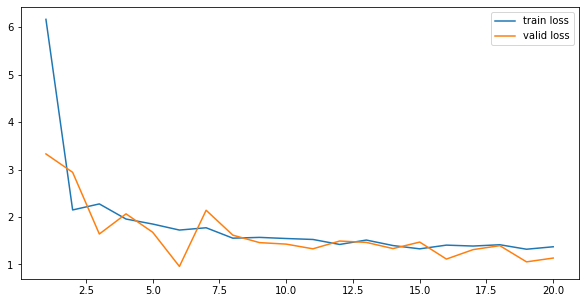

In [12]:
history = model.keras_model.history.history
epochs = range(1, config.EPOCHS + 1)
plt.figure(figsize=(10,5))
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.show()